In [1]:
import re, nbformat
from IPython.display import Markdown, display

# 1) Load this notebook’s JSON
nb = nbformat.read("cosso_exam.ipynb", as_version=4)

# 2) Scan every markdown cell for headings
toc_lines = []
for cell in nb.cells:
    if cell.cell_type != "markdown":
        continue
    for line in cell.source.splitlines():
        m = re.match(r"^(#{1,6})\s+(.*)", line)
        if not m:
            continue
        level = len(m.group(1))
        title = m.group(2).strip()
        # Generate the same anchor Jupyter uses:
        anchor = re.sub(r"[^\w\- ]+", "", title).lower().replace(" ", "-")
        toc_lines.append(f"{'  '*(level-1)}- [{title}](#{anchor})")

# 3) Display as Markdown
display(Markdown("# Table of Contents\n" + "\n".join(toc_lines)))

# Table of Contents
- [Esame metodi di Machine learning](#esame-metodi-di-machine-learning)
  - [Introduction](#introduction)
- [Classification](#classification)
  - [Data reading](#data-reading)
    - [Inspect and plot](#inspect-and-plot)
  - [Preprocess](#preprocess)
    - [`oversample_dataset(ds_raw, class_counts, cutoff_count = None, seed = 123)`](#oversample_datasetds_raw-class_counts-cutoff_count--none-seed--123)
    - [`preprocess(ds_raw, training=False, batch_size, target_size)`](#preprocessds_raw-trainingfalse-batch_size-target_size)
    - [Plotting the original dataset distributions](#plotting-the-original-dataset-distributions)
    - [Visualize the preprocessing steps:](#visualize-the-preprocessing-steps)
  - [Callbacks](#callbacks)
  - [Hyperparameter Tuning with Hyperband](#hyperparameter-tuning-with-hyperband)
    - [Algorithm Outline](#algorithm-outline)
    - [Head tuner](#head-tuner)
    - [Backbone Tuner](#backbone-tuner)
      - [Layers in `conv5_block3` (now trainable)](#layers-in-conv5_block3-now-trainable)
      - [Why unfreeze only this block?](#why-unfreeze-only-this-block)
  - [Building hyperparameter tuned Model](#building-hyperparameter-tuned-model)
    - [Hyperparameters retrieving:](#hyperparameters-retrieving)
      - [Head](#head)
      - [Backbone](#backbone)
    - [Model Building](#model-building)
      - [Macro F1 Metric](#macro-f1-metric)
  - [Training](#training)
    - [Head training only](#head-training-only)
    - [Fine tuning:](#fine-tuning)
  - [Grad-CAM Visualization](#grad-cam-visualization)
    - [1. Deprocessing (`resnet50_deprocess`)](#1-deprocessing-resnet50_deprocess)
    - [2. Locating the Convolutional Layer](#2-locating-the-convolutional-layer)
    - [3. Generating the Heatmap (`make_gradcam_heatmap`)](#3-generating-the-heatmap-make_gradcam_heatmap)
    - [4. Overlaying the Heatmap (`overlay_heatmap`)](#4-overlaying-the-heatmap-overlay_heatmap)
    - [5. Collecting Samples (`collect_samples`)](#5-collecting-samples-collect_samples)
    - [6. Plotting the Grid (`plot_gradcam_matrix`)](#6-plotting-the-grid-plot_gradcam_matrix)
    - [Expected Insights](#expected-insights)
    - [Mean Grad-CAM Comparison](#mean-grad-cam-comparison)
  - [Metrics](#metrics)
    - [ROC Curve and Confusion Matrix Overview](#roc-curve-and-confusion-matrix-overview)
      - [ROC](#roc)
      - [ROC Curve Details](#roc-curve-details)
      - [Confusion matrix](#confusion-matrix)
      - [Confusion Matrix Details](#confusion-matrix-details)
  - [An alternative model: DNN](#an-alternative-model-dnn)
    - [Preprocess](#preprocess)
      - [DNN Preprocessing Pipeline](#dnn-preprocessing-pipeline)
      - [A parenthesis: Explained Variance in PCA](#a-parenthesis-explained-variance-in-pca)
      - [Corner plot of the first dimensions](#corner-plot-of-the-first-dimensions)
    - [Building the DNN and training](#building-the-dnn-and-training)
      - [Callbacks](#callbacks)
    - [ROC](#roc)
      - [ROC result discussion](#roc-result-discussion)
    - [Confusion matrix](#confusion-matrix)
      - [Confusion matrix results](#confusion-matrix-results)
  - [Comparison between the models:](#comparison-between-the-models)
    - [Extracting the results](#extracting-the-results)
    - [Comparison Metrics](#comparison-metrics)
    - [UMAP plot](#umap-plot)
    - [Confusion matrix and conlcusions:](#confusion-matrix-and-conlcusions)
- [Anomaly detection](#anomaly-detection)
  - [File reading](#file-reading)
    - [Load and Prepare Anomaly Detection Datasets](#load-and-prepare-anomaly-detection-datasets)
      - [Normal vs. Anomaly](#normal-vs-anomaly)
      - [Anomaly Sampling](#anomaly-sampling)
      - [Splitting](#splitting)
  - [Oversampling and preprocessing](#oversampling-and-preprocessing)
  - [Feature model callbacks](#feature-model-callbacks)
  - [Building the feature model](#building-the-feature-model)
  - [Training the feature model's head](#training-the-feature-models-head)
  - [Fine tuning the last feature resnet block](#fine-tuning-the-last-feature-resnet-block)
  - [Confusion matrix](#confusion-matrix)
  - [Extracting feature model build](#extracting-feature-model-build)
  - [Embedding (feature vector) extraction:](#embedding-feature-vector-extraction)
  - [Normalising flows preprocessing](#normalising-flows-preprocessing)
    - [Visualize raw data](#visualize-raw-data)
    - [The choosen transformation](#the-choosen-transformation)
      - [Corner plots:](#corner-plots)
      - [Printing some marginal distributions info:](#printing-some-marginal-distributions-info)
    - [Alternative transformation](#alternative-transformation)
  - [GMM](#gmm)
    - [Introduction to Gaussian Mixture Models (GMM)](#introduction-to-gaussian-mixture-models-gmm)
      - [Model Definition](#model-definition)
      - [How It Works: The EM Algorithm](#how-it-works-the-em-algorithm)
      - [Why Use GMM?](#why-use-gmm)
      - [preprocess:](#preprocess)
    - [Tuning and building the model:](#tuning-and-building-the-model)
    - [Evaluation](#evaluation)
    - [Evaluation metrics](#evaluation-metrics)
      - [ROC](#roc)
      - [Confusion matrix](#confusion-matrix)
      - [Histograms of scores](#histograms-of-scores)
      - [Conclusions:](#conclusions)
  - [MAF](#maf)
    - [Callbacks](#callbacks)
    - [Building the chain:](#building-the-chain)
    - [Train:](#train)
    - [Saving model hyperparameters.](#saving-model-hyperparameters)
    - [Evaluate and visualize](#evaluate-and-visualize)
    - [ROC](#roc)
    - [score histograms](#score-histograms)
    - [Evaluation Metrics](#evaluation-metrics)
  - [RealNVP](#realnvp)
    - [Callbacks](#callbacks)
    - [Build the model](#build-the-model)
    - [Miscellaneous of metrics](#miscellaneous-of-metrics)
  - [VAE](#vae)
    - [Evaluation](#evaluation)
    - [ROC](#roc)
    - [Score histograms](#score-histograms)
    - [Miscellaneous of metrics](#miscellaneous-of-metrics)
  - [Comparison of the Anomaly Detection models](#comparison-of-the-anomaly-detection-models)
    - [Computing the scores](#computing-the-scores)
    - [Metrics miscellaneous table](#metrics-miscellaneous-table)
    - [ROC curves](#roc-curves)
    - [Precision-Recall curves](#precision-recall-curves)
    - [Confusion matrices](#confusion-matrices)
    - [UMAP plot](#umap-plot)
    - [MAF vs RealNVP](#maf-vs-realnvp)
      - [RealNVP](#realnvp)
      - [MAF](#maf)

# Esame metodi di Machine learning

## Introduction

This notebook addresses two core tasks:

1. **Galaxy Morphology Classification**  
   - Fine-tune a pre-trained **ResNet50** backbone (2048-dim feature maps) to classify 10 galaxy types.  
   - Compare against a custom fully-connected DNN on PCA-reduced inputs (from 69×69×3≈14283 down to 512 dims).  

2. **Anomaly Detection**  
   - Treat the three most populous classes as “normal” and the last three as anomalies.  
   - Extract 32-dim feature embeddings from ResNet50, then model their density via three approaches:  
     $$p(\mathbf{x}) \approx \mathrm{MAF}(\mathbf{x})/\mathrm{RealNVP}(\mathbf{x}),\quad \mathrm{VAE}, \quad\text{or\;GMM}(\mathbf{x}).$$  
   - Compare how Normalizing Flows (MAF vs RealNVP) stack up against a simpler Gaussian Mixture Model or a less simple VAE.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

# local imports
from model_builders import (build_class_ResNet50_model, build_dnn_classifier, build_feature_model,
                             build_clamped_maf_keras_model, build_realnvp_keras_model, VAE)
from callbacks import (ParamLoggingCallback, CatchAndDebugNaN)
from data_utils import (inspect_and_plot_h5, get_datasets, preprocess, oversample_dataset, visualize_single_preprocessing,
                        need_training, resnet50_deprocess, plot_gradcam_matrix, plot_resnet_roc,compute_dataset_mean_std, 
                        preprocess_no_resize_with_stats,
                        pca_need_fit, get_or_cache_pca_dataset, plot_dnn_roc, plot_confusion_matrix, get_anomaly_datasets,
                        evaluate_to_visual, plot_score_histograms, plot_maf_roc_curve, 
                        plot_gradcam_means, need_anom_datasets, save_anom_cache, vae_anomaly_score, plot_umap_classifier_comparison,
                        get_stratified_datasets, get_stratified_anomaly_datasets, plot_anom_umap_per_model, plot_marginal_differences)
from metrics import (MacroF1, )

import numpy as np
from sklearn.metrics import (roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, recall_score,
                             roc_auc_score, average_precision_score,precision_score,matthews_corrcoef, 
                             accuracy_score, precision_recall_fscore_support, precision_recall_curve)
from sklearn.preprocessing import label_binarize,StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import joblib
import json
import seaborn as sns                         
import random
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
from tensorflow.keras import backend as K
import kerastuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
import logging

# ==================== Suppress TensorFlow Warnings ====================
logging.getLogger('tensorflow').setLevel(logging.ERROR)
try:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
except ImportError:
    pass
tf.get_logger().propagate = False

#==================== GPU Configuration ====================
def get_training_device() -> str:
    gpus = tf.config.list_logical_devices('GPU')
    if gpus:
        return gpus[0].name          # '/device:GPU:0'
    return '/device:CPU:0'

SEED = 123
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-06-25 12:37:43.902728: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 12:37:43.987926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 12:37:45.183708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/teo_fs_fast/software/miniforge/envs/acosso_tf2_12/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  f

Setting global variables

In [4]:
# Configuration
IMG_SIZE = (69, 69)
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 10



# Classification

**Classifier achitecture structure**  
- Loading a pre-trained **ResNet50** backbone (ImageNet-trained on ~1.3 M images, 1000 classes).  
- Replacing its top layers with:  
  1. `GlobalAveragePooling2D()`  
  2. `Dropout(rate=0.5)`  
  3. `Dense(10, activation='softmax')`

**Why are we doing this?**  
- **Transfer Learning:** Leverage rich, low-level features learned on ImageNet to speed up convergence and boost accuracy on our galaxy dataset.  
- **Global Average Pooling** reduces the `[batch, 7, 7, 2048]` tensor to `[batch, 2048]` via  
  $$[B,7,7,2048]\;\xrightarrow{\mathrm{GAP}}\;[B,2048],$$  
  cutting parameters (vs. flatten) and adding spatial invariance.  
- **Dropout** acts as a regularizer.

**Fine-tuning Strategy:**  
1. **Head-Only Training:** Freeze all ResNet50 layers; train only the new head to learn task-specific mappings.  
2. **Partial Unfreezing:** Unfreeze the top convolutional blocks (e.g. `conv5_*`) and continue training at a lower learning rate to refine features without catastrophic forgetting.  

**The alternative model: a DNN**
1. The idea is to take the flatten image vector ($69 \cdot 69 \cdot 3 = 14283$) to a smaller dimension using PCA
2. Feed the new dimension-reduced vector to a DNN. More details about the hyperparameters in the dedicated section.

**Loss choice:** for every ResNet50 and DNN in this notebook i choose to minimize the weighted `sparse_categorical_crossentropy` (sparse because of how the labels are encoded). This choice comes from the fact that the dataset is highly unbalanced as i will illustrate betted in dedicated sections. 

$$
\mathcal{L}_{\text{sparse\_cat}}(y, \hat{p}) \;=\; -\log\bigl(\hat{p}_{\,y}\bigr)
$$

or, over a batch of \(N\) examples:

$$
\mathcal{L}_{\text{sparse\_cat}} = -\frac{1}{N}\sum_{n=1}^{N}\log\bigl(\hat{p}_{n,\,y_n}\bigr)
$$
where $y$ is the true class lable encoded as an integer index and $\hat p$ is the predicted probability vector, so $\hat p_{y}$ is the single scalar entry of that vector corresponding to the true class $y$

## Data reading

### Inspect and plot
This function takes one random image form each class and plot it.

Dataset contains 21785 images of size (69, 69, 3) and 10 classes
  Class 0: 3461 images
  Class 1: 6997 images
  Class 2: 6292 images
  Class 3: 349 images
  Class 4: 1534 images
  Class 5: 17 images
  Class 6: 589 images
  Class 7: 1121 images
  Class 8: 906 images
  Class 9: 519 images


2025-06-25 12:38:30.120738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43611 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:87:00.0, compute capability: 8.9
2025-06-25 12:38:30.136865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43611 MB memory:  -> device: 1, name: NVIDIA L40S, pci bus id: 0000:c3:00.0, compute capability: 8.9
2025-06-25 12:38:30.150950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43611 MB memory:  -> device: 2, name: NVIDIA L40S, pci bus id: 0000:c4:00.0, compute capability: 8.9
2025-06-25 12:38:30.173719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 43611 MB memory:  -> device: 3, name: NVIDIA L40S, pci bus id: 0000:c5:00.0, compute capability: 

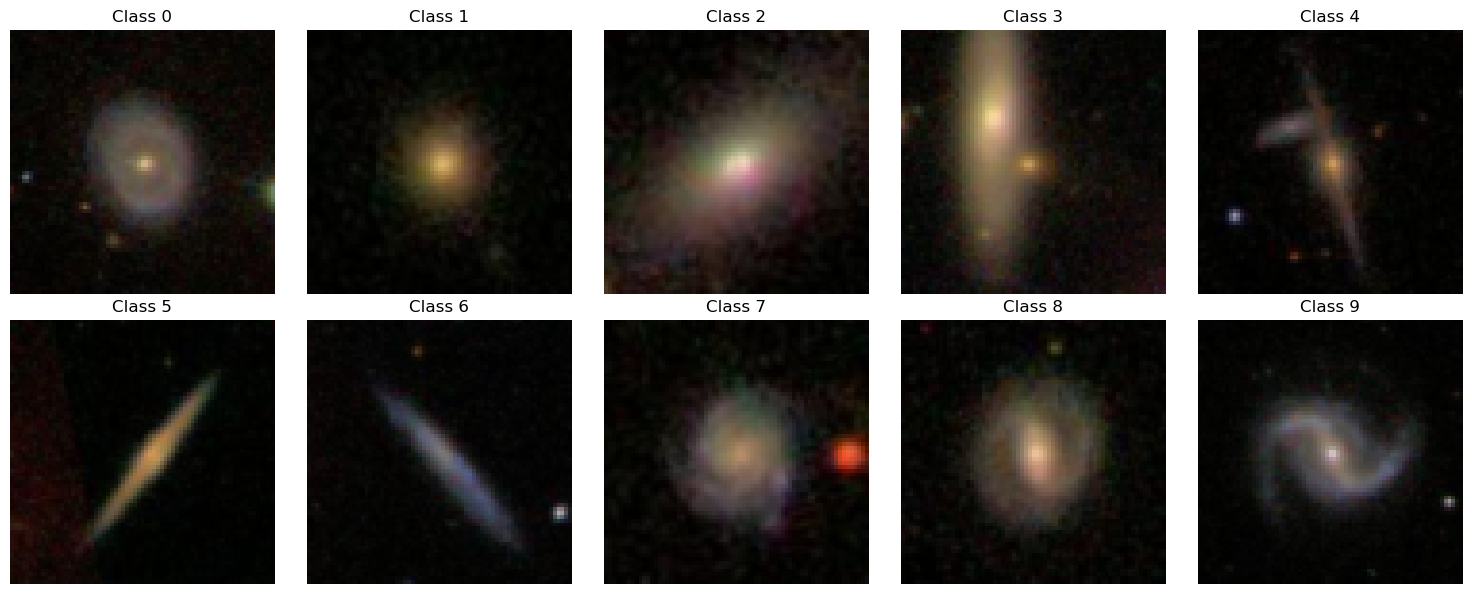

In [5]:
DATA_DIR = "./Galaxy10.h5"
inspect_and_plot_h5(DATA_DIR, img_size=IMG_SIZE)

## Preprocess
This preproces is done by having in mind the extreme class imbalance. I try to adress this problem by oversampling the minority classes to a cutoff value that if not passed to the oversampling function (like in the case i'm presenting) will be set to the second smallest class population. To further counteract the class imbalance i choose to use a class weighted loss function. **NOTE:** due to unavailable space on the disk on wich i run the code, I'm not able to cache the dataset used for training, so i adressed this problem by calling the splitting function with the same fixed seed and shuffling only after the split. 

### `oversample_dataset(ds_raw, class_counts, cutoff_count = None, seed = 123)`
This simply repeats the images in the class to oversample, to later be augmented by the preprocessing function. As i said, the target number of images can be passed as an input, or left to the function. In the fist case it will upsample all the classes with population lower thant the cutoff value to this value, in the second scenario it will set the cutoff value to the second smallest class population.

### `preprocess(ds_raw, training=False, batch_size, target_size)`

Transforms a raw `tf.data.Dataset` of `(image, label)` pairs into a ready-to-use dataset for ResNet50.

1. **Data Augmentation** *(only if `training=True`)*  
   A `tf.keras.Sequential` block applies, in order:  
   - **RandomFlip**: horizontal & vertical  
   - **RandomRotation**: ±360°  
   - **RandomZoom**: ±10%  
   - **RandomContrast**: ±10%  
   - **GaussianNoise**: σ = 0.01 :contentReference[oaicite:0]{index=0}

2. **Resize**  
   Each image is resized (bilinear) to `target_size` (e.g. 224×224).

3. **Normalize**  
   Uses `tf.keras.applications.resnet50.preprocess_input` to convert from `[0,255]` uint8 → float, then:  
   - Scale to [0,1]  
   - Subtract ImageNet means (BGR order): [103.939, 116.779, 123.68]  
   - Divide by ImageNet stds: [0.229, 0.224, 0.225]  
   This matches the format expected by the pretrained ResNet50 :contentReference[oaicite:1]{index=1}.

4. **Shuffle, Batch & Prefetch**  
   - If `training=True`, shuffle with buffer 1024 (seeded for reproducibility).  
   - Batch to `batch_size`.  
   - Prefetch with `tf.data.AUTOTUNE` to overlap preprocessing & GPU work.


In [6]:
# reading raw data from the dataset, the get_stratified_datasets function will split the data into 
# train, validation and test sets by stratification and return them as TensorFlow datasets.

resnet_train_ds_raw, resnet_val_ds_raw, resnet_test_ds_raw, class_weights, class_counts_train, class_counts_full = get_stratified_datasets(
    "Galaxy10.h5", val_split=0.2, test_split=0.1, seed=123
)

# taking the train data and oversampling to the second-smallest class size, in this case it takes class 5 to the dimension of class 3
# it is also posssible to pass a specific cutoff value, e.g. 1000, to oversample all classes to that size
resnet_balanced_train_raw = oversample_dataset(resnet_train_ds_raw, class_counts_train)

# some prints
print(f"Original Class 5 count after splitting: {class_counts_train.get(5, 0)}")
sorted_counts = sorted(class_counts_train.values())
target_count = sorted_counts[1] if len(sorted_counts) >= 2 else sorted_counts[0]
print(f"Oversampled Class 5 will be up to: {target_count} samples per epoch")


# Preprocessing datasets
resnet_train_ds = preprocess(resnet_balanced_train_raw, training=True,
                              batch_size=BATCH_SIZE, target_size=TARGET_SIZE)
resnet_val_ds   = preprocess(resnet_val_ds_raw,   training=False,
                              batch_size=BATCH_SIZE, target_size=TARGET_SIZE)
resnet_test_ds  = preprocess(resnet_test_ds_raw,  training=False, 
                              batch_size=BATCH_SIZE, target_size=TARGET_SIZE)

# Caching and prefetching datasets for performance
resnet_test_ds = resnet_test_ds.cache().prefetch(tf.data.AUTOTUNE)
resnet_test_ds_raw = resnet_test_ds_raw.cache().prefetch(tf.data.AUTOTUNE)

Original Class 5 count after splitting: 12
Oversampled Class 5 will be up to: 244 samples per epoch


### Plotting the original dataset distributions
This bar chart shows the class counts in the full dataset. As you can see, there is a significant class imbalance, which I attempted to address by oversampling after the train/val/test split and by using a class weighted loss. However, a large gap still remains between the first three classes and the rest. To further adress this class imbalance I could also have implemented: 
- Undersampling the majority classes to reduce their weight
- Synthetic oversampling techniques to generate new minority-class examples

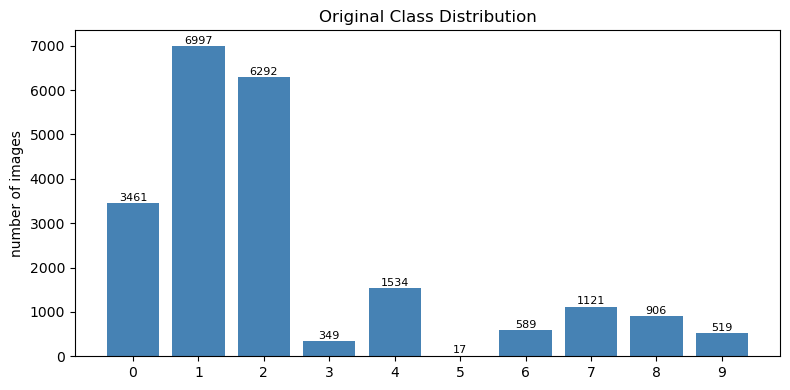

In [7]:
def plot_class_distribution(class_counts, title="Class distribution", figsize=(8, 4)):
    """Simple bar-plot of images per class."""
    classes  = list(sorted(class_counts))
    counts   = [class_counts[c] for c in classes]

    plt.figure(figsize=figsize)
    plt.bar(classes, counts, color="steelblue")
    plt.xticks(classes)
    plt.ylabel("number of images")
    #plt.yscale("log")
    plt.title(title)
    for i,c in enumerate(counts):
        plt.text(i, c+5, str(c), ha="center", va="bottom", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_class_distribution(class_counts_full, title="Original Class Distribution")

### Visualize the preprocessing steps:
This function take an image from the raw dataset and apply the preprocessing steps gradually to visualize the preprocess step by step.

2025-06-25 12:38:48.627575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [15249]
	 [[{{node Placeholder/_1}}]]
2025-06-25 12:38:48.627962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [15249]
	 [[{{node Placeholder/_1}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.06675..109.87887].


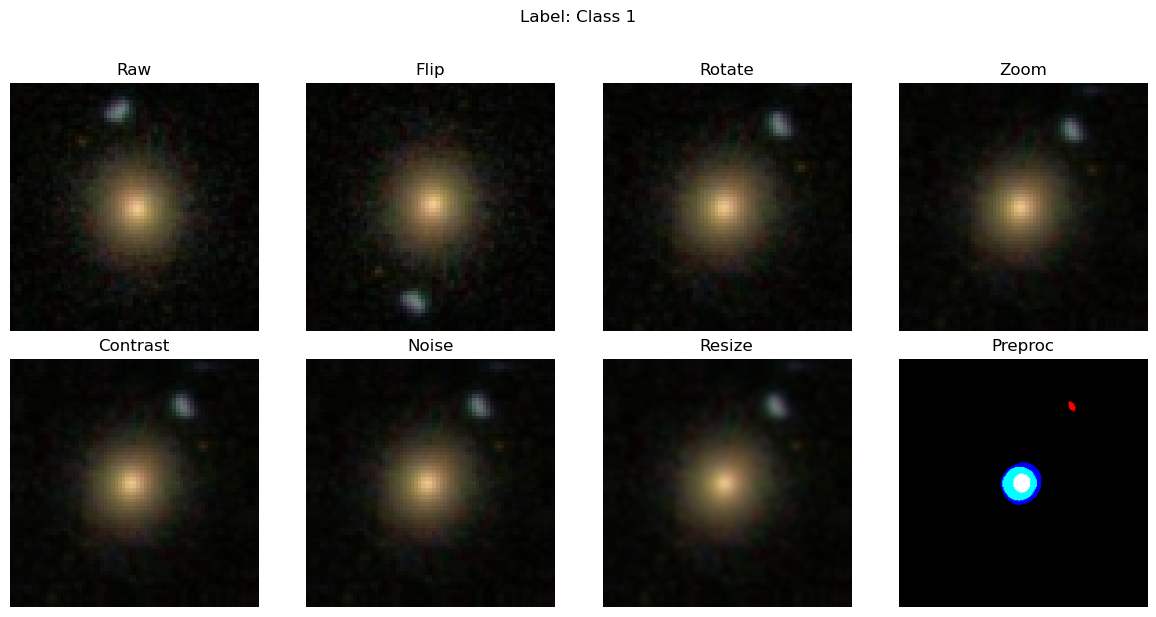

In [8]:
class_names = {i: f"Class {i}" for i in range(10)}
visualize_single_preprocessing(resnet_train_ds_raw, class_names)

## Callbacks

**ModelCheckpoint**  
Saves only the model weights that achieve the highest validation accuracy. This ensures to always keep the best-performing snapshot.

**EarlyStopping**  
Monitors validation accuracy and halts training if it doesn’t improve for a choosen number of consecutive epochs, then automatically restores the best weights—preventing wasted epochs and overfitting.

**ReduceLROnPlateau**  
Cuts the learning rate whenever validation accuracy plateaus for a set number of epochs, down to a floor.


In [9]:
# 1) Checkpoint: save only the best weights
checkpoint_cb_resnet = ModelCheckpoint(
    "best_resnet50_weights.h5",  # filepath
    monitor="val_accuracy",       # or "val_loss" / "val_macro_f1"
    save_best_only=True,
    save_weights_only=True,       # only weights; change to False to save entire model
    mode="max",                   # because higher accuracy is better
    verbose=1,
)

# 2) Early stopping to avoid overtraining
earlystop_cb_resnet = EarlyStopping(
    monitor="val_accuracy",
    patience=4,       # stop if no improvement in 3 epochs
    restore_best_weights=True,  # roll back to best at end of training
    verbose=1,
)

# 3) Create ReduceLROnPlateau
reduce_lr_cb_resnet = ReduceLROnPlateau(
    monitor="val_accuracy",    # what to monitor
    factor=0.5,            # reduce LR by this factor
    patience=2,            # wait this many epochs before reducing
    min_lr=1e-6,           # lower bound on LR
    verbose=1
)

## Hyperparameter Tuning with Hyperband

Hyperband is an efficient allocation strategy that combines **random sampling** of hyperparameter configurations with **successive halving** to focus compute on the most promising trials.

- **R (max_epochs)**: maximum epochs per trial  
- **η (factor)**: reduction rate for pruning

### Algorithm Outline

1. Compute  
   - `s_max = ⌊log_η(R)⌋`  
   - `B = (s_max + 1) · R`  
2. For each bracket `s = s_max … 0`:  
   1. Sample `n = ⌈(B/R)·η^s / (s+1)⌉` random configs  
   2. Allocate `r = R·η^(−s)` epochs to each  
   3. **Successive halving**:  
      - Train all `n` for `r` epochs  
      - Keep top `⌈n/η⌉`, train them for `r·η` more epochs  
      - Repeat until the best config has used up to `R` epochs  
---
**NOTE:** i will leave the tuner commented. The running time is too high and the befenits too low. In the retrieving process i will default to the values i got from my run if the tuner is not available. I could have sent you the results folder but to keep it clean i think this is the best solution. 


### Head tuner
Building the head tuner, it will tune only the dropout rate and the learning rate. This is a bit overkill but i already implemented it so i'll use it. The tuning time substancial, almost 50 minutes for the head. I'll reccomand loading the existing results. 

In [10]:

# Define the hyperparameter tuning function, it build the model with multiple hyperparameters from which to pick. 
# The model is built with trainable_backbone=False, meaning that the ResNet50 backbone is frozen and only the head is trained.
# more details about the model can be found in the build_class_ResNet50_model function in model_builders.py
'''
def head_tuner_build(hp):
    return build_class_ResNet50_model(
      dropout_rate=hp.Float("dropout", 0.1, 0.5, step=0.1),
      learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4]),
      trainable_backbone=False
    )

PROJECT_DIR = "./hyperp_tuning"
# tuner object
head_tuner = kt.Hyperband(
    head_tuner_build,
    objective="val_accuracy",
    max_epochs=7,        # tuner will try up to this many epochs per trial
    factor=3,
    directory=PROJECT_DIR,
    project_name="galaxy_head_tuning",
)


# Check if the project directory exists, if true, skip the tuner search
dir = PROJECT_DIR + "/galaxy_head_tuning"
# Only run tuner if the project directory is missing or empty
if not os.path.exists(dir) or not os.listdir(dir):
    print(f"Running hyperparameter search in {dir} …")
    head_tuner.search(
        resnet_train_ds,
        validation_data=resnet_val_ds,
        callbacks=[earlystop_cb_resnet],
        batch_size=128,
    )
else:
    print(f"Skipping search; logs already exist in {dir}")
#head_tuner.results_summary()
'''

'\ndef head_tuner_build(hp):\n    return build_class_ResNet50_model(\n      dropout_rate=hp.Float("dropout", 0.1, 0.5, step=0.1),\n      learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4]),\n      trainable_backbone=False\n    )\n\nPROJECT_DIR = "./hyperp_tuning"\n# tuner object\nhead_tuner = kt.Hyperband(\n    head_tuner_build,\n    objective="val_accuracy",\n    max_epochs=7,        # tuner will try up to this many epochs per trial\n    factor=3,\n    directory=PROJECT_DIR,\n    project_name="galaxy_head_tuning",\n)\n\n\n# Check if the project directory exists, if true, skip the tuner search\ndir = PROJECT_DIR + "/galaxy_head_tuning"\n# Only run tuner if the project directory is missing or empty\nif not os.path.exists(dir) or not os.listdir(dir):\n    print(f"Running hyperparameter search in {dir} …")\n    head_tuner.search(\n        resnet_train_ds,\n        validation_data=resnet_val_ds,\n        callbacks=[earlystop_cb_resnet],\n        batch_size=128,\n    )\nelse:\n    print(f"Ski

### Backbone Tuner

I use the same hyperparameters as the head tuner (`dropout_rate` ∈ [0.1, 0.5], `learning_rate` ∈ {1e-2, 1e-3, 1e-4}), but now I unfreeze only the final ResNet50 block (`conv5_block3_*`) so that the model can fine-tune high-level features.

#### Layers in `conv5_block3` (now trainable)

- **conv5_block3_1_conv** (Conv2D)  
  – Output shape: (7, 7, 512)  
  – Params: 1,049,088  

- **conv5_block3_1_bn** (BatchNormalization)  
  – Output shape: (7, 7, 512)  
  – Params: 2,048  

- **conv5_block3_1_relu** (Activation)  
  – Output shape: (7, 7, 512)  

- **conv5_block3_2_conv** (Conv2D)  
  – Output shape: (7, 7, 512)  
  – Params: 2,359,808  

- **conv5_block3_2_bn** (BatchNormalization)  
  – Output shape: (7, 7, 512)  
  – Params: 2,048  

- **conv5_block3_2_relu** (Activation)  
  – Output shape: (7, 7, 512)  

- **conv5_block3_3_conv** (Conv2D)  
  – Output shape: (7, 7, 2048)  
  – Params: 1,050,624  

- **conv5_block3_3_bn** (BatchNormalization)  
  – Output shape: (7, 7, 2048)  
  – Params: 8,192  

- **conv5_block3_add** (Add)  
  – Output shape: (7, 7, 2048)  

- **conv5_block3_out** (Activation)  
  – Output shape: (7, 7, 2048)  

#### Why unfreeze only this block?

- **High-level features**: the final block captures the most abstract, class-specific patterns.  
- **Compute & overfitting**: fine-tuning just one block minimizes extra parameters and reduces the forgetting risk.

This block is also really slow. It takes too much time for so little improvements. I reccommend again to use the existing results.

In [11]:
### all the same as above, but with trainable backbone

# By setting trainable_backbone=True, the builder function expects also the unfrozen_blocks parameter, 
# which is a tuple of strings that specify which blocks of the ResNet50 backbone should be unfrozen and trained. 
# In my case, I choose to unfreeze the last block, "conv5_block3", which is the last convolutional block of the ResNet50 architecture.
'''
def backbone_tuner_build(hp):
    return build_class_ResNet50_model(
      dropout_rate=hp.Float("dropout", 0.1, 0.5, step=0.1),
      learning_rate=hp.Choice("lr", [1e-3, 1e-4, 1e-5]),
      trainable_backbone=True,
      unfrozen_blocks=("conv5_block3",)
    )

backbone_tuner = kt.Hyperband(
    backbone_tuner_build,
    objective="val_accuracy",
    max_epochs=13,        # tuner will try up to this many epochs per trial
    factor=3,
    directory=PROJECT_DIR,
    project_name="galaxy_backbone_tuning",
)
dir = PROJECT_DIR + "/galaxy_backbone_tuning"
# Only run tuner if the project directory is missing or empty
if (not os.path.exists(dir) or not os.listdir(dir)):
    print(f"Running hyperparameter search in {dir} …")
    backbone_tuner.search(
        resnet_train_ds,
        validation_data=resnet_val_ds,
        callbacks=[earlystop_cb_resnet],
        batch_size=128,
    )
else:
    print(f"Skipping search; logs already exist in {dir}")
#backbone_tuner.results_summary()
'''


'\ndef backbone_tuner_build(hp):\n    return build_class_ResNet50_model(\n      dropout_rate=hp.Float("dropout", 0.1, 0.5, step=0.1),\n      learning_rate=hp.Choice("lr", [1e-3, 1e-4, 1e-5]),\n      trainable_backbone=True,\n      unfrozen_blocks=("conv5_block3",)\n    )\n\nbackbone_tuner = kt.Hyperband(\n    backbone_tuner_build,\n    objective="val_accuracy",\n    max_epochs=13,        # tuner will try up to this many epochs per trial\n    factor=3,\n    directory=PROJECT_DIR,\n    project_name="galaxy_backbone_tuning",\n)\ndir = PROJECT_DIR + "/galaxy_backbone_tuning"\n# Only run tuner if the project directory is missing or empty\nif (not os.path.exists(dir) or not os.listdir(dir)):\n    print(f"Running hyperparameter search in {dir} …")\n    backbone_tuner.search(\n        resnet_train_ds,\n        validation_data=resnet_val_ds,\n        callbacks=[earlystop_cb_resnet],\n        batch_size=128,\n    )\nelse:\n    print(f"Skipping search; logs already exist in {dir}")\n#backbone_tun

## Building hyperparameter tuned Model

### Hyperparameters retrieving: 

#### Head


In [12]:
# Load the best hyperparameters from the tuner, if available. 
# If the tuner is not available, it falls back to default values I got from the tuning results.
try:
    best_hps = head_tuner.get_best_hyperparameters(num_trials=1)
    head_dropout = best_hps[0].get("dropout")
    head_lr      = best_hps[0].get("lr")
    print("Loaded best hyperparameters from tuner:")
    print(f"  • dropout = {head_dropout}")
    print(f"  • learning rate = {head_lr}")
except Exception as e:
    # Any failure here (NameError, missing folder, etc) falls back:
    head_dropout = 0.1
    head_lr      = 1e-3
    print("Tuner unavailable, using defaults:")
    print(f"  • dropout = {head_dropout}")
    print(f"  • learning rate = {head_lr}")

Tuner unavailable, using defaults:
  • dropout = 0.1
  • learning rate = 0.001


#### Backbone


In [13]:
try:
    # If you’ve left the tuner code commented out but have saved its 
    # results folder, this will succeed:
    best_hps = backbone_tuner.get_best_hyperparameters(num_trials=1)
    backbone_dropout = best_hps[0].get("dropout")
    backbone_lr = best_hps[0].get("lr")
    print("Loaded best hyperparameters from tuner:")
    print(f"  • dropout = {backbone_dropout}")
    print(f"  • learning rate = {backbone_lr}")
except Exception as e:
    # Any failure here (NameError, missing folder, etc) falls back:
    backbone_dropout = 0.1
    backbone_lr      = 1e-4
    print("Tuner unavailable, using defaults:")
    print(f"  • dropout = {backbone_dropout}")
    print(f"  • learning rate = {backbone_lr}")

Tuner unavailable, using defaults:
  • dropout = 0.1
  • learning rate = 0.0001


### Model Building

Build the model using the hyperparameters retrieved by the tuner. It monitors a custom metric: 
#### Macro F1 Metric

**What is Macro F1?**  
The F1 score is the harmonic mean of precision and recall:  
$$
\text{F1} = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$  
Macro-averaging computes the F1 score for each class independently, then takes the unweighted mean across all classes—treating each class equally, regardless of its frequency.

---

**Implementation Highlights**  
- **State variables** (`tp`, `fp`, `fn`):  
  Track true positives, false positives, and false negatives for each of the 10 classes.  
- **`update_state(y_true, y_pred)`**:  
  - Converts labels and predictions to one-hot vectors.  
  - Increments `tp`, `fp`, `fn` by summing over the current batch.  
- **`result()`**:  
  - Computes per-class precision and recall without NaNs.  
  - Calculates per-class F1 and returns their average.  
- **`reset_state()`**:  
  Clears the counters at the end of each epoch.

---

**Why use Macro F1?**  
- **Balances class importance**: Overall accuracy can be misleading on imbalanced data, as the model may favor majority classes.  
- **Equal emphasis on minority classes**: Ensures underrepresented classes contribute equally to the final metric.  
- **Better diagnostic**: Monitoring Macro F1 alongside accuracy provides a clearer picture of performance across all classes.  


In [14]:
# metric for the model, in this case MacroF1, which is a custom metric defined in metrics.py
macro_f1 = MacroF1(num_classes=10) 
# The model building function is defined in model_builders.py, it builds a pretrained ResNet50 model.
model = build_class_ResNet50_model(trainable_backbone=False,
                    dropout_rate=head_dropout,
                    learning_rate=head_lr,
                    metrics=[macro_f1, "accuracy"]) 


## Training

This function returns False and loads the weights if present, otherwise retunrs True. The force flag overwrites everything. This logic will be found throughout the whole notebook and often by calling this same function. The function is defined in data_utils.py

In [15]:
model, need_train = need_training(model, "best_resnet50_weights.h5", force_retrain=False)

 Weights found at 'best_resnet50_weights.h5' → loading and skipping training.


### Head training only
Train only if the need_train variable is True. I've chosse a sparse categorical cross entropy loss and monitor the accuracy and the macro f1 objective. The model building function by default set the backone freezed to train only the head parameters. For the Backbone training I will unfreeze part of the backbone (exactly like in the hyperparameters tuner). 

In [16]:
## hyperparameters for training are the ones we got from the tuner (the tuner for the backbone found the same valuesas the head tuner)
epochs = 25
if need_train:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics = [macro_f1, "accuracy"]
    )
    
    with tf.device(get_training_device()):
        history_head = model.fit(resnet_train_ds,
                                 validation_data=resnet_val_ds,
                                 epochs=epochs,
                                 class_weight=class_weights,
                                 callbacks=[checkpoint_cb_resnet, earlystop_cb_resnet, reduce_lr_cb_resnet]
        ) 


### Fine tuning: 
Training the backbone last block and the head toghether

In [17]:
#unfreezing blocks given as kwarg
epochs = 25
if need_train:
    def unfreeze_blocks(model, blocks=("conv5_block3",)):
        for layer in model.layers:
            if any(layer.name.startswith(b) for b in blocks):
                layer.trainable = True
    
    # unfreeze the last ResNet block
    unfreeze_blocks(model, ("conv5_block3",))
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(backbone_lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=[macro_f1, "accuracy"],
    )
    with tf.device(get_training_device()):
        history_ft = model.fit(resnet_train_ds,
                               validation_data=resnet_val_ds,
                               epochs=epochs,
                               class_weight=class_weights,
                               callbacks=[checkpoint_cb_resnet, earlystop_cb_resnet, reduce_lr_cb_resnet]
        )


## Grad-CAM Visualization

Grad-CAM highlight which regions of each image most influenced the ResNet50 model’s predictions. Here’s how I implemented it:

---

### 1. Deprocessing (`resnet50_deprocess`)  
Invert the ResNet50 preprocessing by adding back ImageNet means, converting BGR→RGB, and clipping to [0,255], producing a displayable `uint8` image from the model’s float32 input.

---

### 2. Locating the Convolutional Layer  
- Search recursively for a layer by name using `_get_layer_recursive(model, name)`.  
- If the layer isn't specified, `_find_last_conv(model)` automatically finds the last `Conv2D` in the network.

---

### 3. Generating the Heatmap (`make_gradcam_heatmap`)  
1. Build a gradient model that outputs both the chosen convolutional feature maps and the final predictions.  
2. Run a forward pass to get feature maps and logits.  
3. Define the loss for the target class (either the predicted class or one specified).  
4. Backpropagate to obtain gradients of that loss with respect to the feature maps.  
5. Pool those gradients spatially to get channel-wise importance weights.  
6. Compute a weighted sum of the feature maps, apply ReLU and normalize to produce the 2D heatmap.

---

### 4. Overlaying the Heatmap (`overlay_heatmap`)  
Convert the raw image to float [0,1], apply a “turbo” colormap to the heatmap, and blend it over the image.

---

### 5. Collecting Samples (`collect_samples`)  
Scan the entire test dataset once, capturing the first **correct** and **incorrect** example for each class. This ensures we visualize both true positives and false negatives.

---

### 6. Plotting the Grid (`plot_gradcam_matrix`)  
1. Bucket one correct and one incorrect sample per class.  
2. Filter by the classes to inspect.  
3. For each sample, it preprocess, predict, generate its heatmap, and deprocess for display.
4. It plots only the top 40% of the heatmap to leave the noise out.
5. Plot a two-column grid:  
   - Left: true positives  
   - Right: false negatives 
   with titles showing the true and predicted labels.

This pipeline allows me to visually inspect which image regions drove my model’s decisions, both for its successes and failures.  

---

### Expected Insights

By comparing Grad-CAM overlays on **mismatched (false negative)** images against **correctly classified** ones, one can expect to:

- **Identify Focus Failures**: See if the model attends to irrelevant regions or misses key features in misclassified images.  
- **Understand Class Confusions**: Observe whether the heatmaps for errors highlight similar areas as the correct class, suggesting systematic confusion between classes.  
- **Validate Robustness**: Confirm that correctly classified examples consistently show strong activations on distinctive class features, reinforcing confidence in the model’s learned representations.  



2025-06-25 12:38:59.323340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [2179]
	 [[{{node Placeholder/_1}}]]
2025-06-25 12:39:01.007665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2025-06-25 12:39:01.338256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-06-25 12:40:32.570291: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).re

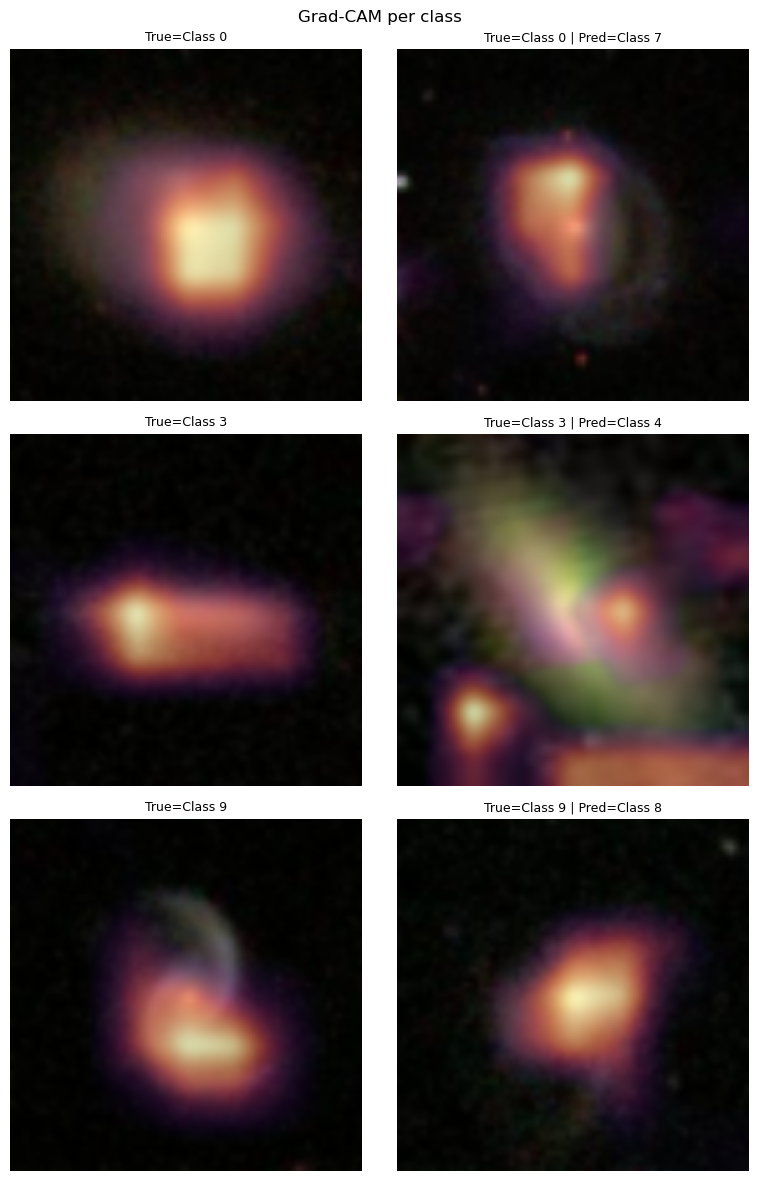

In [18]:
# Setting the preprocessing function for the ResNet50 model, which is used to preprocess the input images before feeding them to the model.
preprocess_fn = tf.keras.applications.resnet50.preprocess_input 
# 3) Run the visualiser.
fig = plot_gradcam_matrix(
         model,
         resnet_test_ds_raw,
         class_names=class_names,  # optional; otherwise 0-9
         last_conv_layer_name='conv5_block3_out',  # inside your `resnet50` sub-model
         classes_to_plot=[0,3,9],
         deprocess_fn=resnet50_deprocess, # optional deprocessing function
         preprocess_fn=preprocess_fn,  # optional preprocessing function
         alpha=0.8,  # alpha for blending heat-map with image
     )
fig.show()

As you can see form the GradCAM visualization, for the mis-classified images the network wasn't able to detect correctly the galaxy structure. I'm taking the  GradCAM map from the last convolutinla layer that in output has a square 7x7. This results in a lower resolution but should be more accurate in terms of sensitivity and spacial correlation. 

### Mean Grad-CAM Comparison

In this figure there is comparison between the average Grad-CAM activation maps for correctly classified images against those for misclassified images. In the last row i reported the difference between the two. The spatial distribution of the model’s attention shifts when it makes errors.


2025-06-25 12:40:35.804952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [2179]
	 [[{{node Placeholder/_1}}]]


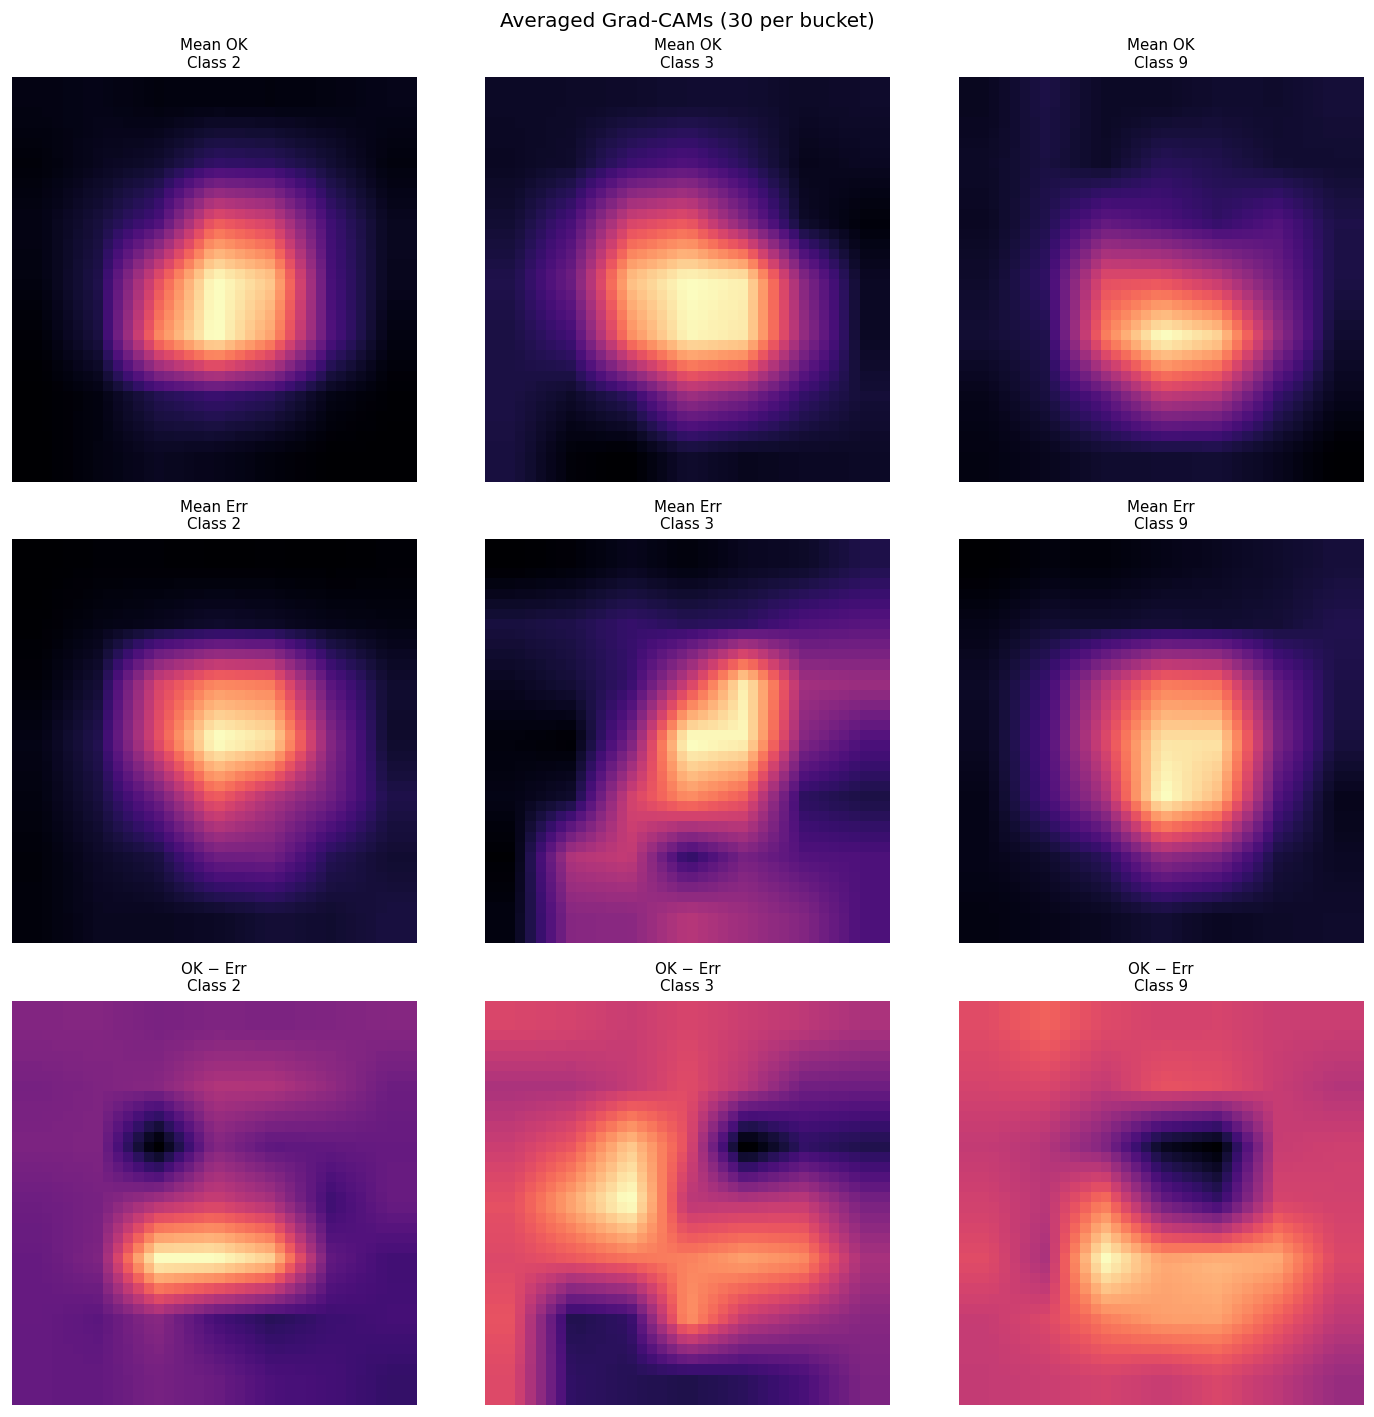

In [19]:
fig = plot_gradcam_means(
        model=model,
        dataset=resnet_test_ds_raw,   # raw uint8 RGB
        class_ids=[2, 3, 9],          # pick classes of interest
        max_per_bucket=30,            # 30 correct + 30 wrong each
        last_conv="conv5_block3_out",
        preprocess=tf.keras.applications.resnet50.preprocess_input,
        figsize=(12, 12),
    )
fig.show()

## Metrics

In this section, I report a few basic metrics to evaluate the model’s performance. Additional metrics will be analyzed later when comparing this ResNet model to the next candidate.

### ROC Curve and Confusion Matrix Overview

**ROC Curve**  
I use the Receiver Operating Characteristic (ROC) Curve to visualize the trade-off between true positive rate (sensitivity) and false positive rate (1 – specificity) across all classification thresholds.  
- A model that perfectly separates classes will have a curve that hugs the top-left corner and an AUC (area under the curve) of 1.  
- An AUC of 0.5 indicates no better than random chance.  
- **Why it’s meaningful:** by examining the ROC and AUC, I can assess how well the model discriminates between classes independent of any single decision threshold.

---

**Confusion Matrix**  
The confusion matrix tabulates the counts of true positives, false positives, true negatives, and false negatives for each class.  
- Rows represent **actual** classes, columns represent **predicted** classes.  
- The diagonal shows correct classifications; off-diagonals show where the model confuses one class for another.  
- **Why it’s meaningful:** it gives a detailed breakdown of per-class performance, highlighting specific misclassification patterns that overall accuracy can hide.

---

Together, the ROC curve (and its AUC) provides a threshold-agnostic measure of discrimination, while the confusion matrix offers a granular view of where the model succeeds or fails for each class. This combination gives a comprehensive picture of model performance.  



#### ROC

2025-06-25 12:41:14.767284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [2179]
	 [[{{node Placeholder/_1}}]]
2025-06-25 12:41:14.767662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [2179]
	 [[{{node Placeholder/_1}}]]


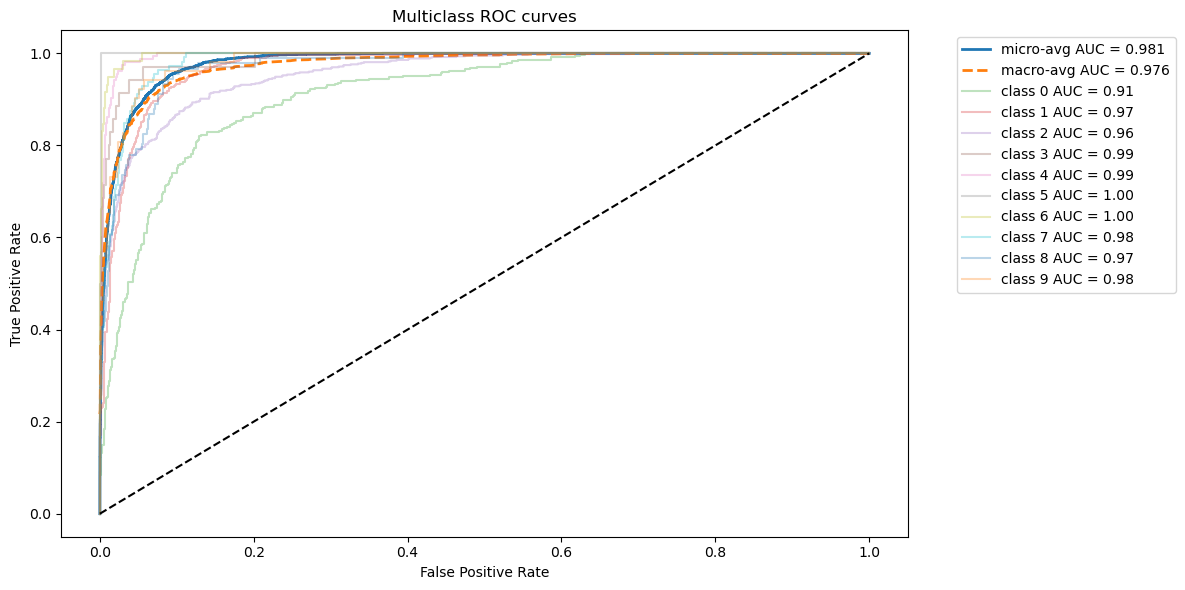

In [20]:
plot_resnet_roc(model, resnet_test_ds, num_classes = 10)

#### ROC Curve Details

In the plot above, you’ll see both **micro-average** and **macro-average** ROC curves in addition to the per-class curves:

- **Micro-average ROC**  
  This is computed by pooling all true positives and false positives across every class into a single binary prediction problem. It weights each individual sample equally, so dominant or large classes have more influence. The micro-avg AUC shows the model’s overall discriminative ability across all samples. I obtained a value of **0.98**.

- **Macro-average ROC**  
  This is computed by first calculating the ROC AUC for each class independently, then taking the unweighted mean of those AUCs. This treats each class equally, regardless of its size. The macro-avg AUC of **0.** indicates that—even after giving equal weight to small and large classes—my model maintains strong separation between positive and negative examples for each class.

Together, these two averages help to understand both the model’s overall performance (micro) and its balanced performance across all classes (macro).


**Comment on Results**  
These AUC values—both above 0.95—demonstrate excellent overall discrimination. The small gap between micro (0.973) and macro (0.963) suggests only minor variability across classes, reflecting that most classes are learned equally well despite some residual imbalance.

#### Confusion matrix

2025-06-25 12:41:25.004495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [2179]
	 [[{{node Placeholder/_1}}]]
2025-06-25 12:41:25.005421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [2179]
	 [[{{node Placeholder/_1}}]]


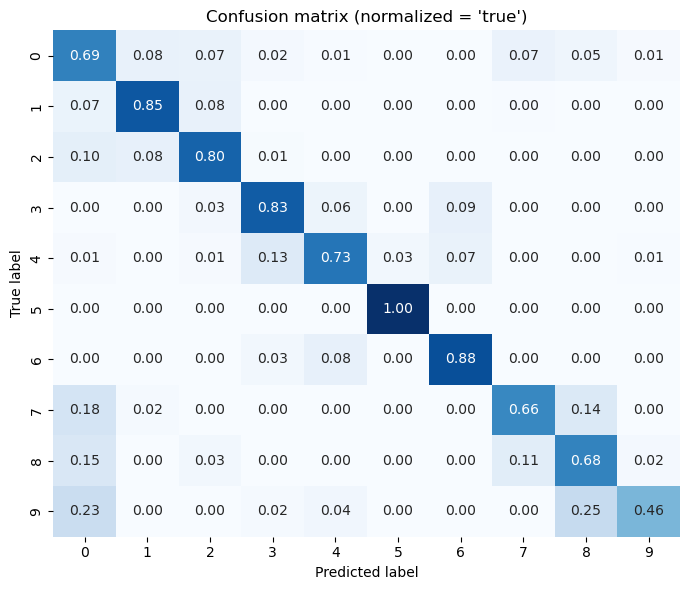

In [21]:
'''
class_names = [
    "Disk Face-on No Spiral",      # 0
    "Smooth Round",                # 1
    "Smooth In-between Round",     # 2
    "Smooth Cigar-shaped",         # 3
    "Disk Edge-on Rounded Bulge",  # 4
    "Disk Edge-on Boxy Bulge",     # 5
    "Disk Edge-on No Bulge",       # 6
    "Disk Face-on Tight Spiral",   # 7
    "Disk Face-on Medium Spiral",  # 8
    "Disk Face-on Loose Spiral",   # 9
]
'''

plot_confusion_matrix(model, resnet_test_ds, class_names=class_names, normalize="true")

#### Confusion Matrix Details

Above is the **normalized confusion matrix** (rows = true classes, columns = predicted classes). Each cell shows the proportion of samples from a given true class that were assigned to each predicted class.

- **Diagonal values** represent correct classifications (higher = better).  
- **Off-diagonals** show where the model confuses one class for another.

**Comment on Results**  
- **Strong performance** (≥ 0.80) on classes 1, 2, 6, 7 and 9, indicating these are well‐learned.  
- **Moderate accuracy** for classes 0 (0.60), 3 (0.66), 4 (0.71) and 8 (0.58); these still have room for improvement.  
- **Severe confusion** in class 5, where only 50% are correctly classified and the other 50% are mistaken for class 6 but this can be expected based on thefact that the test dataset has only 2 images for class5.  
- **Notable confusions**:  
  - Class 0 is often misclassified as 2 (0.12) and 7 (0.09).  
  - Class 3 mistakes show bleed into 2 (0.11) and 6 (0.14).  
  - Class 8 errors split between 7 (0.25) and 9 (0.05).  

These patterns highlight which class boundaries are ambiguous and where I might focus further data augmentation or fine‐tuning to improve the model’s discriminative power.  


## An alternative model: DNN

I want to see what is the difference in result when the model is a much simpler one: a DNN.

### Preprocess
This preprocess will be similar to the tf.keras.applications.resnet50.preprocess_input() function but with custom parameters (for the mean and standard deviation) and no resize. Then a PCA transformation is applied to reduce the dimensions of the flat image vector to 512. The pca model and the resulting dataset are chached due to the slow running time. I will use the raw data from the ResNet inputs (after the training split oversampling) to be more efficient. 

#### DNN Preprocessing Pipeline

1. **Compute Dataset Statistics**  
   ```python
   mean, std = compute_dataset_mean_std(resnet_balanced_train_raw)

2. **Normalize & Augment**  
   Using the computed `mean` and `std`, I build three datasets (`train`, `val`, `test`) with `preprocess_no_resize_with_stats`:
   - **Augmentation** (training only): random flip, rotation, zoom, contrast, Gaussian noise  
   - **Scaling**: cast to `float32` & divide by 255  
   - **Standardization**: `(image - mean) / std`  
   - **Shuffle** (train), **batch**, and **prefetch** for performance  

---

**Dimensionality Reduction (PCA)**  
- I thought about PCA to reduce the 69×69×3 = 14,283-dimensional image vectors down to 512 components, which:
  - Speeds up downstream training  
  - Lowers memory and compute requirements  
  - Helps prevent overfitting by discarding minor variance and by introducing less parameters to the network.
- Set up `PCA(n_components=512)` and call `pca_need_fit` to load or train it.  
- If training is required, I fit on the normalized (but unaugmented) training images.  
- Cache the trained PCA model to `pca512.joblib`.  

---

**Transform & Cache Datasets**  
For each split, call `get_or_cache_pca_dataset`, which either:  
- Loads a cached TF-record of PCA features, or  
- Flattens, transforms, shuffles, batches, and saves the PCA-reduced data.  

---

**Result**  
Three ready-to-use `tf.data.Dataset` objects (`train_pca_ds`, `val_pca_ds`, `test_pca_ds`) yielding batches of shape `(batch_size, 512)` plus labels, optimized for downstream DNN training.  



In [22]:

# 1. Compute stats on the raw (unbatched) training set:
mean, std = compute_dataset_mean_std(resnet_balanced_train_raw)
print("Dataset mean:", mean, "std:", std)

# 2. Preprocess datasets:
dnn_train_ds = preprocess_no_resize_with_stats(resnet_balanced_train_raw, mean, std, training=True, batch_size=128)
dnn_val_ds   = preprocess_no_resize_with_stats(resnet_val_ds_raw, mean, std, training=False, batch_size=128)
dnn_test_ds  = preprocess_no_resize_with_stats(resnet_test_ds_raw, mean, std, training=False, batch_size=128)

# PCA settings
dimensions = 512 # number of PCA components to keep
pca_path = "pca512_2.joblib"

# 3. PCA setup
pca = PCA(n_components=dimensions)

# 4. Check if PCA needs to be fitted on the full training set otherwise load it from the cache
need_train, ipca = pca_need_fit(path="pca512_2.joblib", force=False, pca=pca)
if need_train:
    print("Fitting PCA on full training set…")
    # 1) Unbatch, normalize, flatten, and collect into one array
    X_list = []
    for img, _ in dnn_train_ds.unbatch():
        img = tf.cast(img, tf.float32) / 255.0
        X_list.append(tf.reshape(img, [-1]).numpy())
    X_full = np.stack(X_list, axis=0)  # shape (n_samples, 14301)

    # 2) Fit PCA in one go
    pca.fit(X_full)
    joblib.dump(pca, pca_path)

# 5. read the cached datasets if it finds them or compute them:
train_pca_ds = get_or_cache_pca_dataset(
    raw_ds     = dnn_train_ds,
    pca        = ipca,
    cache_path = "DNN_PCA_cache/train_pca_ds",
    batch_size = 128,
    force      = False, 
    shuffle_cache=True
)

val_pca_ds = get_or_cache_pca_dataset(
    raw_ds     = dnn_val_ds,
    pca        = ipca,
    cache_path = "DNN_PCA_cache/val_pca_ds",
    batch_size = 128,
    force      = False,
    shuffle_cache=False
)

test_pca_ds = get_or_cache_pca_dataset(
    raw_ds     = dnn_test_ds,
    pca        = ipca,
    cache_path = "DNN_PCA_cache/test_pca_ds",
    batch_size = 128,
    force      = False,
    shuffle_cache=False
)

2025-06-25 12:41:28.486201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_67' with dtype uint8 and shape [15249,69,69,3]
	 [[{{node Placeholder/_67}}]]
2025-06-25 12:41:28.490316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_120' with dtype uint8 and shape [15249,69,69,3]
	 [[{{node Placeholder/_120}}]]


2025-06-25 12:41:38.611075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13107 of 15481
2025-06-25 12:41:48.617515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13258 of 15481
2025-06-25 12:41:53.791905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


Dataset mean: [0.10799883 0.09285855 0.07056165] std: [0.14717901 0.12287313 0.10279463]
PCA found at 'pca512_2.joblib' → loading and skipping training.
Loading PCA-features from 'DNN_PCA_cache/train_pca_ds'
Loading PCA-features from 'DNN_PCA_cache/val_pca_ds'
Loading PCA-features from 'DNN_PCA_cache/test_pca_ds'


#### A parenthesis: Explained Variance in PCA

In Principal Component Analysis (PCA), each principal component (PC) corresponds to an eigenvector of the data’s covariance matrix, with an associated eigenvalue $$\lambda_k$$. The **explained variance ratio** for the k-th PC is

$$
\mathrm{EV}_k = \frac{\lambda_k}{\sum_j \lambda_j}
$$

—that is, the fraction of the total dataset variance captured by that component.

**Cumulative explained variance** up to the first K components is

$$
\sum_{k=1}^K \mathrm{EV}_k
$$


---

It is used to decide how many PCs to keep. For example:

- First 10 PCs capture 85% of the variance → compress from 14 307 dimensions down to 10.  
- First 50 PCs capture 98% of the variance → 50 dimensions suffice to preserve almost all structure.


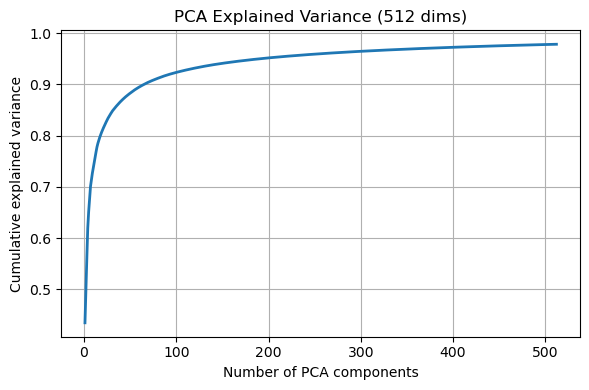

In [23]:
# 1) Cumulative explained variance
evr = ipca.explained_variance_ratio_
cum_evr = np.cumsum(evr)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(evr)+1), cum_evr, lw=2)
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance (512 dims)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Corner plot of the first dimensions 

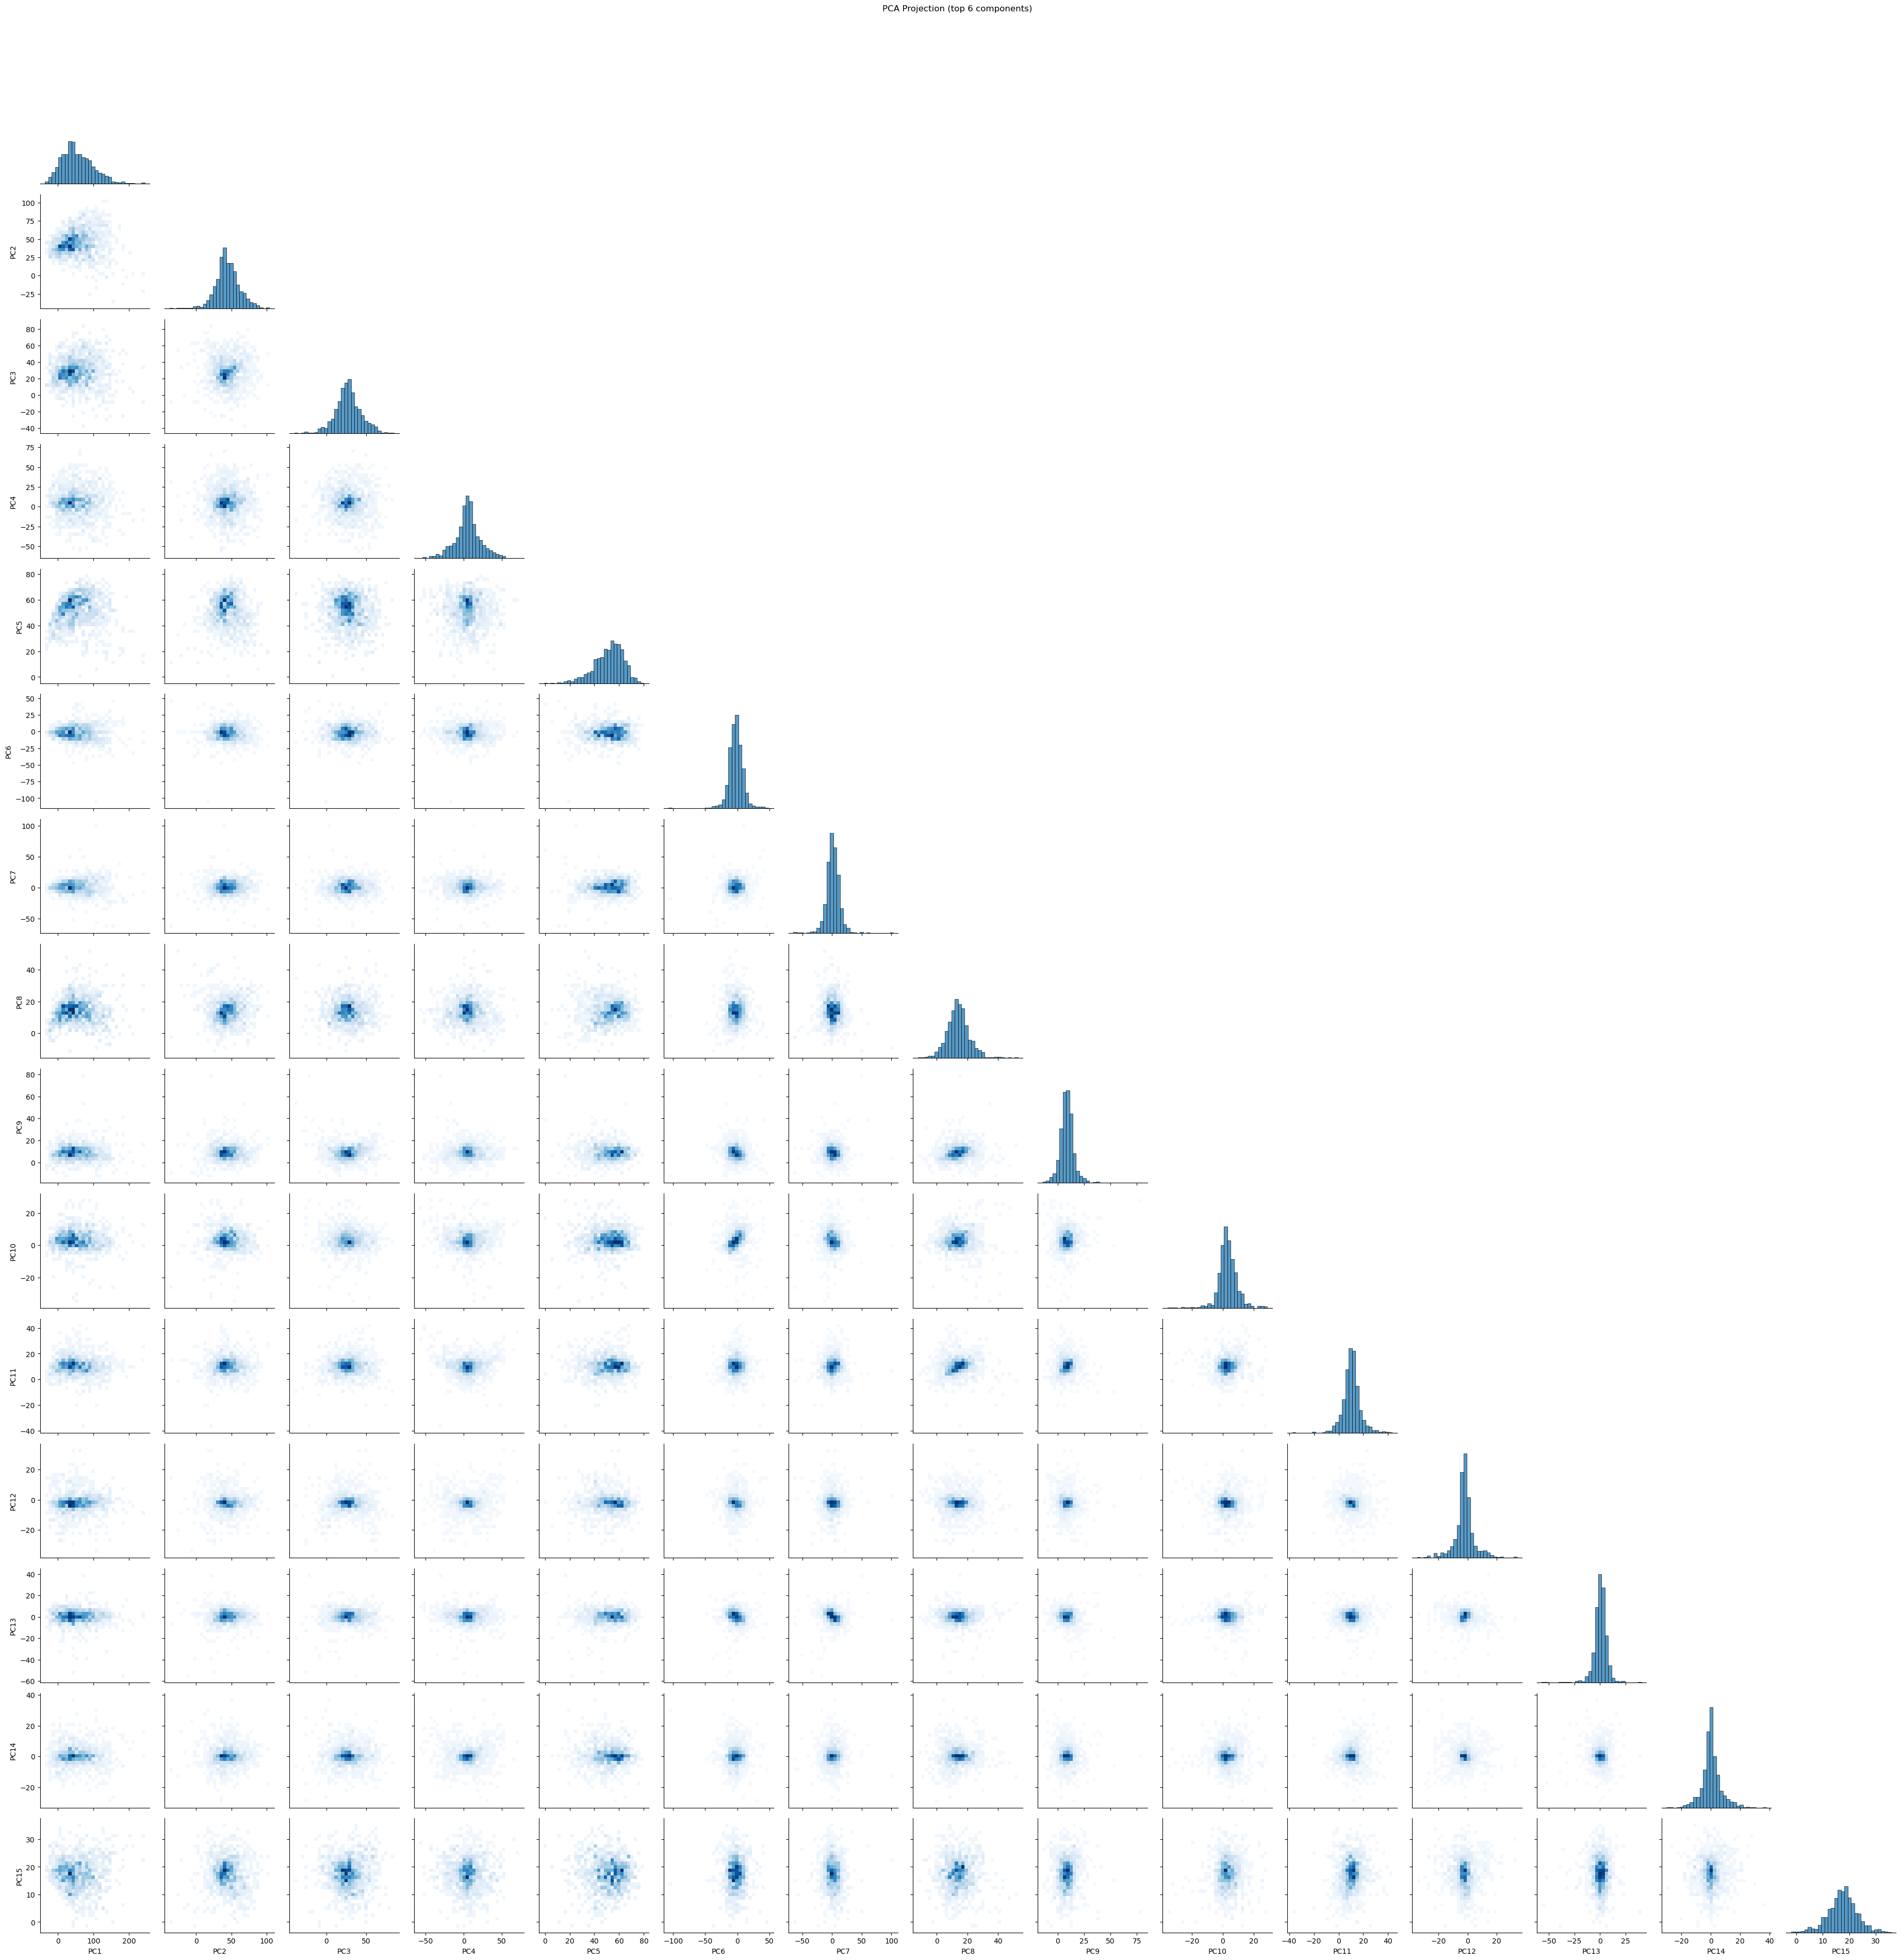

In [24]:
# Number of dimensions to visualize
n_dims = 15

# 1) Build DataFrames for before (raw embeddings) and after (PCA)
cols_after  = [f"PC{i+1}" for i in range(n_dims)]

# collect PCA-transformed training data
parts = []
for features, _ in train_pca_ds:
    parts.append(features.numpy())
pca_data = np.concatenate(parts, axis=0)

df_after = pd.DataFrame(pca_data[:, :n_dims], columns=cols_after)

# 3) Corner plot for PCA components
g2 = sns.PairGrid(df_after.sample(1000), corner=True)
g2.map_diag(sns.histplot, bins=30, log_scale=False)
g2.map_lower(sns.histplot, bins=30, cmap="Blues")
plt.suptitle("PCA Projection (top 6 components)", y=1.02)
plt.show()

### Building the DNN and training

#### Callbacks

In [25]:
# 1) Checkpoint: save only the best weights
checkpoint_cb_dnn = ModelCheckpoint(
    "best_DNN_weights.h5",  # filepath
    monitor="val_accuracy",       # or "val_loss" / "val_macro_f1"
    save_best_only=True,
    save_weights_only=True,       # only weights; change to False to save entire model
    mode="max",                   # because higher accuracy is better
    verbose=1,
)

# 2) Early stopping to avoid overtraining
earlystop_cb_dnn = EarlyStopping(
    monitor="val_accuracy",
    patience=20,       # stop if no improvement in 3 epochs
    restore_best_weights=True,  # roll back to best at end of training
    verbose=1,
    mode="max",
)

# 3) Create ReduceLROnPlateau
reduce_lr_cb_dnn = ReduceLROnPlateau(
    monitor="val_accuracy",    # what to monitor
    factor=0.5,            # reduce LR by this factor
    patience=6,            # wait this many epochs before reducing
    min_lr=1e-6,           # lower bound on LR
    verbose=1
)

In [26]:
# 2) build the DNN model 
dnn_model = build_dnn_classifier(
    input_dim=dimensions,  # PCA dimensions
    num_classes=NUM_CLASSES,
    hidden_units=[350, 256, 128, 64],
    dropout_rate=0.3,
    weight_decay=1e-4,
    learning_rate=3e-4
)

# always the same logic, if the model weights are not present or need to be retrained, then train the model
# if given a path to a full model, it will load the model from that path
dnn_model, DNN_needs_training = need_training(dnn_model, "best_DNN_weights.h5", force_retrain=False)
# 3) fit
if DNN_needs_training:
    with tf.device(get_training_device()):
        history_dnn = dnn_model.fit(train_pca_ds,
                                validation_data=val_pca_ds,
                                epochs=100,
                                callbacks=[checkpoint_cb_dnn, earlystop_cb_dnn, reduce_lr_cb_dnn],
        )

 Weights found at 'best_DNN_weights.h5' → loading and skipping training.


### ROC

1/1 [==============================] - 0s 181ms/step


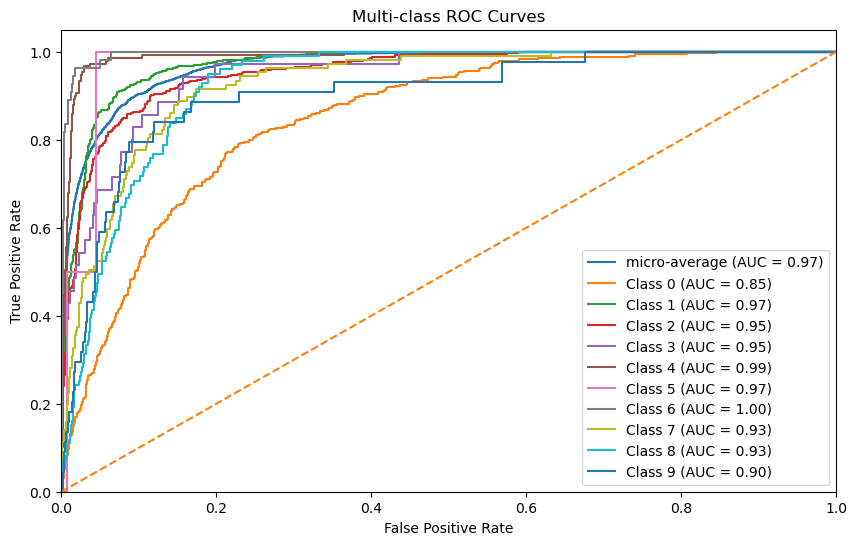

In [27]:
plot_dnn_roc(dnn_model, test_pca_ds, num_classes=10)

#### ROC result discussion
The AUC results are similar to the ResNet values but we will see from the confusion matrix that the classification is a bit worse. 

### Confusion matrix

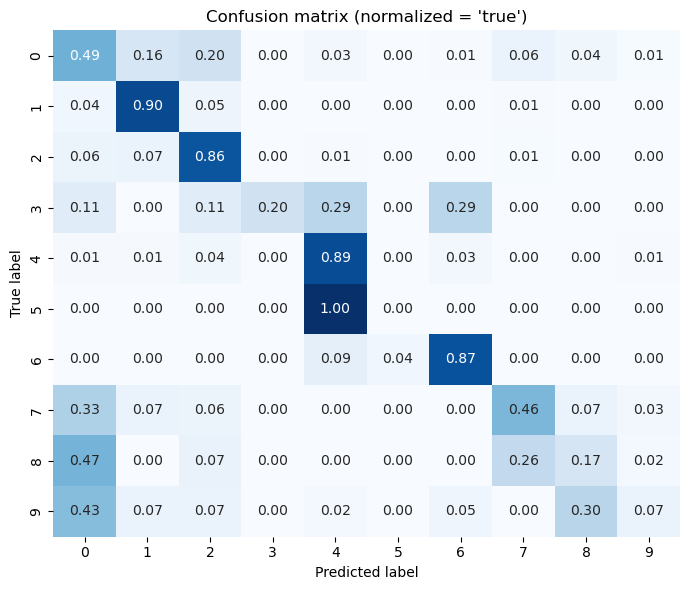

In [28]:
plot_confusion_matrix(
    dnn_model,
    test_pca_ds,
    normalize="true" 
)

#### Confusion matrix results

As you can see from this confusion matrix a lot of the images from the last three classes are classified as Class 0 galaxies. I now don't have a reason for this. The classification performance is pretty good on classes 1, 2, 4, 6. Class 5 has always the same problem of being under-rappresented so there isn't a good enogh satistic. The perfrmance on classes 3, 8, 9 is pretty bad while on classes 0, 7 is almost random (near 0.5).

## Comparison between the models:
I want to compare the two model by comparing some simple metrics. I'll start by writing a table with some of the most meaningfull metrics to compare the results:


### Extracting the results

In [29]:
# ─── 1) True labels ────────────────────────────────────────────────────────────
# ResNet test set (images)
y_true_resnet = np.concatenate([y.numpy() for _, y in resnet_test_ds])

# DNN test set (PCA features)
y_true_dnn    = np.concatenate([y.numpy() for _, y in test_pca_ds])

# ─── 2) Predictions ─────────────────────────────────────────────────────────────
proba_resnet   = model.predict(resnet_test_ds, verbose=0)
y_pred_resnet  = proba_resnet.argmax(axis=1)

proba_dnn      = dnn_model.predict(test_pca_ds, verbose=0)
y_pred_dnn     = proba_dnn.argmax(axis=1)

### Comparison Metrics

To compare the ResNet and DNN classifiers on equal footing, I compute the following metrics:

| Metric                | Definition & Purpose                                                                                                       |
|-----------------------|-----------------------------------------------------------------------------------------------------------------------------|
| **Accuracy**          | muber of correct predictions / total samples. Gives an overall sense of performance but can be misleading if classes are imbalanced. |
| **ROC AUC (macro)**   | Area under the ROC curve, averaged **unweighted** across all classes (one-vs-rest). Measures the model’s ability to discriminate positive vs. negative examples for each class, then averages those abilities equally. |
| **Precision (macro)** | For each class: TP / (TP + FP). Averaged across classes. Indicates how many of the predicted positives were actually correct. High precision means few false positives. |
| **Recall (macro)**    | For each class: TP / (TP + FN). Averaged across classes. Indicates how many of the actual positives the model recovered. High recall means few false negatives. |
| **F1 (macro)**        | Harmonic mean of precision and recall, computed per class then averaged. Balances precision vs. recall and is useful when you care equally about both. |

**Why these metrics?**
- **Macro-averaging** treats each class equally, which is critical under class imbalance (so small classes aren’t drowned out by large ones).  
- **ROC AUC** (macro) evaluates discrimination performance independently of any threshold.  
- **Precision**, **Recall**, and **F1** (macro) give a nuanced view of type-I vs. type-II errors on a per-class basis, then summarize across all classes.  
- **Accuracy** provides a familiar baseline but is complemented by the above to reveal more granular strengths and weaknesses.  

Together, these metrics give a comprehensive picture of overall correctness (accuracy), threshold-agnostic separability (ROC AUC), and detailed error trade-offs (precision, recall, F1) for each model.  


In [30]:
# ─── 3) Summary metrics table ──────────────────────────────────────────────────
rows = []
for name, y_true, y_pred, proba in [
    ("ResNet", y_true_resnet,  y_pred_resnet,  proba_resnet),
    ("DNN",    y_true_dnn,     y_pred_dnn,     proba_dnn),
]:
    # one‐hot for ROC
    onehot = label_binarize(y_true, classes=range(len(class_names)))
    acc    = accuracy_score(y_true, y_pred)
    roc    = roc_auc_score(onehot, proba, average="macro", multi_class="ovr")
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )
    rows.append([name, acc, roc, prec, rec, f1])

df = pd.DataFrame(
    rows,
    columns=[
        "Model", "Accuracy", "ROC AUC (macro)",
        "Precision (macro)", "Recall (macro)", "F1 (macro)"
    ]
)
display(df)

,Model,Accuracy,ROC AUC (macro),Precision (macro),Recall (macro),F1 (macro)
0,ResNet,0.778339,0.975515,0.672120,0.759216,0.684137
1,DNN,0.738751,0.943670,0.570774,0.491404,0.495359


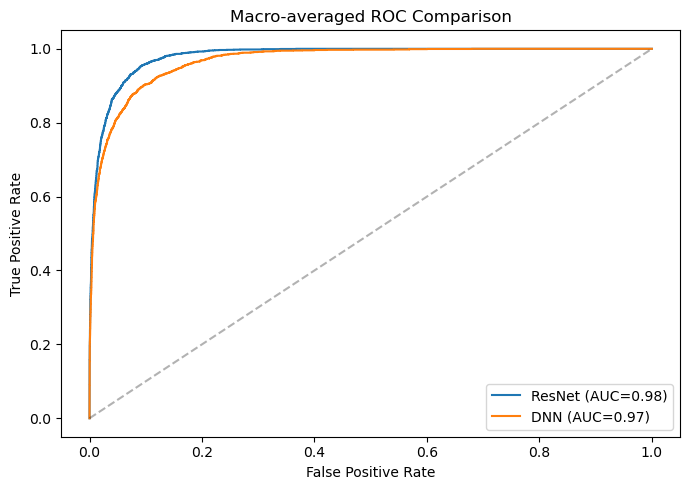

In [31]:
# ─── 4) Overlaid ROC curves ────────────────────────────────────────────────────
plt.figure(figsize=(7,5))
for name, y_true, proba in [
    ("ResNet", y_true_resnet, proba_resnet),
    ("DNN",    y_true_dnn,    proba_dnn)
]:
    onehot = label_binarize(y_true, classes=range(len(class_names)))
    fpr, tpr, _ = roc_curve(onehot.ravel(), proba.ravel())
    val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={val:.2f})")

plt.plot([0,1],[0,1],"k--", alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro‐averaged ROC Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



You’ll notice the table reported **macro-avg AUC = 0.9203** for the DNN, but in the ROC plot the DNN curve shows **AUC ≈ 0.97**. This is a consequence of how “macro-average” ROC/AUC can be computed in two different ways:

1. **Table AUC (`roc_auc_score(..., average='macro')`)**  
   - Calculates one ROC AUC for *each* class (treating it as a one-vs-rest problem), then takes the *unweighted mean* of those 10 numbers.  
   - Classes with very few samples (e.g. underrepresented ones) pull this average down more heavily.

2. **Plotted Macro-Avg Curve**  
   - First *interpolates* and *averages* the TPR values at a common set of FPR thresholds across all classes.  
   - Then computes the area under *that* averaged curve.  
   - Mathematically this yields a single ROC curve whose AUC is generally *higher* than the arithmetic mean of per-class AUCs.

In both cases this are good values but as we have previously seen and as we will see, the confusion matric tells us a different story


### UMAP plot 

/teo_fs_fast/software/miniforge/envs/acosso_tf2_12/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/teo_fs_fast/software/miniforge/envs/acosso_tf2_12/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


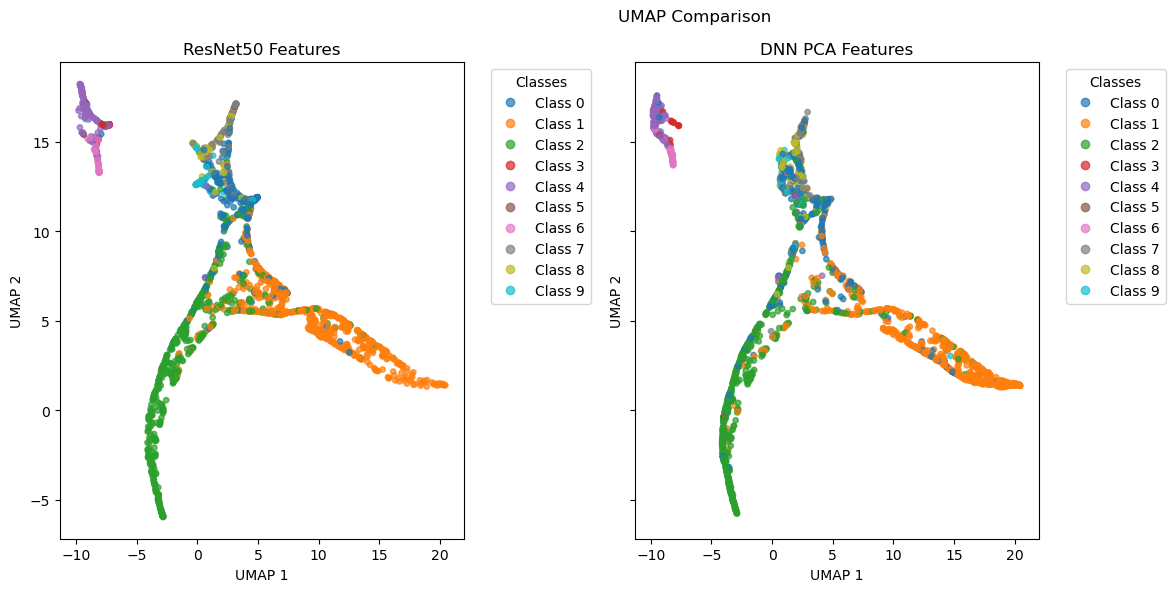

In [32]:
plot_umap_classifier_comparison(proba_resnet, y_true_resnet,
                     proba_dnn, y_true_dnn,
                     class_names=[f"Class {i}" for i in range(10)],
                     n_neighbors=100, min_dist=0.1,
                     title1='ResNet50 Features',
                     title2='DNN PCA Features')

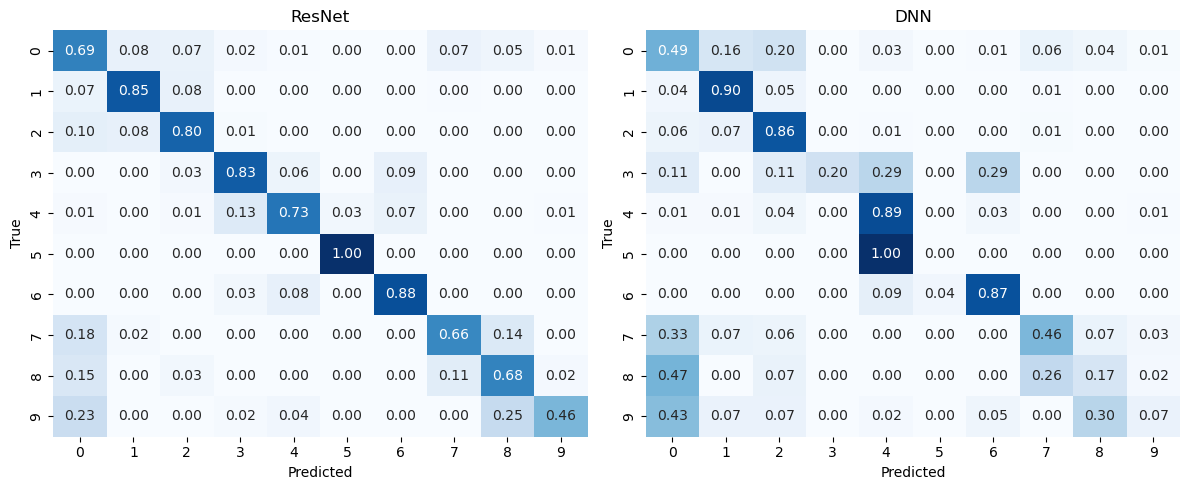

In [33]:
# ─── 5) Side‐by‐side confusion matrices ────────────────────────────────────────
cm_r = confusion_matrix(y_true_resnet, y_pred_resnet, normalize="true")
cm_d = confusion_matrix(y_true_dnn,    y_pred_dnn,    normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
for ax, cm, title in zip([ax1, ax2], [cm_r, cm_d], ["ResNet", "DNN"]):
    sns.heatmap(
        cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax,
        xticklabels=class_names, yticklabels=class_names
    )
    ax.set(title=title, xlabel="Predicted", ylabel="True")

plt.tight_layout()
plt.show()


### Confusion matrix and conlcusions: 
As you can see in this plot side by side of the two confusion matrix the ResNet has better precision overall (more concetrated diagonal) but the DNN has some advantages on specific classes (1,2,4,6), with some big confusions on others (7, 8, 9). You can also notice some common patterns, like the diffircluties in the classification between the first three classes (both the confusion matrix have a light blue square in the first three rows and columns), both classifiers tend to classify as class 0 the last three classes (DNN much worst in this case) and same difficulties in class 3,4,5,6 being classified as class 6 for the first two and class 4 for the last two.  
**What could i have done better to maximize the results from the ResNet?**
1. Class imabalance
    - Better handling of the big class imbalances, by combining oversampling for the smaller classes and undersampling for the bigger ones.
    - Generation of new images by using syntetic data generation (like with normalising flows)
2. Deeper fine-tuning
    - Unfreezing deeper ResNet blocks 
    - Discriminative learning rates: lower for deeper blocks higher for the last blocks
3. Implement some class aware augmentation to help the network get more robust on underperforming classes.

In [34]:
K.clear_session()  # Clear the Keras session to free up resources

# Anomaly detection

The main anomaly detector is build with pre-trained ResNet50 to extract a feature vector to be fed to a MAF. I will compare them with a simple GMM,a RealNVP and a VAE. Notice that given the label dataset i choose to approach the anomaly detection task with a semi-supervised aproach, making the unsupervised networks only see the "normal" class while holding all anomalies out for testing. This simplifies the work of the networks. I could have followed a truly unsupervised aproach by mixing the normal class with some anomalies and training the networks with it.

## File reading

This dataset reader, by default, takes the first three class (by number of images and also in order in the specific case) and builds the train, test and validation datasets. Given the parameter n_anomalies, takes n_per_class = int(np.ceil(n_anomalies / len(anomaly_classes))) images per class. As you can understand the classes from which to take the images can by set with the kwarg anomaly_classes, if None takes the last three classes. To avoid caching the dataset, the data‐loading function always splits it the same way using a stratified strategy with a fixed seed.

### Load and Prepare Anomaly Detection Datasets

I use a custom `get_stratified_anomaly_datasets` function to split the galaxies into “normal” and “anomaly” sets and to build train/val/test splits:

#### Normal vs. Anomaly

- I designate classes `(0, 1, 2)` as **normal** (inliers) during training.  
- If `anomaly_classes=None`, the last three classes (by index) become **anomalies** (outliers).

#### Anomaly Sampling

- `n_anomalies=800` means I draw `ceil(800 / len(anomaly_classes))` examples **per anomaly class**, ensuring equal representation.

#### Splitting

- The function stratifies the **normal** classes into training, validation (20%), and test (5%) sets.  
- All sampled anomalies go into a separate anomaly test set (`anomaly_ds_raw`).

---

So i get:

- **`train_ds_raw`, `val_ds_raw`, `test_ds_raw`** — only normal samples, for training and validation of the networks.  
- **`anomaly_ds_raw`** — outlier samples used exclusively for evaluating detection performance.  


Reading file and creating datasets

In [35]:
# ------- 1. Load and prepare anomaly datasets -------
train_ds_raw, val_ds_raw, test_ds_raw, anomaly_ds_raw, class_weights, \
        class_counts_train, class_counts_full, anomaly_counts_test = get_stratified_anomaly_datasets("Galaxy10.h5",
                         normal_classes=(0,1,2),
                         anomaly_classes=None, # last 3 classes by default
                         n_anomalies=800, # total across all anomaly classes, equally distributed
                         val_split = 0.2,
                         test_split= 0.05)
print("Train class counts:", class_counts_train) 

Train class counts: {0: 2596, 1: 5247, 2: 4719}


## Oversampling and preprocessing
The preprocess is the same I've have done for the classifier's ResNet, reshape of the images, scale and standardization of each pixel. If trainig = True it also add some data augmenation (flips, rotation, noise, zoom)

In [36]:
# ------- 2. Apply oversampling for normal classes -------
balanced_train_raw = oversample_dataset(train_ds_raw, class_counts_train)

# ------- 3. Preprocess datasets for ResNet50 -------
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

fm_train_ds = preprocess(balanced_train_raw, training=True,
                      batch_size=BATCH_SIZE, target_size=TARGET_SIZE)
fm_val_ds = preprocess(val_ds_raw, training=False,
                    batch_size=BATCH_SIZE, target_size=TARGET_SIZE)
fm_test_ds = preprocess(test_ds_raw, training=False,
                     batch_size=BATCH_SIZE, target_size=TARGET_SIZE)
fm_anomaly_ds = preprocess(anomaly_ds_raw, training=False,
                         batch_size=BATCH_SIZE, target_size=TARGET_SIZE)


## Feature model callbacks

In [37]:
# Instantiate callbacks with new filenames
checkpoint_cb_fe = ModelCheckpoint(
    "best_feature_resnet_weight.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
earlystop_cb_fe = EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb_fe = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

## Building the feature model

Build a ResNet50-based head that learns to classify the **3 "normal" galaxies classes** to extract as many information as possible from the 32-dim feature vector i will get from the net.
- **Backbone**: pretrained ResNet50 (frozen), with optional block unfreezing.

- **Head**:  
  - Global average pooling  
  - Dropout  
  - `feature_32` Dense layer (softmax) → 32-dim vector  
  - `logits` Dense layer (softmax) → 3-class output  

- **Compile**: Adam + sparse categorical crossentropy, tracking macro F1 & accuracy.

After training, I’ll extract the 32-dim `feature_32` output for the models. 


In [38]:
# ------- 5. Build and train head-only phase -------
feature_model = build_feature_model(
    feature_dim=32,
    dropout_rate=0.1,
    learning_rate=1e-3,
    trainable_backbone=False,  # freeze backbone first
    num_classes=3,
    metrics=[macro_f1, "accuracy"]
)

## Training the feature model's head

I will follow the same procedure done for the classifier to train this feature ResNet so i will freeze the backbone and train only the heand and then unfreeze the last block of the ResNet to fine tune everything toghether.

This is the call to the function that loads the model weights if present or return True to let the training process start.

In [39]:
feature_model, need_train_feature = need_training(feature_model, "best_feature_resnet_weight.h5", force_retrain=False)

 Weights found at 'best_feature_resnet_weight.h5' → loading and skipping training.


Training

In [40]:
if need_train_feature:
    history_head = feature_model.fit(
        fm_train_ds,
        validation_data=fm_val_ds,
        epochs=20,
        class_weight=class_weights,
        callbacks=[checkpoint_cb_fe, earlystop_cb_fe, reduce_lr_cb_fe]
    )

## Fine tuning the last feature resnet block
As i mentioned before.

In [41]:
# ------- 6. Fine-tune last ResNet block -------
if need_train_feature: 
    for layer in feature_model.layers:
        if layer.name.startswith("conv5_block3"):
            layer.trainable = True
    
    feature_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=[macro_f1, "accuracy"]
    )
    history_ft = feature_model.fit(
        fm_train_ds,
        validation_data=fm_val_ds,
        epochs=16,
        class_weight=class_weights,
        callbacks=[checkpoint_cb_fe, earlystop_cb_fe, reduce_lr_cb_fe]
    )

## Confusion matrix

In [42]:
loss, f1, acc = feature_model.evaluate(fm_test_ds, verbose=0)
print(f"Test accuracy: {acc:.3f}, macro-F1: {f1:.3f}")


2025-06-25 12:43:45.732382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [838]
	 [[{{node Placeholder/_1}}]]
2025-06-25 12:43:45.732760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [838]
	 [[{{node Placeholder/_1}}]]


Test accuracy: 0.804, macro-F1: 0.239


In [43]:
from collections import Counter
print(Counter(np.concatenate([y.numpy() for _,y in fm_test_ds])))


Counter({1: 350, 2: 315, 0: 173})


2025-06-25 12:43:49.372297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [838]
	 [[{{node Placeholder/_1}}]]
2025-06-25 12:43:49.372897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [838]
	 [[{{node Placeholder/_1}}]]


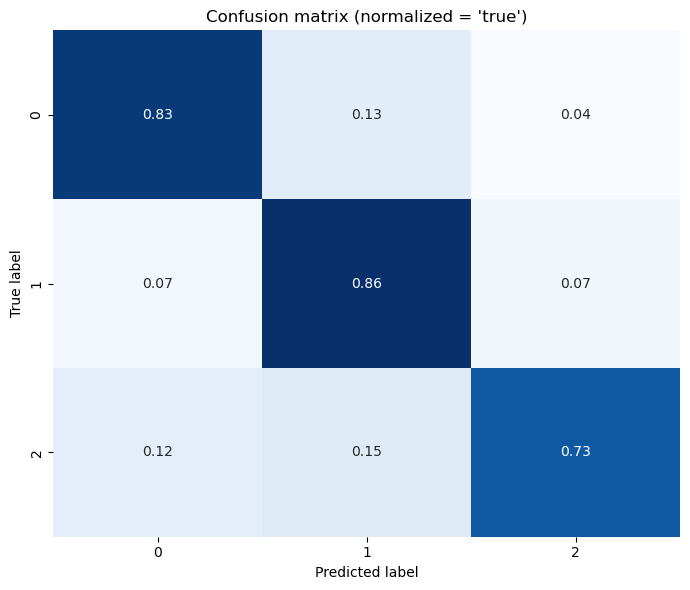

In [44]:
plot_confusion_matrix(feature_model,fm_test_ds)

as you can see from the confusion matrix the model is pretty good at distinguish between the last two classes and a bit less god in the first class (class 0). Again, we could obtain better results by refining hyperparameters and giving some fine tuning to the model unfreeze. 

## Extracting feature model build
This builds a separate model that points at the model we just trained, it passes the data through the same graph, so with same weights.

In [45]:
# ------- 7. Extract 32-D feature extractor -------
feature_extractor = tf.keras.Model(
    inputs=feature_model.input,
    outputs=feature_model.get_layer("feature_32").output
)
#feature_extractor.summary()


## Embedding (feature vector) extraction:
In this case i will cache the data to be shure to always use the same data. The `need_anom_datasets` function will check if the data is available and loads it, otherwise it returns `recompute = True` and all the other variables as `None`. 

In [46]:
anom_cache_dir = "anom_cache"
recompute, embeddings_train, embeddings_val, embeddings_test, embeddings_anom, \
ds_train, ds_val, ds_test, ds_anom = need_anom_datasets(cache_dir=anom_cache_dir, force_recompute=False, batch_size=128)

Loaded embeddings from 'anom_cache'
Loaded datasets   from 'anom_cache'


In [47]:
# ── extract embeddings for both normal and anomaly sets only if not loaded ──
batch_size = 128
if recompute:
    #preprocess function for the ResNet50 input 
    train_embed_ds = preprocess(
        train_ds_raw, training=False,
        batch_size=batch_size, target_size=TARGET_SIZE
    )
    #evaluating the feature extractor
    embeddings_train = feature_extractor.predict(train_embed_ds)

    # Anomaly embeddings (same preprocessing, no labels needed)
    anom_embed_ds = preprocess(
        anomaly_ds_raw, training=False,
        batch_size=batch_size, target_size=TARGET_SIZE
    )
    embeddings_anom = feature_extractor.predict(anom_embed_ds)

    # Test embeddings (same preprocessing, no labels needed)
    test_embed_ds = preprocess(
        test_ds_raw, training=False,
        batch_size=batch_size, target_size=TARGET_SIZE
    )
    embeddings_test = feature_extractor.predict(test_embed_ds)

    # Validation embeddings (same preprocessing, no labels needed)
    val_embed_ds = preprocess(
        val_ds_raw, training=False,
        batch_size=batch_size, target_size=TARGET_SIZE
    )
    embeddings_val = feature_extractor.predict(val_embed_ds)

    cache_dir = anom_cache_dir + "/embeddings"
    save_anom_cache(cache_dir=cache_dir,
                    embs_train=embeddings_train,
                    embs_val=  embeddings_val,
                    embs_test= embeddings_test,
                    embs_anom= embeddings_anom
                    )

## Normalising flows preprocessing

### Visualize raw data
Plotting the raw data to choose the tranformation.

In [48]:
def plot_embeddings(embeddings, title="Embeddings", figsize=(12, 8)):
    # 2) Plot histograms for each of the 32 dimensions
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(24, 18))
    for i, ax in enumerate(axes.flatten()):
        ax.hist(embeddings[:, i], bins=14)
        ax.set_title(f"Dimension {i}")
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_yscale('log') 

    plt.tight_layout()
    plt.show()

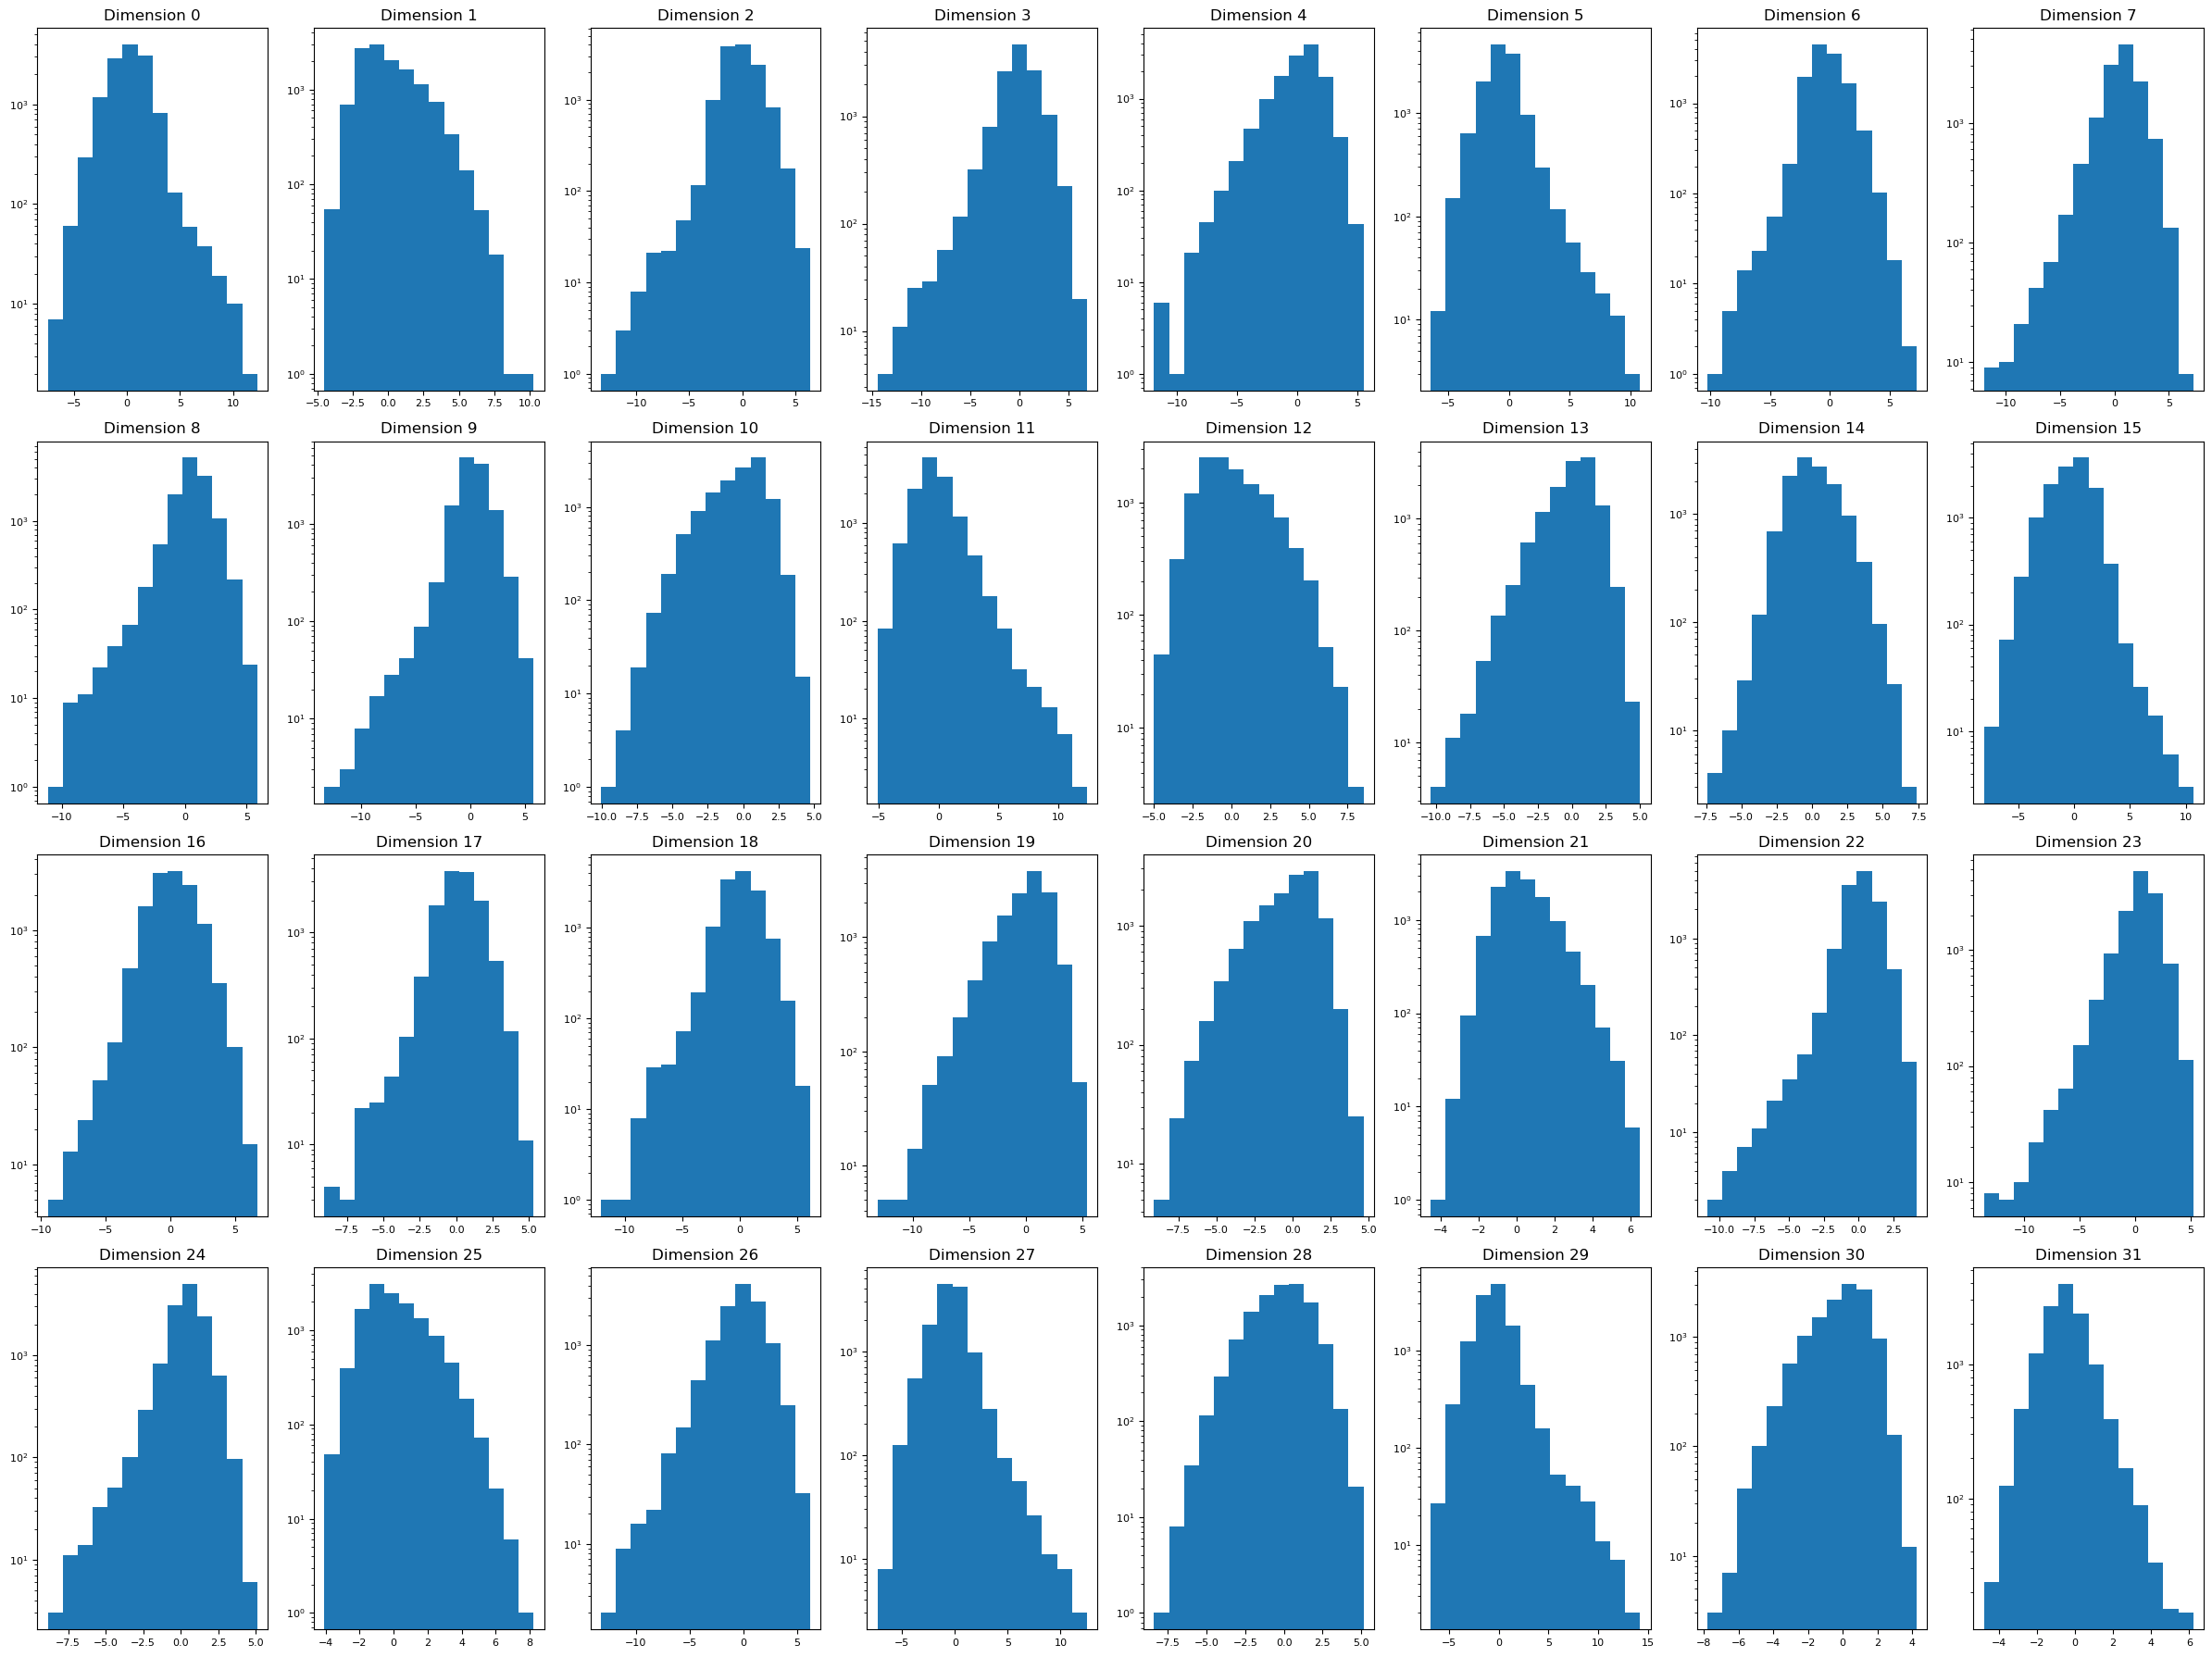

In [49]:
plot_embeddings(embeddings_train, title="Train Embeddings")

As you can see from the plot above, the distributuion of the marginals is pretty "well" shaped. The only problem i see with this is that the distribution of some marginals span big ranges of values: dimension 31 has roughly domain in [-4,6] while dimension 3 has domain in [-15,5]. This can cause some instabilities and some difficulties in the learning process of the normalising flow.

### The choosen transformation

**PCA on Feature Embeddings:**  removes any correaltion between the marginals leaving a more gaussian-like marginals. 

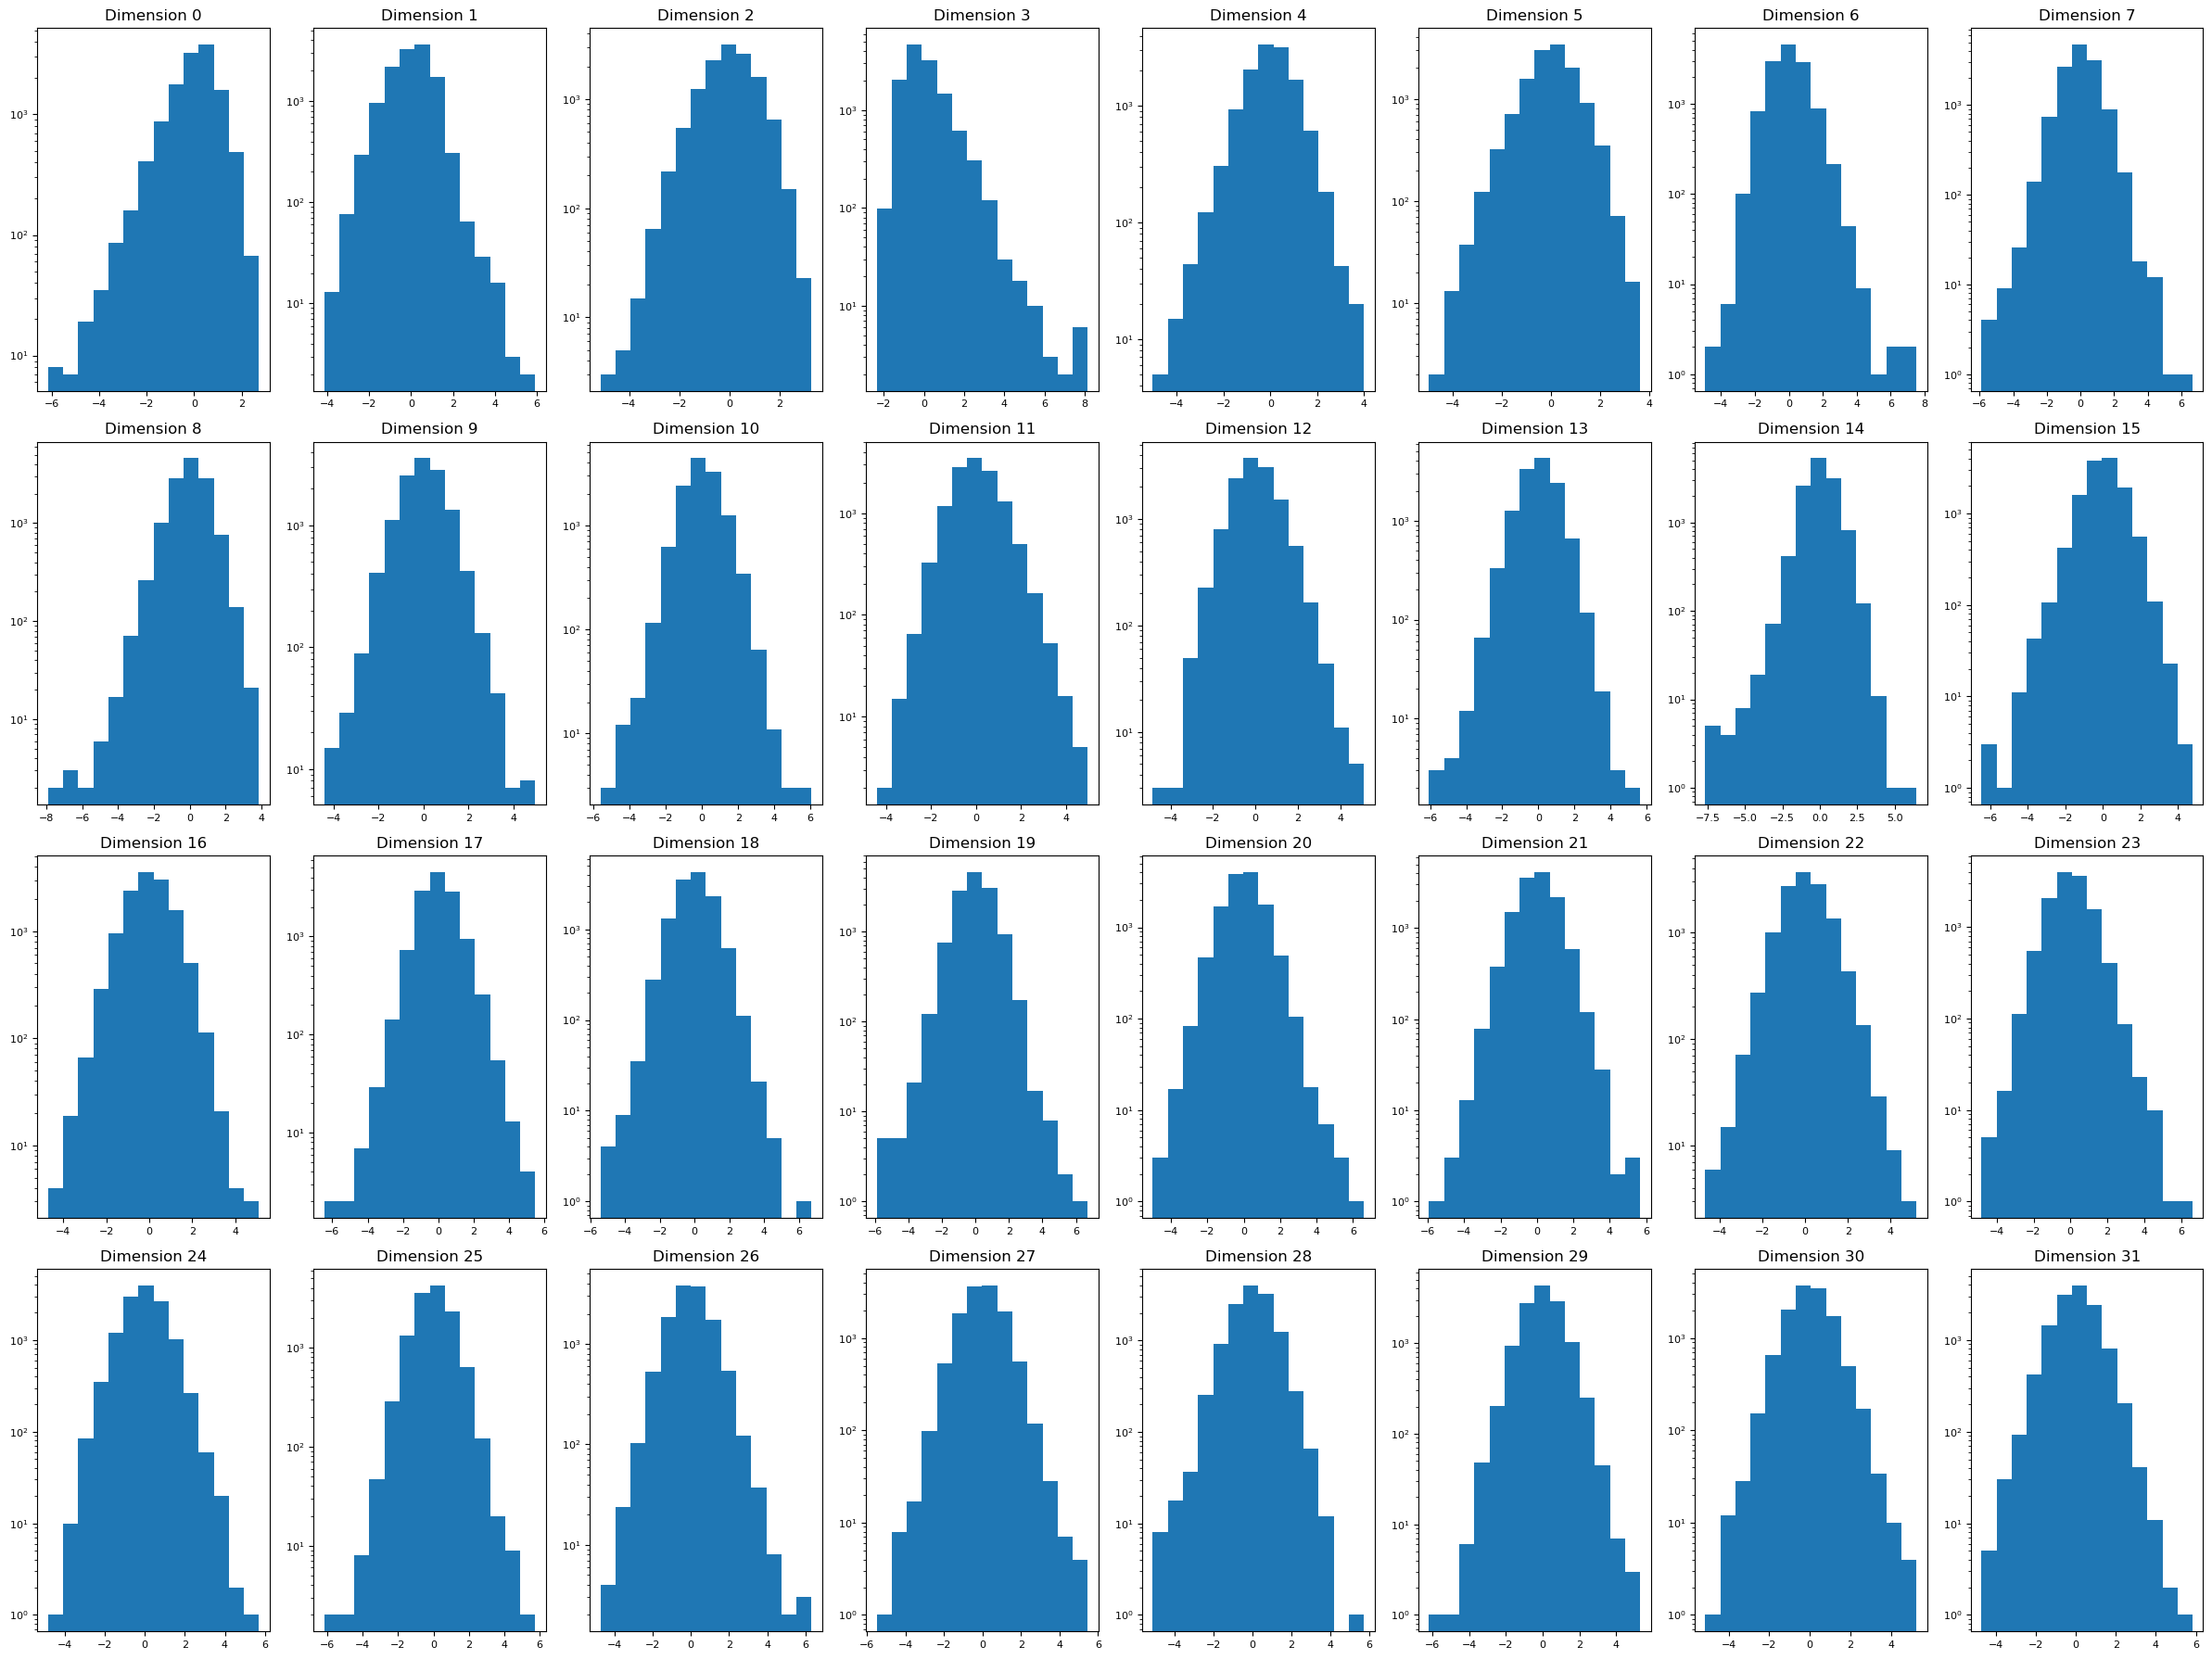

In [50]:
plot_check = True
if recompute:
    # ─── 1) Build tf.data.Datasets (features only) ──────────────────────────────────
    pca = PCA(n_components=32, whiten=False, random_state=SEED)
    Z_train = pca.fit_transform(embeddings_train)
    Z_val   = pca.transform(embeddings_val)
    Z_test  = pca.transform(embeddings_test)
    Z_anom  = pca.transform(embeddings_anom)

    scaler   = StandardScaler().fit(Z_train)   # ← NEW
    Z_train  = scaler.transform(Z_train)
    Z_val    = scaler.transform(Z_val)
    Z_test   = scaler.transform(Z_test)
    Z_anom   = scaler.transform(Z_anom)


    # Build tf.data.Datasets from the embeddings
    ds_train = (
        tf.data.Dataset
        .from_tensor_slices(Z_train.astype(np.float32))
        .shuffle(buffer_size=embeddings_train.shape[0])
        .batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )

    ds_val = (
        tf.data.Dataset
        .from_tensor_slices(Z_val.astype(np.float32))
        .batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )

    ds_test = (
        tf.data.Dataset
        .from_tensor_slices(Z_test.astype(np.float32))
        .batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )

    ds_anom = (
        tf.data.Dataset
        .from_tensor_slices(Z_anom.astype(np.float32))
        .batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )

    # ─── 2) Save datasets to disk ─────────────────────────────────────────────────
    save_anom_cache(cache_dir=anom_cache_dir,
                    ds_train=ds_train,
                    ds_val=  ds_val,
                    ds_test= ds_test,
                    ds_anom= ds_anom
                    )

    # plotting the transformed embeddings
    plot_embeddings(Z_train, title="Train Embeddings")
    plot_check = False

if plot_check:
    ds_to_np = np.concatenate(list(ds_train.as_numpy_iterator()), axis=0)
    plot_embeddings(ds_to_np)  

#### Corner plots:
To visualize the effect of a PCA transformation on the data, below you can find a small corner plot with the first dimensions. As you can see it effectively removes the correlation. To be short i reported only the first 6 feature dimensions but you can modify the `n_feat` variable to get more feature dimensions.

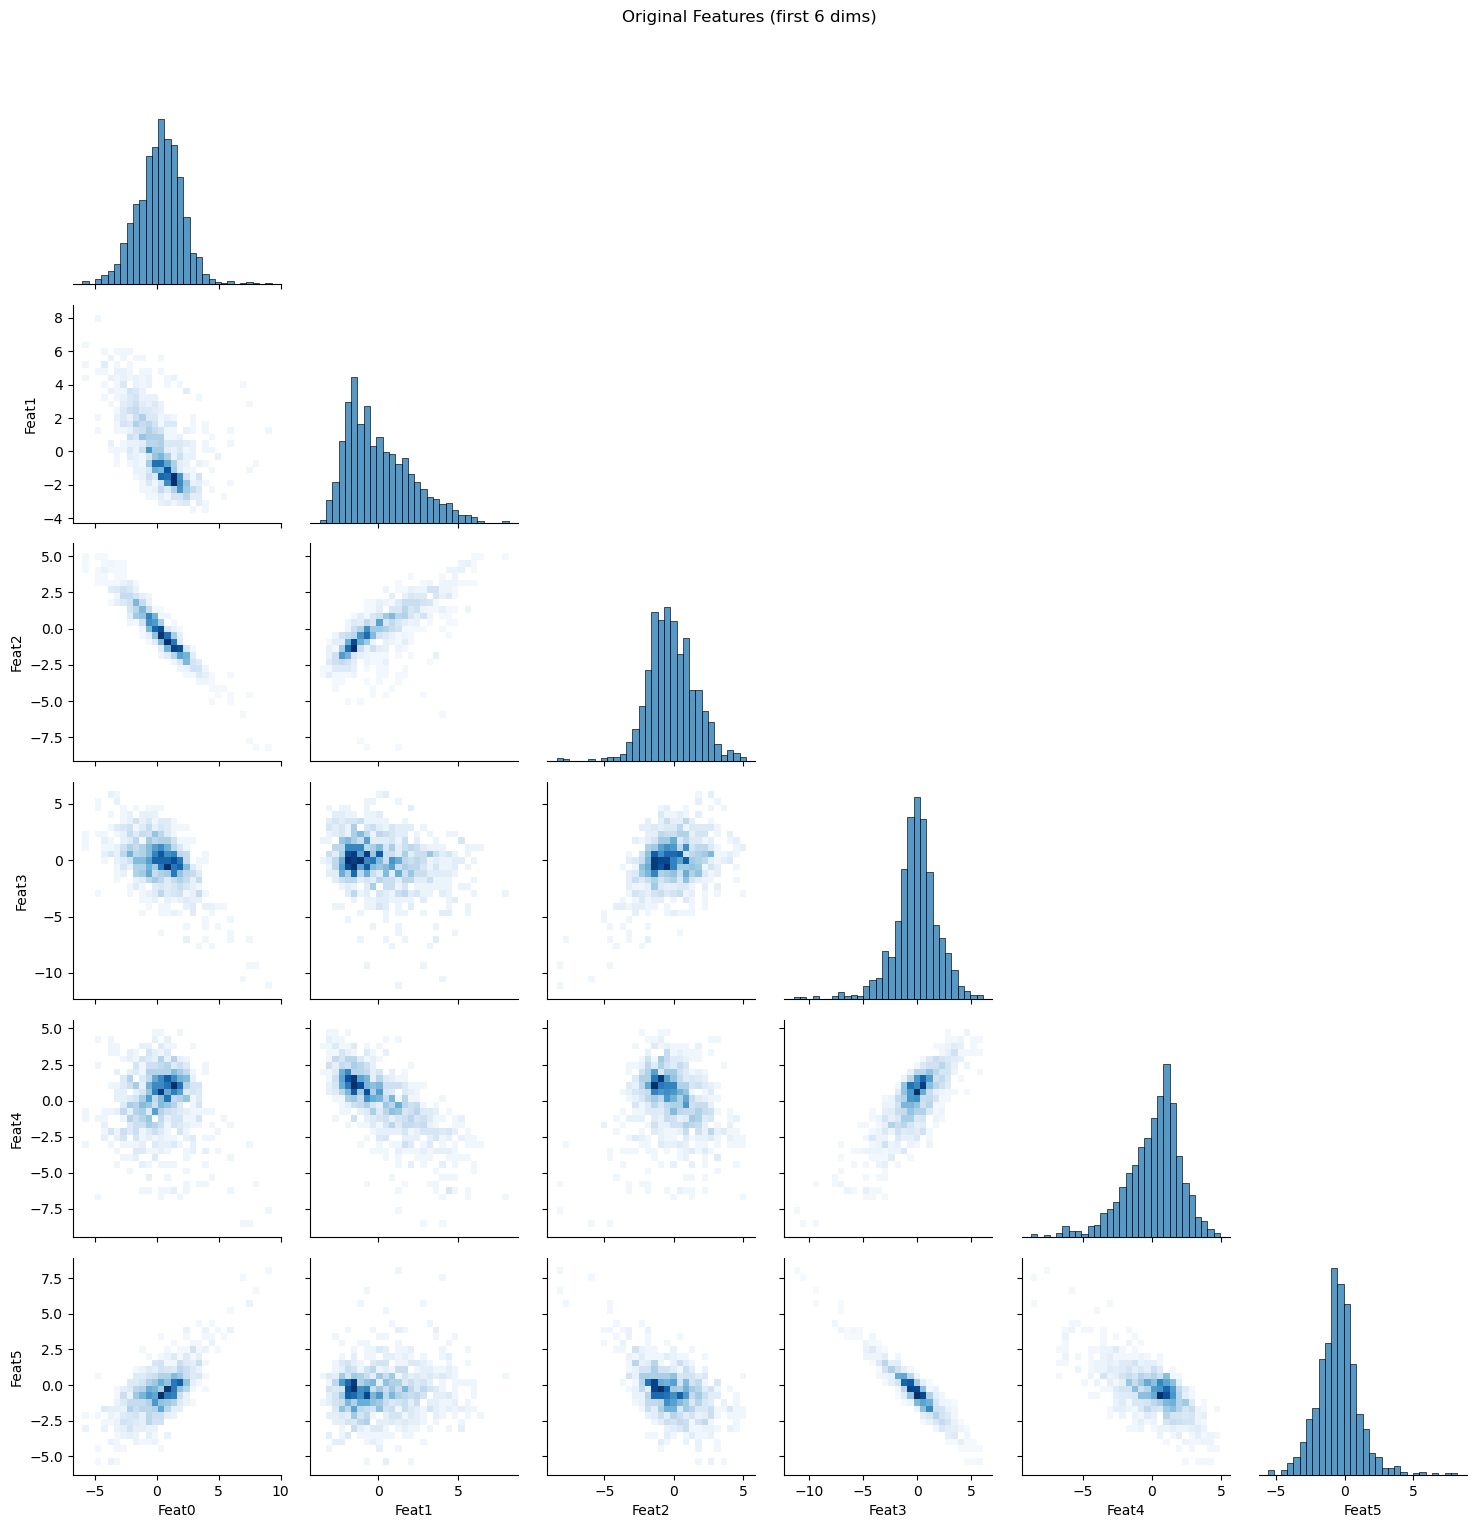

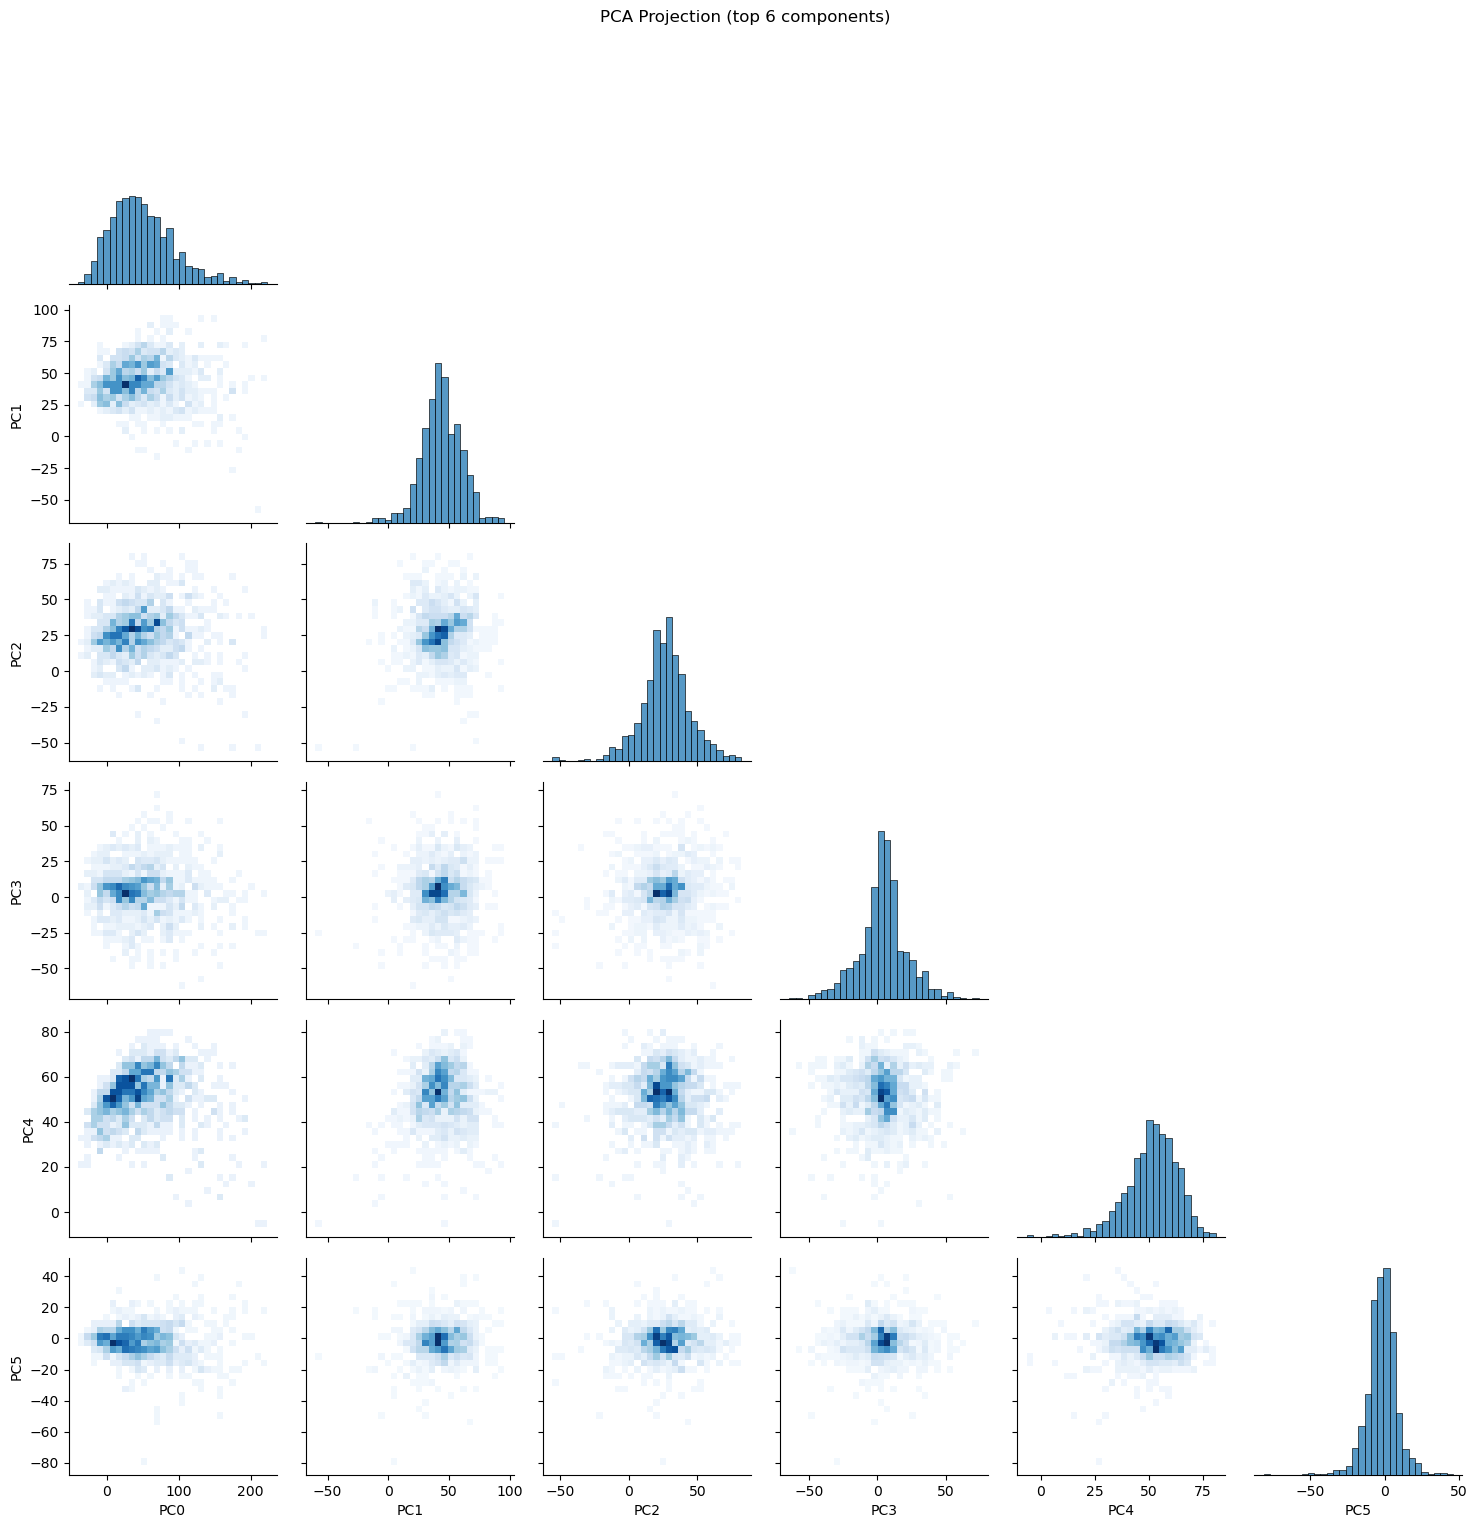

In [51]:
# Number of features to visualize
n_feat = 6

# Prepare DataFrames
df_before = pd.DataFrame(
    embeddings_train[:, :n_feat],
    columns=[f"Feat{i}" for i in range(n_feat)]
)
df_after = pd.DataFrame(
    np.concatenate(list(train_pca_ds.map(lambda x, y: x).as_numpy_iterator()), axis=0)[:, :n_feat],
    columns=[f"PC{i}" for i in range(n_feat)]
)

# Plot settings
sample_size = 1000

# Before PCA: corner plot with histograms
g_before = sns.PairGrid(df_before.sample(sample_size), corner=True)
g_before.map_diag(sns.histplot, bins=30, log_scale=False)
g_before.map_lower(sns.histplot, bins=30, cmap="Blues")
plt.suptitle("Original Features (first 6 dims)", y=1.02)
plt.show()

# After PCA: corner plot with histograms
g_after = sns.PairGrid(df_after.sample(sample_size), corner=True)
g_after.map_diag(sns.histplot, bins=30, log_scale=False)
g_after.map_lower(sns.histplot, bins=30, cmap="Blues")
plt.suptitle("PCA Projection (top 6 components)", y=1.02)
plt.show()


#### Printing some marginal distributions info:
This cell calculates mean, std deviation, skew and kurtosis of all the marginal distributions and prints the values first by the highest kurtosis and then by the highest skew.

In [52]:
def dataset_to_array(ds, max_samples=None):
    arrs = []
    total = 0
    for batch in ds:
        # unpack if it’s (x,y)
        x = batch[0] if isinstance(batch, (tuple, list)) else batch
        x_np = x.numpy().astype(np.float64)
        arrs.append(x_np)
        total += x_np.shape[0]
        if max_samples and total >= max_samples:
            break
    stacked = np.vstack(arrs)
    return stacked[:max_samples] if max_samples else stacked

# number of batches ≈ ceil(5000/128) = 40
X_norm = dataset_to_array(ds_test, max_samples=5000)
X_anom = dataset_to_array(ds_anom, max_samples=5000)

# pick whichever you want to inspect (here normals):
X = X_norm

df = pd.DataFrame(X, columns=[f"D{i}" for i in range(X.shape[1])])
stats = df.agg(['mean','std']).T
stats['skew']     = df.apply(skew)
stats['kurtosis'] = df.apply(kurtosis)

print(stats.sort_values('kurtosis', ascending=False).head(10), '\n\n')
print(stats.sort_values('skew', key=lambda s: np.abs(s), ascending=False).head(10))


         mean       std      skew  kurtosis
D24 -0.013889  1.005031 -0.577561  5.917319
D3  -0.041656  0.903800  1.351742  2.934092
D23 -0.012928  1.005814  0.288700  1.939070
D30  0.009892  1.047673  0.356146  1.807125
D26 -0.035105  1.038160  0.192688  1.483013
D20  0.033038  0.980825 -0.058047  1.373437
D14 -0.016265  0.980533  0.168686  1.346534
D0  -0.019797  0.967398 -0.766934  1.231476
D4   0.050020  0.928590 -0.334631  1.211452
D10  0.056768  0.968133  0.207800  1.209531 


         mean       std      skew  kurtosis
D3  -0.041656  0.903800  1.351742  2.934092
D0  -0.019797  0.967398 -0.766934  1.231476
D24 -0.013889  1.005031 -0.577561  5.917319
D30  0.009892  1.047673  0.356146  1.807125
D2   0.033380  0.998345 -0.336224  0.183915
D4   0.050020  0.928590 -0.334631  1.211452
D15 -0.024628  0.934886 -0.317023  0.863289
D5  -0.011421  0.994881 -0.303920  1.130630
D19 -0.005713  1.002218  0.290350  1.076290
D23 -0.012928  1.005814  0.288700  1.939070


### Alternative transformation
In the others attmempts to build a solid preprocessing pipeline, one of the most promising alternative approach was to apply a standardizzation to each manginal distribution:

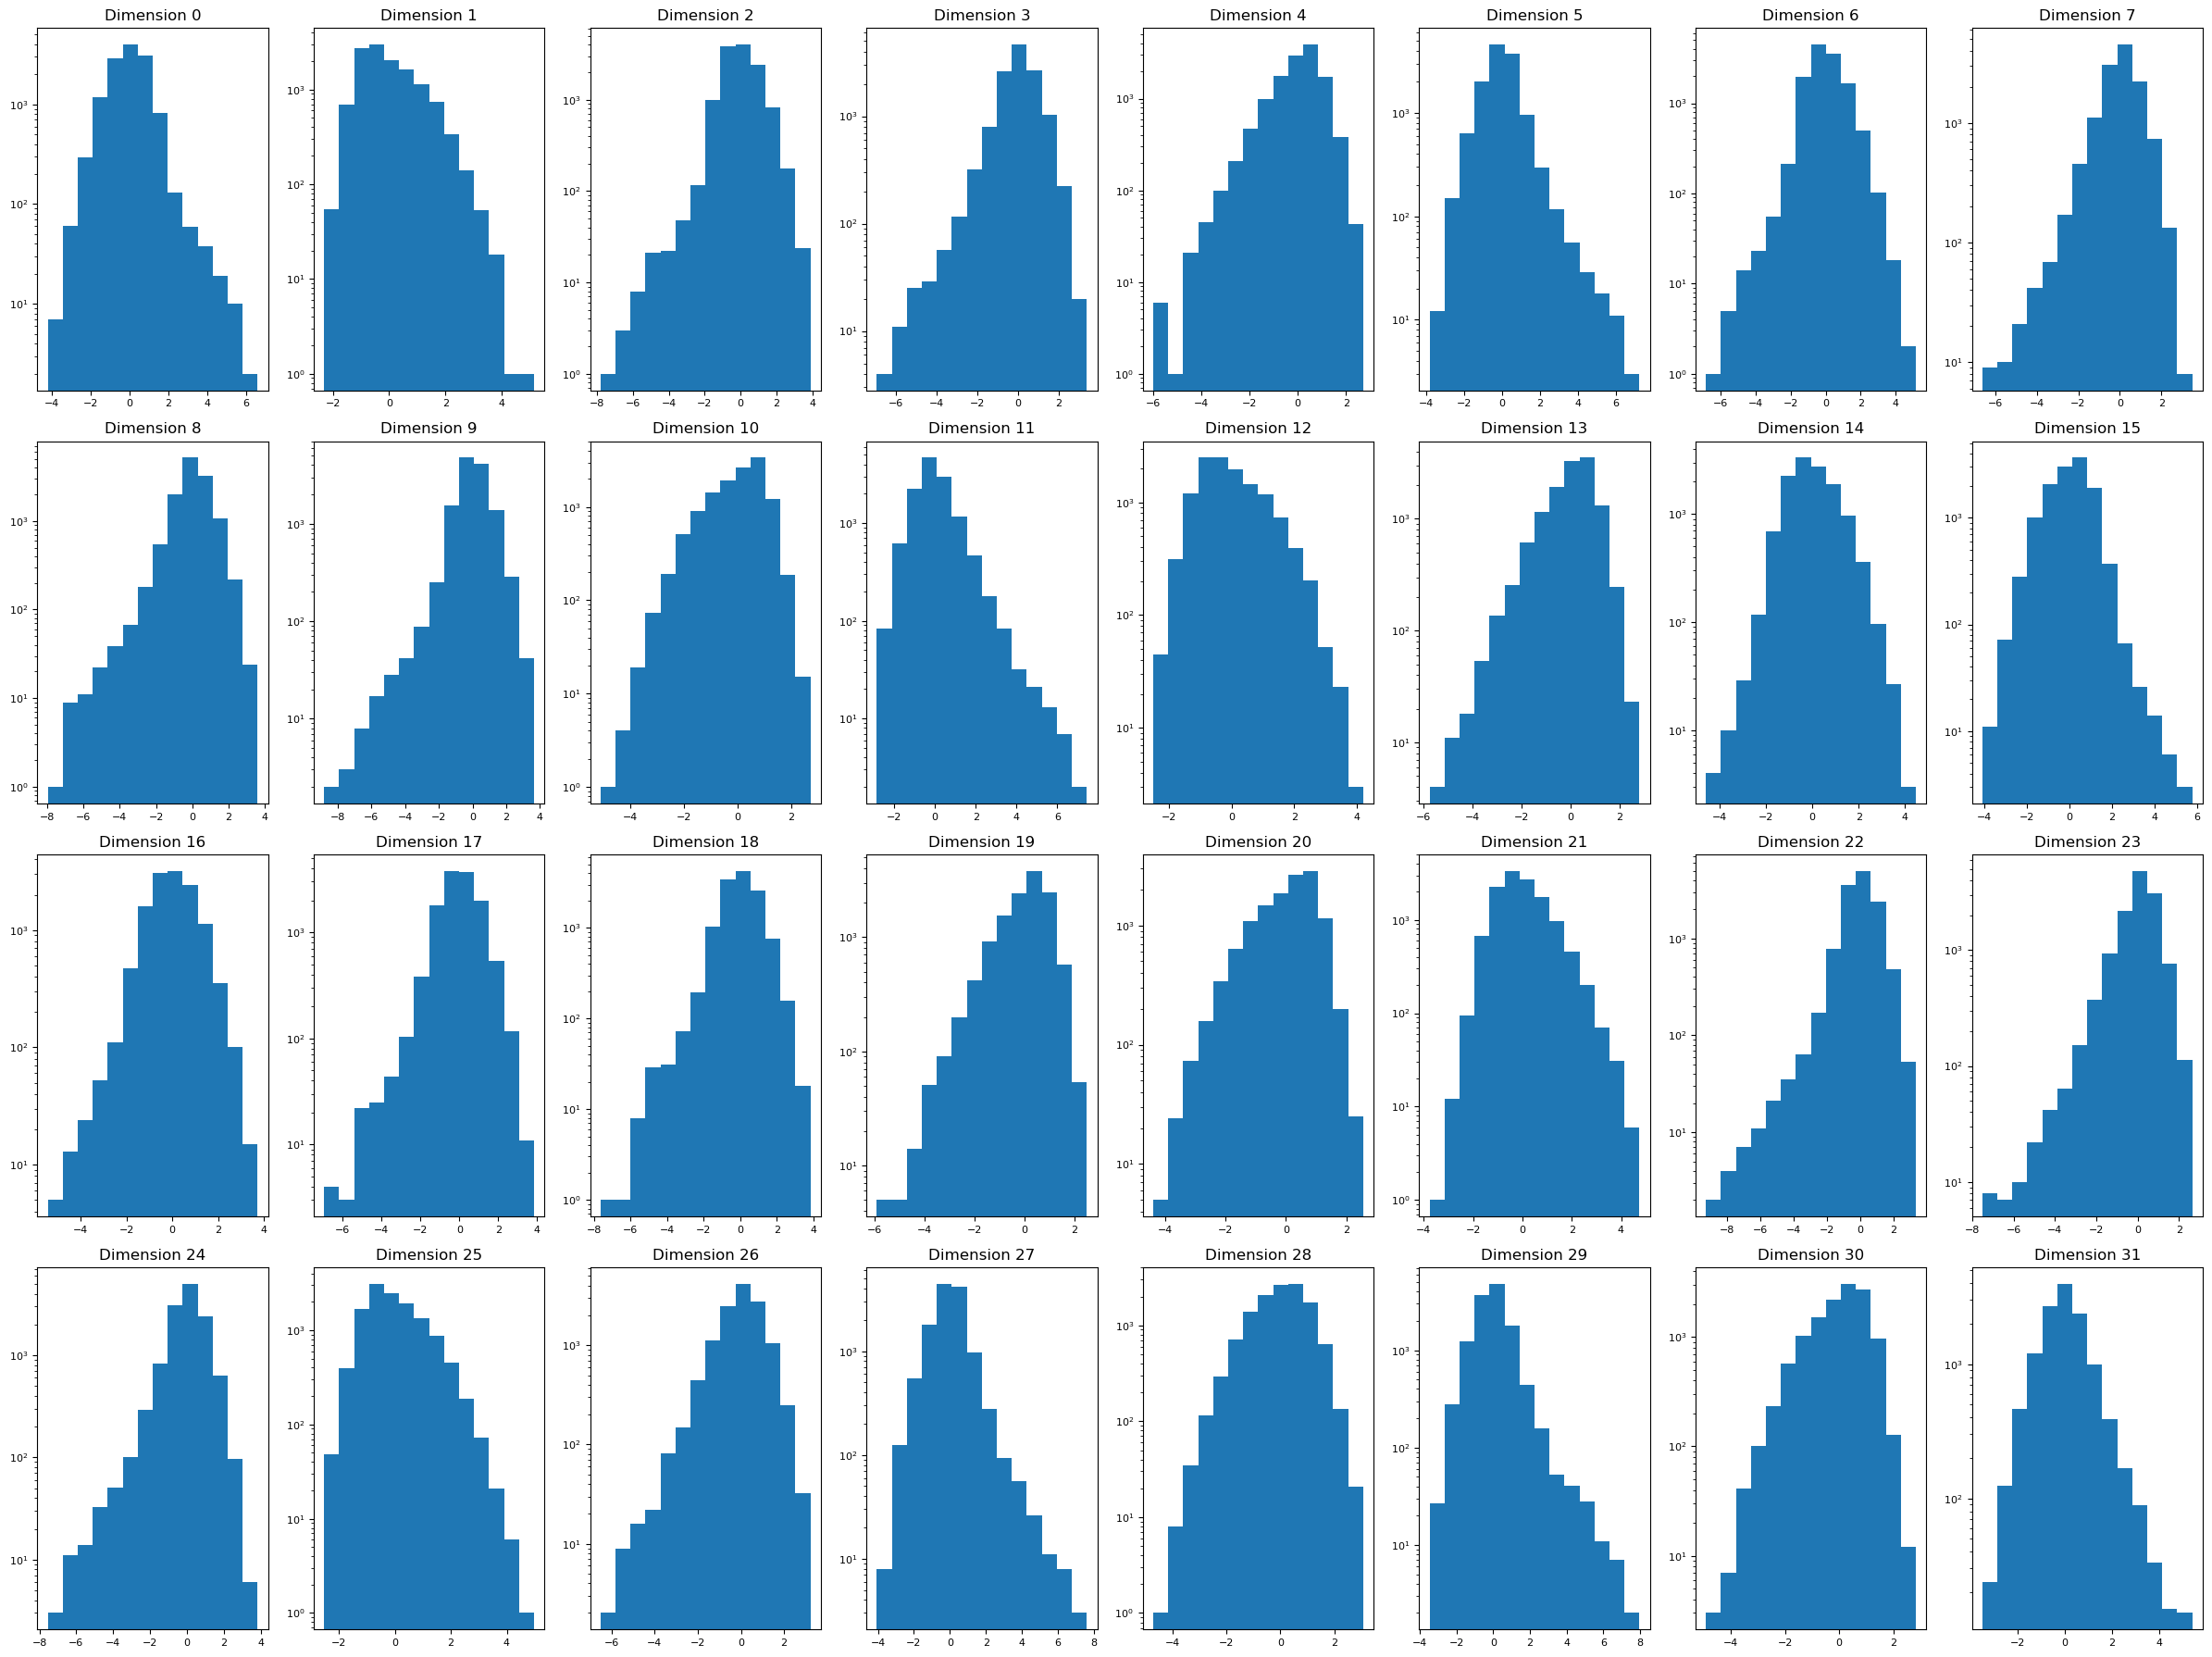

In [53]:
def compute_per_dim_standardization(embeds: np.ndarray):
    """
    Compute per-dimension mean and std.
    embeds: shape (N, D)
    Returns:
      means: shape (D,)
      stds:  shape (D,) with any zeros replaced by 1.0
    """
    means = np.mean(embeds, axis=0)
    stds = np.std(embeds, axis=0)
    # avoid division by zero
    stds[stds == 0] = 1.0
    return means, stds

def apply_standardization(embeds: np.ndarray, means: np.ndarray, stds: np.ndarray):
    """
    Apply the computed standardization.
    """
    return (embeds - means)/ stds

# Compute on training set
means, stds = compute_per_dim_standardization(embeddings_train)

# Transform both train and validation
X_train_std = apply_standardization(embeddings_train, means, stds)
X_val_std   = apply_standardization(embeddings_val,   means, stds)
X_anom_std   = apply_standardization(embeddings_anom,   means, stds)
X_test_std   = apply_standardization(embeddings_test,   means, stds)

plot_embeddings(X_train_std, title="Standardized Train Embeddings")


This lead to same results if not a bit worse due to the more complicated marginals to be learned. This was discarded for this reason.

## GMM


### Introduction to Gaussian Mixture Models (GMM)

A **Gaussian Mixture Model** is a probabilistic model that represents a distribution as a weighted sum of multiple Gaussian (normal) components. Each component captures a “cluster” or subpopulation within the data.

---

#### Model Definition

- **Mixture density**  
  $$
    p(x) = \sum_{k=1}^{K} \pi_k \,\mathcal{N}(x \mid \mu_k, \Sigma_k)
  $$  
  where  
  - \(K\) = number of components  
  - \(\pi_k\) = mixture weight for component \(k\) (\(\sum_k \pi_k = 1\))  
  - \(\mathcal{N}(x \mid \mu_k, \Sigma_k)\) = Gaussian density with mean \(\mu_k\) and covariance \(\Sigma_k\)

- **Parameters**  
  \(\{\pi_k, \mu_k, \Sigma_k\}_{k=1}^K\) define the model.

---

#### How It Works: The EM Algorithm

1. **Initialization**  
   - Guess initial \(\mu_k, \Sigma_k\) (e.g. via K-means)  
   - Set weights \(\pi_k = 1/K\)

2. **Expectation (E) Step**  
   - For each data point \(x_i\) and component \(k\), compute the **responsibility**:  
     $$
       \gamma_{ik} = \frac{\pi_k \,\mathcal{N}(x_i \mid \mu_k, \Sigma_k)}
                        {\sum_{j=1}^K \pi_j \,\mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
     $$  
   - \(\gamma_{ik}\) = probability that \(x_i\) was generated by component \(k\).

3. **Maximization (M) Step**  
   - Update parameters using responsibilities:  
     $$
       N_k = \sum_i \gamma_{ik}, \quad
       \mu_k = \frac{1}{N_k} \sum_i \gamma_{ik}\, x_i, \quad
       \Sigma_k = \frac{1}{N_k} \sum_i \gamma_{ik}\,(x_i - \mu_k)(x_i - \mu_k)^\top, \quad
       \pi_k = \frac{N_k}{N}
     $$

4. **Iterate** E and M steps until convergence (changes in log-likelihood fall below a threshold).

---

#### Why Use GMM?

- **Flexibility**: can model complex, multimodal distributions by combining simple Gaussians.  
- **Soft clustering**: assigns each point a probability of belonging to each cluster (not a hard label).  
- **Density estimation**: provides a full probability density function, useful for anomaly detection (low-likelihood points are anomalies).  

---

#### preprocess:
I will not use the preprocessed data to train the GMM because the performance is much worst for theese reasons:

1. **Loss of discriminative variance**  
   PCA only preserves the directions of highest overall variance—not necessarily the ones most useful for modeling Gaussian components. Low-variance but class-separating signals get discarded, so the GMM has less to work with.

2. **Whitening amplifies noise**  
   By forcing each principal component to unit variance, PCA whitening can boost tiny inverse eigenvalue directions, effectively upweighting noise and making the GMM fit spurious patterns.

3. **Gaussian assumptions break down**  
   The pretrained ResNet embeddings are already “semi-Gaussian” in their high-dimensional space; a GMM can naturally capture their covariance structure. After PCA, the data are decorrelated by design, which can work against the GMM’s ability to model full covariance between features.


### Tuning and building the model: 
In this section I loop over a variable $K$, init and fit a GMM with $K$ components, and compute it's AUC. The best performing model is saved for future evaluations.

In [54]:
def eval_gmm_from_model(gmm, feats_norm, feats_anom):
    
    # 1) compute (negative) log-likelihood scores
    scores_norm = -gmm.score_samples(feats_norm)
    scores_anom = -gmm.score_samples(feats_anom)

    # 2) build true/score arrays for AUC
    y_true   = np.concatenate([np.zeros_like(scores_norm),
                               np.ones_like( scores_anom)])
    y_scores = np.concatenate([scores_norm, scores_anom])

    # 3) return performance
    return roc_auc_score(y_true, y_scores), scores_norm, scores_anom

In [55]:
best_auc   = -np.inf
best_model = None
results    = []

# set the maximun number of components at 11 to mitigate the overfitting and the running time
for K in range(1, 12):
    # 1) instantiate + fit
    gmm_k = GaussianMixture(
        n_components   = K,
        covariance_type= 'full',
        random_state   = 0
    )
    gmm_k.fit(embeddings_train)

    # 2) evaluate on anomaly task
    #    (re-use your existing eval_gmm logic but taking a model instance)
    auc_k, _, _ = eval_gmm_from_model(gmm_k, embeddings_train, embeddings_anom)
    results.append((K, auc_k))

    # 3) track best
    if auc_k > best_auc:
        best_auc   = auc_k
        best_model = gmm_k

# 4) print table
print(f"{'K':>2}  {'AUC':>6}")
for K, auc_score in results:
    print(f"{K:2d}  {auc_score:6.3f}")

print("Best K by AUC:", best_model.n_components, "→ AUC =", best_auc)

# 5) assign the chosen model
gmm = best_model


 K     AUC
 1   0.821
 2   0.834
 3   0.840
 4   0.828
 5   0.845
 6   0.839
 7   0.839
 8   0.839
 9   0.845
10   0.847
11   0.848
Best K by AUC: 11 → AUC = 0.8483770634951157


### Evaluation

In [56]:
# 4) Evaluate on normal vs. anomaly sets
# ---------------------------------------
auc_prelim, scores_norm, scores_anom = eval_gmm_from_model(gmm, embeddings_train, embeddings_anom)

#building the labels for the anomalies and the scores
# (Optional) Combine and compute metrics, e.g. AUROC:
y_true = np.concatenate([np.zeros_like(scores_norm), np.ones_like(scores_anom)])
y_scores = np.concatenate([scores_norm, scores_anom])
print(f"Anomaly Detection AUROC (GMM): {auc_prelim:.4f}")


Anomaly Detection AUROC (GMM): 0.8484


### Evaluation metrics

#### ROC

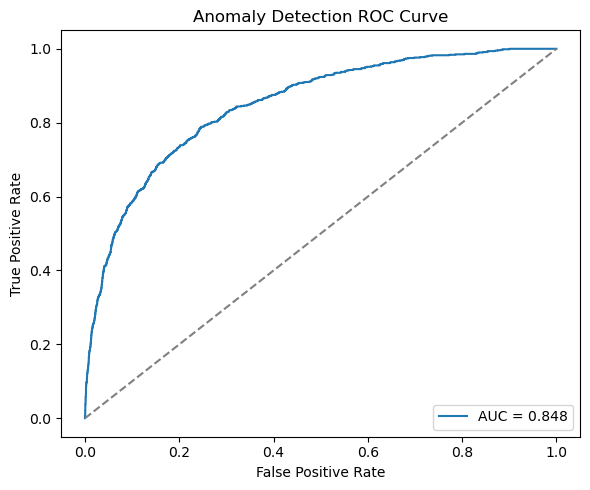

In [57]:
# ——————————————————————————————————————————————————————————————
# A) ROC Curve
fpr, tpr, thresh = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Anomaly Detection ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### Confusion matrix

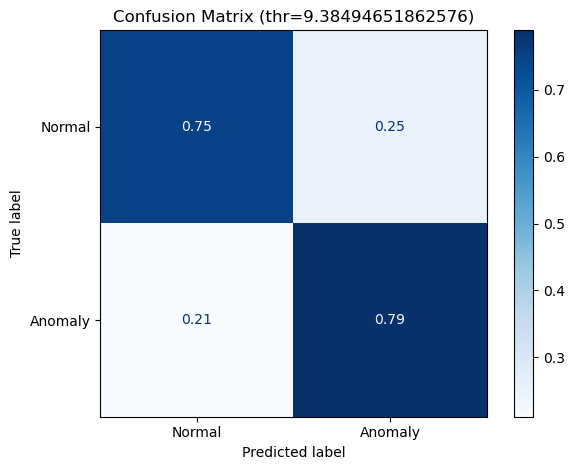

In [58]:
## B) Confusion Matrix @ threshold=0.5
threshold = np.percentile(scores_norm, 75)
y_pred = (y_scores >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix (thr={threshold})')
plt.tight_layout()
plt.show()

#### Histograms of scores

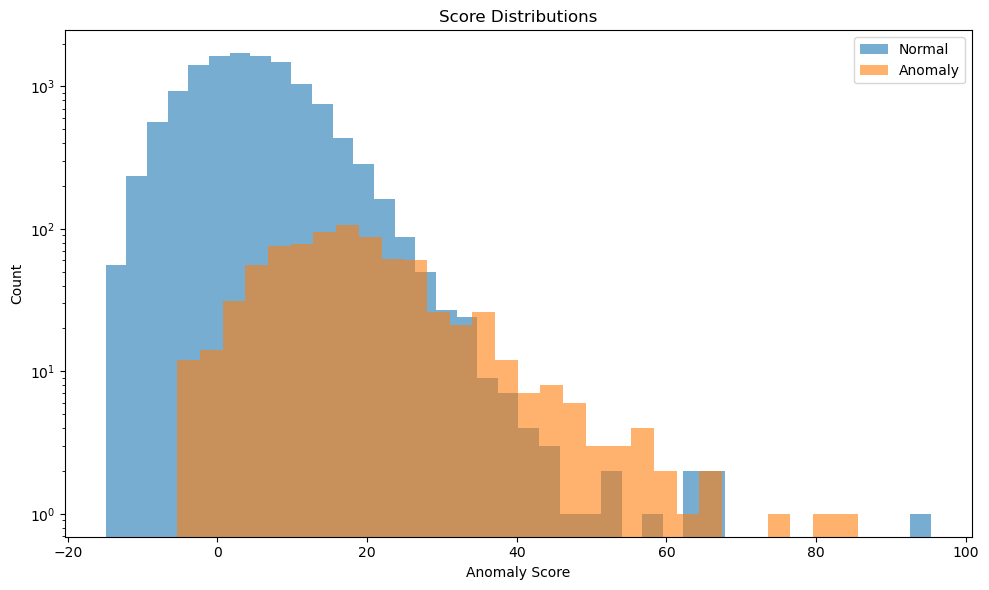

In [59]:
# C) Histogram of scores
plt.figure(figsize=(10,6))
plt.hist(scores_norm, bins=40, alpha=0.6, label='Normal')
plt.hist(scores_anom, bins=30, alpha=0.6, label='Anomaly')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Score Distributions')
plt.legend()
plt.tight_layout()
plt.show()

#### Conclusions:
as you can see from this metrics this is not working properly.

## MAF
I build a MAF by chaining single `tfb.MaskedAutoregressiveFlow` bijecotrs. I'll set the shift_and_log_scale_fn to be a MADE block implemented by tfb.AutoregressiveNetwork to output the parameters for the transformations (the standard `tfb.MaskedAutoregressiveFlow` bijector implements an affine transformation as introducted in the original paper).  
I've choosen a MAF because it should be a bit more poweful than a VAE or other reconstruction-based models. It slower in training but it should be fast in the evaluation phase. I could have implemented a IAF to be fatser in the training and a bit slower in evaluation. 

### Callbacks

In [60]:
# 1) Checkpoint: save only the best weights
checkpoint_cb_maf = ModelCheckpoint(
    "maf/best_maf_weights_6bij.h5",  # filepath
    monitor="val_loss",       # or "val_loss" / "val_macro_f1"
    save_best_only=True,
    save_weights_only=True,       # only weights; change to False to save entire model
    mode="min",                   # because higher accuracy is better
    verbose=1,
)

# 2) Early stopping to avoid overtraining
earlystop_cb_maf = EarlyStopping(
    monitor="val_loss",
    patience=7,       # stop if no improvement in 3 epochs
    restore_best_weights=True,  # roll back to best at end of training
    mode="min",
    verbose=1,
)

# 3) Create ReduceLROnPlateau
reduce_lr_cb_maf = ReduceLROnPlateau(
    monitor="val_loss",    # what to monitor
    factor=0.5,            # reduce LR by this factor
    patience=2,            # wait this many epochs before reducing
    min_lr=1e-6,           # lower bound on LR
    verbose=1
)

# 4) create the terminate callback
terminate_cb = TerminateOnNaN()

# this logs the parameters of the model at the end of every multiple of log_every_n_batches.
#param_logger = ParamLoggingCallback(log_every_n_batches=40)

# 5) Catch and debug NaN values: when the loss becomes NaN, this callback will 
# log the batch and the input data that caused it.
debug_cb = CatchAndDebugNaN(train_dataset=ds_train)


### Building the chain:
To limit the explosion of tra transformations parameters i've added a clamp so that the loss doesn't explode and i can train the model. I tried using optimizzation techniques like L2 or Dropout but nothing has helped.  

**Masked Autoregressive Flow (MAF) Model Summary**

1. **Shift & Scale Function (`make_clamp_fn`)**  
   - Wraps a MADE network that outputs 2×`event_shape` parameters.  
   - Optionally applies the same dropout mask to both shift & log-scale halves.  
   - **Clamps** `log_scale` into \([\,\text{min_ls},\,\text{max_ls}\,]\).

2. **Flow Construction (`build_clamped_maf_keras_model`)**  
   - Repeats **`num_flows`** blocks of:  
     1. `MaskedAutoregressiveFlow(shift_and_log_scale_fn=clamp_fn)` using the clamped MADE.  
     2. Optional `Permute` of all `event_shape` dimensions to mix order.  
   - Drops the final permutation so the last bijector remains a MAF.

3. **Model Wrapper**  
   - Wraps the bijector chain in a `TransformedDistribution` over a diagonal Gaussian base.  
   - Exposes `log_prob(inputs)` as the Keras model output, with `-mean(log_prob)` as the loss.  
   - Compiles with **AdamW** (weight decay + clipnorm) and **XLA** JIT for speed.  


In [61]:
num_flows = 5
hidden_units = [128, 128]  # MAF hidden layer sizes
event_shape = 32  # dimensionality of the embeddings
lr = 4e-4  # learning rate for AdamW optimizer
#maf_model = build_maf_keras_model(num_flows,
maf_model = build_clamped_maf_keras_model(num_flows,
    hidden_units,
    event_shape = event_shape,
    learning_rate = lr,
    use_permutation = True,
    weight_decay = 1e-7,
    clipnorm = 3.0,
    dropout_rate = None,
    min_log_scale = -5.0,
    max_log_scale = 5.0
    )

### Train:
Due to the introduction of clamps and the intrinsic slowness of the model training this takes a long time (106 minutes). For this reason i reccomend to use the weight i provide with the notebook. 

In [62]:
epochs = 50 
maf_model, need_maf_train = need_training(maf_model, "maf/best_maf_weights.h5", force_retrain=False)
if need_maf_train:
    maf_model.fit(ds_train, validation_data = ds_val, epochs=epochs, 
                  callbacks=[checkpoint_cb_maf, earlystop_cb_maf, terminate_cb, debug_cb, reduce_lr_cb_maf])

 Weights found at 'maf/best_maf_weights.h5' → loading and skipping training.


### Saving model hyperparameters.

In [63]:
# 1) Define your hyperparameters here
hyperparams = {
    "n_flows": num_flows,
    "hidden_units": hidden_units,
    "batch_size": 64,
    "learning_rate": lr,
    "epochs": 20,
    # add any other settings you’ll need to reconstruct/train your MAF
}

# 2) Ensure the directory exists
save_dir = "maf"
os.makedirs(save_dir, exist_ok=True)

# 3) Save hyperparameters to JSON
config_path = os.path.join(save_dir, "hyperparameters.json")
with open(config_path, "w") as f:
    json.dump(hyperparams, f, indent=4)
print(f"Saved hyperparameters to {config_path}")


Saved hyperparameters to maf/hyperparameters.json


### Evaluate and visualize
This function returns the -logp of the inputs to evaluate the metrics i will discuss later. 

In [64]:
## evaluate anmaly detection performance
scores_norm, scores_anom, _ = evaluate_to_visual(
    maf_model,
    ds_test,
    ds_anom
)

2025-06-25 12:47:45.097019: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x563f501b0ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-25 12:47:45.097103: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-06-25 12:47:45.097116: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA L40S, Compute Capability 8.9
2025-06-25 12:47:45.097127: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (2): NVIDIA L40S, Compute Capability 8.9
2025-06-25 12:47:45.097137: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (3): NVIDIA L40S, Compute Capability 8.9
2025-06-25 12:47:45.160306: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-25 12:47:46.168401: I ./tensorflow/compile

AUROC = 0.8483


### ROC

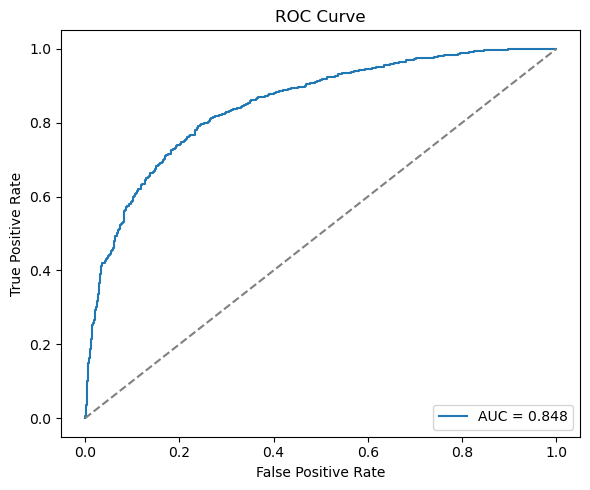

0.8482914874924862

In [65]:
plot_maf_roc_curve(scores_norm=scores_norm, scores_ano=scores_anom)

### score histograms
This plot shows the score distributions. The greater the separation between the samples, the better the model can distinguish normal galaxies from anomalies.

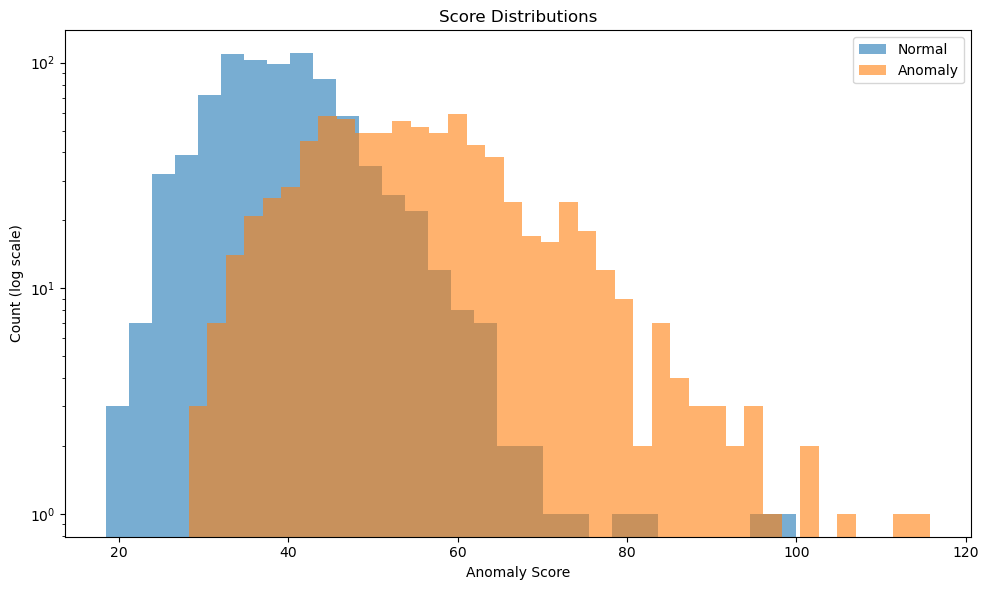

In [66]:
plot_score_histograms(scores_norm, scores_anom, norm_bins=30, anom_bins=40)

### Evaluation Metrics

Below are the metrics we compute on our anomaly‐detection scores. Together they give a comprehensive view of model performance on both ranking and binary‐decision tasks.

1. **ROC AUC**  
   - Measures overall ranking quality, independent of any specific threshold

2. **PR AUC** (Average Precision)  
   - **What it is:** Area under the Precision-Recall curve, plotting Precision vs Recall as threshold varies.  
   - More informative than ROC when classes are imbalanced (anomalies are rare), since it focuses on the positive (anomaly) class.

3. **TPR @ 1 % FPR**  
   - **What it is:** The True Positive Rate when the False Positive Rate is fixed at 1 %.  
   - In many anomaly‐detection settings we tolerate only a very small false‐alarm rate; this tells us how many anomalies we still catch under that constraint.

4. **Precision @ K**  
   - **What it is:** Among the top \(K\) highest‐scoring samples, the fraction that are true anomalies.  
   - Simulates a human‐in‐the-loop scenario where an expert inspects the \(K\) most suspicious cases.  

   $$  
   P@K = \frac{1}{K}\sum_{i \in \text{top-}K}\!\! \mathbf{1}\{y_i = 1\}  
   $$

5. **F₁ @ chosen threshold**  
   - **What it is:** The harmonic mean of precision and recall at a fixed score threshold (e.g. the 90th percentile of scores).  
   - Gives a single‐number balance between false positives and false negatives once you commit to an operating point.  

   $$  
   F_1 = 2 \times \frac{\text{Precision}\;\times\;\text{Recall}}{\text{Precision} + \text{Recall}}  
   $$

6. **Matthews Correlation Coefficient (MCC)**  
   - **What it is:** A correlation coefficient between observed and predicted binary classifications; ranges from –1 (total disagreement) to +1 (perfect agreement).  
   - Robust to class imbalance; uses all four confusion‐matrix entries and rewards both balanced accuracy and balanced error.


In [67]:
y_true   = np.concatenate([np.zeros_like(scores_norm), np.ones_like(scores_anom)])
y_score = np.concatenate([scores_norm,       scores_anom])

# 1) ROC-AUC
roc_auc = roc_auc_score(y_true, y_score)

# 2) PR-AUC
pr_auc  = average_precision_score(y_true, y_score)

# 3) TPR @ 1% FPR
fpr, tpr, thr = roc_curve(y_true, y_score)
tpr_at_1pct_fpr = tpr[fpr <= 0.05].max()  # might want .mean() if empty

# 4) Precision @ K
def precision_at_k(y_true, y_score, K):
    idx = np.argsort(y_score)[-K:]
    return y_true[idx].sum() / K

p_at_10  = precision_at_k(y_true, y_score, 10)
p_at_50  = precision_at_k(y_true, y_score, 50)
p_at_100 = precision_at_k(y_true, y_score, 100)

# 5) F1 @ chosen threshold
#    e.g. set threshold at 95th percentile of train scores
thr95 = np.percentile(y_score, 90)
y_pred = (y_score >= thr95).astype(int)
f1     = precision_score(y_true, y_pred, average="binary") * recall_score(y_true, y_pred, average="binary") * 2 \
           / (precision_score(y_true, y_pred) + recall_score(y_true, y_pred))

# 6) Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")
print(f"TPR@1%FPR: {tpr_at_1pct_fpr:.3f}")
print(f"P@10:     {p_at_10:.3f}, P@50: {p_at_50:.3f}, P@100: {p_at_100:.3f}")
print(f"F1@95thpct: {f1:.3f}")
print(f"MCC:       {mcc:.3f}")


ROC-AUC: 0.848
PR-AUC:  0.837
TPR@1%FPR: 0.438
P@10:     0.800, P@50: 0.920, P@100: 0.950
F1@95thpct: 0.319
MCC:       0.300


## RealNVP

### Callbacks

In [68]:
### best model has 4 flows, 128,128 hidden units, clamp_log_scale=True
    #auc = 0.94
# 1) Checkpoint: save only the best weights
checkpoint_cb_rnvp = ModelCheckpoint(
    "realnvp/best_realnvp_weights.h5",  # filepath
    monitor="val_loss",       # or "val_loss" / "val_macro_f1"
    save_best_only=True,
    save_weights_only=True,       # only weights; change to False to save entire model
    mode="min",                   # because higher accuracy is better
    verbose=1,
)
reduce_lr_cb_rnvp = ReduceLROnPlateau(
    monitor="val_loss",    # what to monitor
    factor=0.8,            # reduce LR by this factor
    patience=15,            # wait this many epochs before reducing
    min_lr=1e-7,           # lower bound on LR
    verbose=1
)

earlystop_cb_rnvp = EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,  # roll back to best at end of training
    mode="min",
    verbose=1,
)


### Build the model

**RealNVP Flow Construction & Model Summary**

1. **Coupling-layer builder (`make_realnvp_fn`)**  
   - Creates a small MLP (`hidden_layers` of Dense→ReLU + one Dense) to use as `shift_and_log_scale_fn`.  
   - Splits its output into **shift** and **log-scale** vectors of length `ndims/2`.  
   - Optionally **clamps** the learned log-scale between `min_ls` and `max_ls` for the same reason as in the MAF.

2. **Permutation strategy (`build_random_shuffle_realnvp_chain`)**  
   - Alternates two RealNVP coupling layers per block: one masking the first half, one the second.  
   - **Bi-permutation**: between the two couplings in each block, swaps the two halves (fixed interleaving).  
   - **Random permutation**: after the second coupling, applies a random reorder of all dimensions.  
   - Repeats the above for `num_bijectors` blocks, then reverses the list (so the flow ends on a RealNVP).

3. **Keras model wrapper (`build_realnvp_keras_model`)**  
   - Defines an `Input(shape=(event_shape,))` for your embeddings.  
   - Constructs the RealNVP **bijector chain** + heavy-tailed Student-T base distribution.  
   - Builds a `TransformedDistribution(base, bij)` and exposes `log_prob(x)` as the model output.  
   - Adds `-mean(log_prob)` as the training loss and compiles with an AdamW optimizer.  

By inserting both **bi-permutations** (fixed swapping of halves) and **random permutations** between couplings, the flow ensures that **all dimensions** interact over multiple layers, improving mixing and expressivity.


In [69]:

#del realnvp_model
num_flows = 6
hidden_units = [128, 128]  # MAF hidden layer sizes
event_shape = 32  # dimensionality of the embeddings
lr = 4e-4  # learning rate for Adam optimizer
#maf_model = build_maf_keras_model(num_flows,
realnvp_model = build_realnvp_keras_model(num_flows,
    hidden_units,
    event_shape = event_shape,
    learning_rate = lr,
    weight_decay = 1e-6,
    clipnorm = 5.0,
    clamp_log_scale = True,
    min_log_scale = -4.0,
    max_log_scale = 4.0,
    seed = SEED
    )

In [70]:
epochs = 100 
realnvp_model, need_realnvp_train = need_training(realnvp_model, "realnvp/best_realnvp_weights.h5", force_retrain=False)
if need_realnvp_train:
    history = realnvp_model.fit(ds_train, validation_data = ds_val, epochs=epochs, 
                                callbacks=[checkpoint_cb_rnvp, earlystop_cb_rnvp, terminate_cb, reduce_lr_cb_rnvp])

 Weights found at 'realnvp/best_realnvp_weights.h5' → loading and skipping training.


In [71]:
## evaluate anmaly detection performance
scores_norm, scores_anom, _ = evaluate_to_visual(
    realnvp_model,
    ds_test,
    ds_anom
)

AUROC = 0.8466


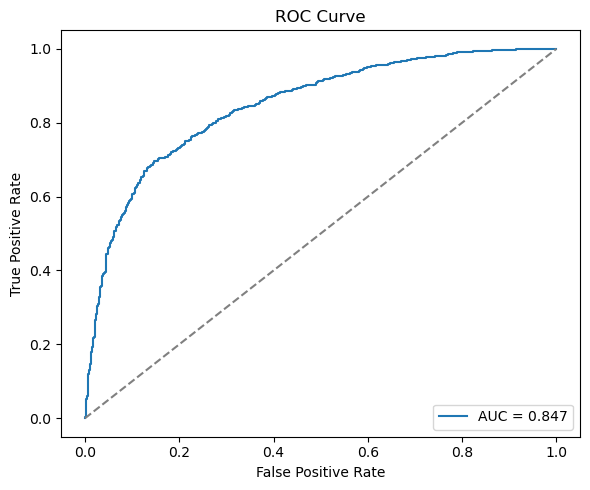

0.8466149690425797

In [72]:
plot_maf_roc_curve(scores_norm=scores_norm, scores_ano=scores_anom)

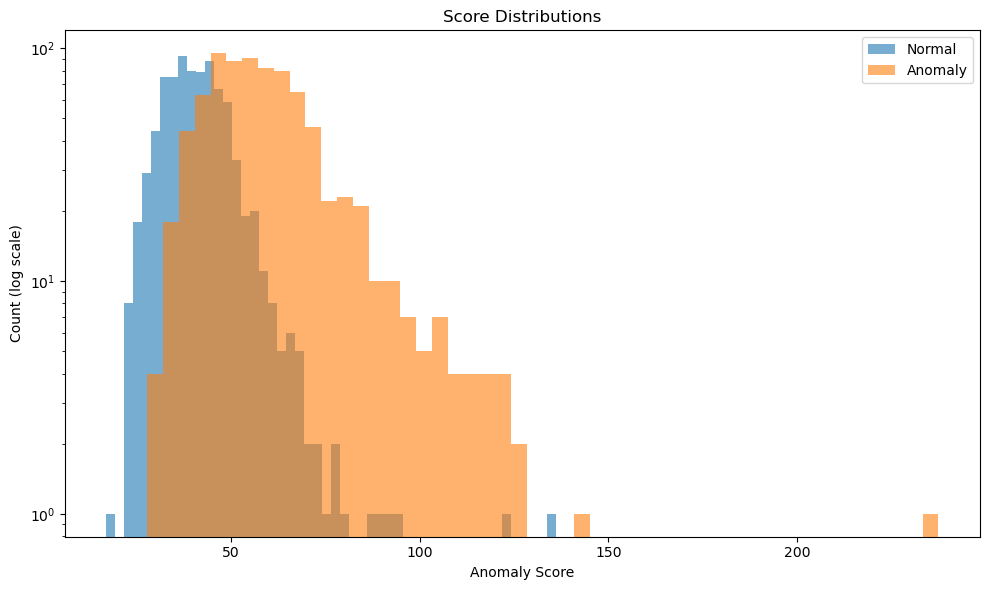

In [73]:
plot_score_histograms(scores_norm, scores_anom, norm_bins=50, anom_bins=50)

### Miscellaneous of metrics

In [74]:
y_true   = np.concatenate([np.zeros_like(scores_norm), np.ones_like(scores_anom)])
y_score = np.concatenate([scores_norm,       scores_anom])

# 1) ROC-AUC
roc_auc = roc_auc_score(y_true, y_score)

# 2) PR-AUC
pr_auc  = average_precision_score(y_true, y_score)

# 3) TPR @ 1% FPR
fpr, tpr, thr = roc_curve(y_true, y_score)
tpr_at_1pct_fpr = tpr[fpr <= 0.05].max()  # might want .mean() if empty

# 4) Precision @ K
def precision_at_k(y_true, y_score, K):
    idx = np.argsort(y_score)[-K:]
    return y_true[idx].sum() / K

p_at_10  = precision_at_k(y_true, y_score, 10)
p_at_50  = precision_at_k(y_true, y_score, 50)
p_at_100 = precision_at_k(y_true, y_score, 100)

# 5) F1 @ chosen threshold
#    e.g. set threshold at 95th percentile of train scores
thr95 = np.percentile(y_score, 90)
y_pred = (y_score >= thr95).astype(int)
f1     = precision_score(y_true, y_pred, average="binary") * recall_score(y_true, y_pred, average="binary") * 2 \
           / (precision_score(y_true, y_pred) + recall_score(y_true, y_pred))

# 6) Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")
print(f"TPR@1%FPR: {tpr_at_1pct_fpr:.3f}")
print(f"P@10:     {p_at_10:.3f}, P@50: {p_at_50:.3f}, P@100: {p_at_100:.3f}")
print(f"F1@95thpct: {f1:.3f}")
print(f"MCC:       {mcc:.3f}")


ROC-AUC: 0.847
PR-AUC:  0.832
TPR@1%FPR: 0.461
P@10:     0.800, P@50: 0.920, P@100: 0.940
F1@95thpct: 0.313
MCC:       0.288


## VAE
To build the VAE i created a class inheriting from tf.keras.Model. To train the decoder i will still use the ebbeings vector i created for the Normalis flows, despite the VAE is capable of handling higher dimensionality vectors and would benefit from them.

**Variational Autoencoder (VAE) Model Summary**

1. **Architecture**  
   - **Encoder**: Dense 256 → ReLU → 128 → ReLU → 64 → ReLU → Dense (2 × latent_dim)  
   - **Decoder**: Dense 64 → ReLU → 128 → ReLU → 256 → ReLU → Dense (input_dim)  

2. **Latent Sampling**  
   - **Encode**: split encoder output into `z_mean` and `z_logvar`.  
   - **Reparameterize**: sample $z = z_{\text{mean}} + e^{0.5\,z_{\text{logvar}}}\!\cdot\!\epsilon$, $\epsilon\sim\mathcal N(0,1)$.

3. **Loss & Training**  
   - **Reconstruction Loss (MSE)**: $\text{recon\_loss} = \mathbb{E}\bigl[\lVert x - \hat x\rVert^2\bigr].$
   - **KL Loss**: $\text{kl\_loss} = -\tfrac12\,\mathbb{E}\bigl[1 + z_{\text{logvar}} - z_{\text{mean}}^2 - e^{z_{\text{logvar}}}\bigr].$  
   - **Total Loss**: $\mathcal{L} = \text{recon\_loss} + \beta\,\text{kl\_loss},$ where $\beta$ controls the weight of the KL term.

4. **Custom Training Loop**  
   - Overrides `train_step`/`test_step` to compute losses, apply gradients, and report `loss`, `recon_loss`, and `kl_loss`.  


In [75]:
# Instantiate and compile
input_dim = 32  
latent_dim = 8  # Latent space dimension
vae = VAE(input_dim=input_dim, latent_dim=latent_dim, beta=0.5)
vae.compile(optimizer=tf.keras.optimizers.Adam(8e-4))

In [76]:
checkpoint_cb_vae = ModelCheckpoint(
    "VAE/best_VAE_weights.h5",  # filepath
    monitor="val_loss",       # or "val_loss" / "val_macro_f1"
    save_best_only=True,
    save_weights_only=True,       # only weights; change to False to save entire model
    mode="min",                   # because higher accuracy is better
    verbose=1,
)

reduce_lr_cb_vae = ReduceLROnPlateau(
    monitor="val_loss",    # what to monitor
    factor=0.5,            # reduce LR by this factor
    patience=5,            # wait this many epochs before reducing
    min_lr=1e-7,           # lower bound on LR
    verbose=1
)

vae.build(input_shape=(batch_size,input_dim,))  # build the model with input shape
vae, vae_need_train = need_training(vae, "VAE/best_VAE_weights.h5", force_retrain=False)
if vae_need_train:
    history = vae.fit(ds_train,
                      validation_data=ds_val,
                      epochs=100,
                      callbacks=[checkpoint_cb_vae, reduce_lr_cb_vae, EarlyStopping(patience=20)])

force_retrain=True → model will be trained from scratch.
Epoch 1/100
91/99 [==========================>...] - ETA: 0s - loss: 31.9886 - recon_loss: 31.7756 - kl_loss: 0.4261
Epoch 1: val_loss improved from inf to 32.46762, saving model to VAE/best_VAE_weights.h5
99/99 [==============================] - 5s 12ms/step - loss: 31.8875 - recon_loss: 31.6148 - kl_loss: 0.5453 - val_loss: 32.4676 - val_recon_loss: 31.3251 - val_kl_loss: 2.2851 - lr: 8.0000e-04
Epoch 2/100
99/99 [==============================] - ETA: 0s - loss: 29.8065 - recon_loss: 27.8537 - kl_loss: 3.9057
Epoch 2: val_loss improved from 32.46762 to 27.66051, saving model to VAE/best_VAE_weights.h5
99/99 [==============================] - 1s 15ms/step - loss: 29.7765 - recon_loss: 27.8171 - kl_loss: 3.9187 - val_loss: 27.6605 - val_recon_loss: 24.4037 - val_kl_loss: 6.5136 - lr: 8.0000e-04
Epoch 3/100
93/99 [===========================>..] - ETA: 0s - loss: 27.8902 - recon_loss: 24.9593 - kl_loss: 5.8617
Epoch 3: val_loss i

### Evaluation

In [77]:
vae_scores_norm = vae_anomaly_score(vae, ds_test)
vae_scores_anom = vae_anomaly_score(vae, ds_anom)

### ROC

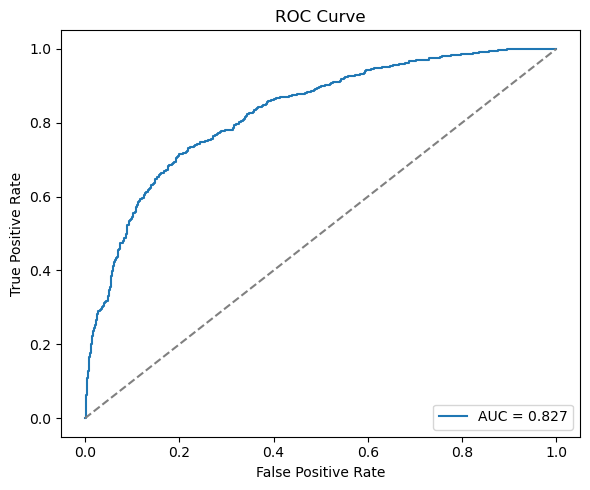

0.8272320889211067

In [78]:
plot_maf_roc_curve(scores_norm=vae_scores_norm, scores_ano=vae_scores_anom)

### Score histograms

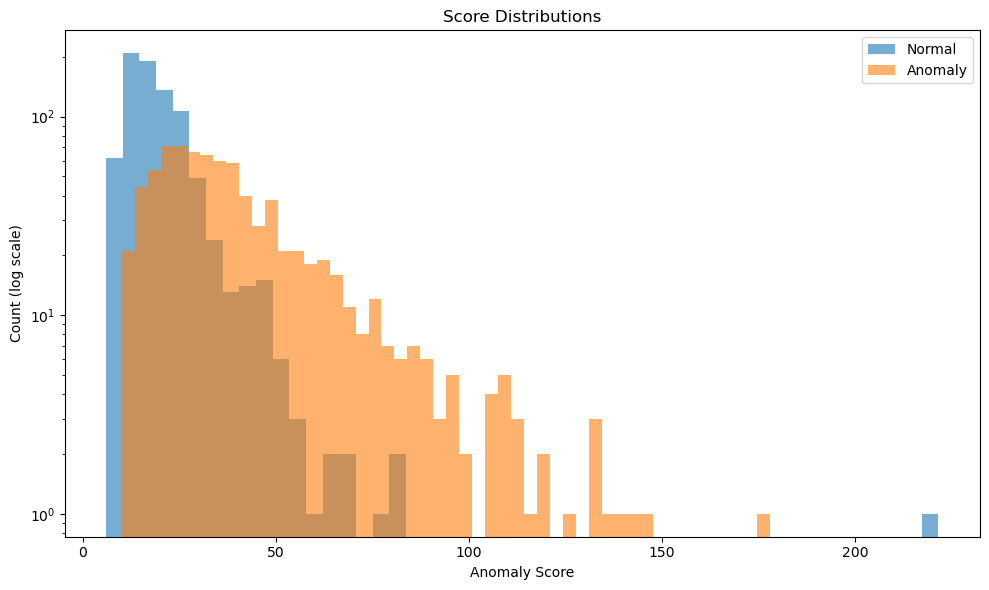

In [79]:
plot_score_histograms(vae_scores_norm, vae_scores_anom, norm_bins=50, anom_bins=50)

### Miscellaneous of metrics

In [80]:
y_true   = np.concatenate([np.zeros_like(vae_scores_norm), np.ones_like(vae_scores_anom)])
y_score = np.concatenate([vae_scores_norm, vae_scores_anom])

# 1) ROC-AUC
roc_auc = roc_auc_score(y_true, y_score)

# 2) PR-AUC
pr_auc  = average_precision_score(y_true, y_score)

# 3) TPR @ 1% FPR
fpr, tpr, thr = roc_curve(y_true, y_score)
tpr_at_1pct_fpr = tpr[fpr <= 0.05].max()  # might want .mean() if empty

# 4) Precision @ K
def precision_at_k(y_true, y_score, K):
    idx = np.argsort(y_score)[-K:]
    return y_true[idx].sum() / K

p_at_10  = precision_at_k(y_true, y_score, 10)
p_at_50  = precision_at_k(y_true, y_score, 50)
p_at_100 = precision_at_k(y_true, y_score, 100)

# 5) F1 @ chosen threshold
#    e.g. set threshold at 95th percentile of train scores
thr95 = np.percentile(y_score, 90)
y_pred = (y_score >= thr95).astype(int)
f1     = precision_score(y_true, y_pred, average="binary") * recall_score(y_true, y_pred, average="binary") * 2 \
           / (precision_score(y_true, y_pred) + recall_score(y_true, y_pred))

# 6) Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")
print(f"TPR@1%FPR: {tpr_at_1pct_fpr:.3f}")
print(f"P@10:     {p_at_10:.3f}, P@50: {p_at_50:.3f}, P@100: {p_at_100:.3f}")
print(f"F1@95thpct: {f1:.3f}")
print(f"MCC:       {mcc:.3f}")


ROC-AUC: 0.827
PR-AUC:  0.816
TPR@1%FPR: 0.330
P@10:     0.900, P@50: 0.980, P@100: 0.940
F1@95thpct: 0.319
MCC:       0.300


## Comparison of the Anomaly Detection models
I will compare the models by starting with a miscellaneous of metrics, then getting to ROC, Precision-Recall curves, confusion matrix and UMAP.

### Computing the scores

In [81]:
# 1) Compute anomaly scores for each model

# GMM (ensure compute_GMM_anomaly_scores is imported or defined)
_, scores_norm_gmm, scores_anom_gmm = eval_gmm_from_model(gmm, embeddings_test, embeddings_anom)

# MAF and RealNVP (using existing evaluate_to_visual)
scores_norm_maf, scores_anom_maf, _   = evaluate_to_visual(maf_model,     ds_test, ds_anom)
scores_norm_rnvp, scores_anom_rnvp, _ = evaluate_to_visual(realnvp_model, ds_test, ds_anom)

# VAE (using vae_anomaly_score)
vae_scores_norm = vae_anomaly_score(vae, ds_test)
vae_scores_anom = vae_anomaly_score(vae, ds_anom)

# 2) Aggregate into a dict
model_data = {
    "GMM":     (scores_norm_gmm,   scores_anom_gmm),
    "MAF":     (scores_norm_maf,   scores_anom_maf),
    "RealNVP": (scores_norm_rnvp,  scores_anom_rnvp),
    "VAE":     (vae_scores_norm,   vae_scores_anom),
}

AUROC = 0.8483
AUROC = 0.8466


### Metrics miscellaneous table

In [82]:
# Utility: precision@K
def precision_at_k(y_true, y_score, K):
    idx = np.argsort(y_score)[-K:]
    return y_true[idx].sum() / K


# 3) Build summary metrics table
rows = []
for name, (sn, sa) in model_data.items():
    y_true  = np.concatenate([np.zeros_like(sn),   np.ones_like(sa)])
    y_score = np.concatenate([sn, sa])
    thr95 = np.percentile(y_score, 95)
    y_pred = (y_score >= thr95).astype(int)
    
    rows.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(y_true, y_score),
        "PR-AUC": average_precision_score(y_true, y_score),
        "TPR@1%FPR": roc_curve(y_true, y_score)[1][roc_curve(y_true, y_score)[0] <= 0.01].max(),
        "P@10": precision_at_k(y_true, y_score, 10),
        "P@50": precision_at_k(y_true, y_score, 50),
        "P@100": precision_at_k(y_true, y_score, 100),
        "F1@95pct": precision_score(y_true, y_pred) * recall_score(y_true, y_pred) * 2 /
                    (precision_score(y_true, y_pred) + recall_score(y_true, y_pred)),
        "MCC": matthews_corrcoef(y_true, y_pred)
    })

df = pd.DataFrame(rows).set_index("Model")
display(df)

,ROC-AUC,PR-AUC,TPR@1%FPR,P@10,P@50,P@100,F1@95pct,MCC
Model,,,,,,,,
GMM,0.840221,0.816061,0.091136,0.9,0.90,0.91,0.165345,0.184261
MAF,0.848291,0.837072,0.163546,0.8,0.92,0.95,0.176670,0.212263
RealNVP,0.846615,0.832068,0.131086,0.8,0.92,0.94,0.172140,0.201062
VAE,0.827232,0.815553,0.166042,0.9,0.98,0.94,0.176670,0.212263


risultati

### ROC curves

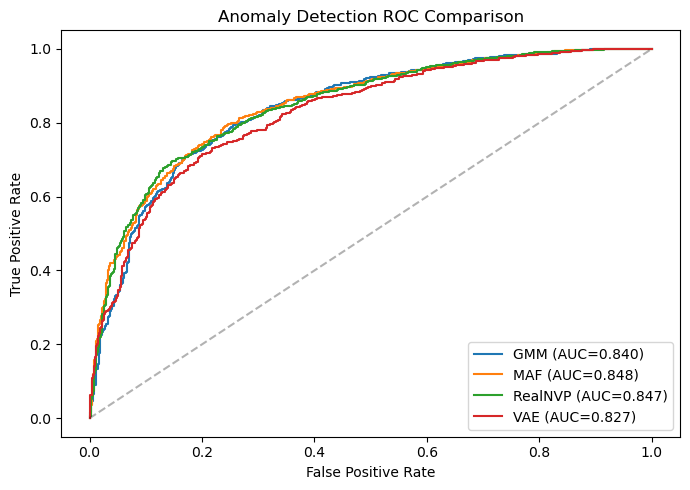

In [83]:
# 4) Plot ROC curves
plt.figure(figsize=(7,5))
for name, (sn, sa) in model_data.items():
    y_true  = np.concatenate([np.zeros_like(sn), np.ones_like(sa)])
    y_score = np.concatenate([sn, sa])
    fpr, tpr, _ = roc_curve(y_true, y_score)
    aucv = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={aucv:.3f})")
plt.plot([0,1], [0,1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Anomaly Detection ROC Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


risultati

### Precision-Recall curves

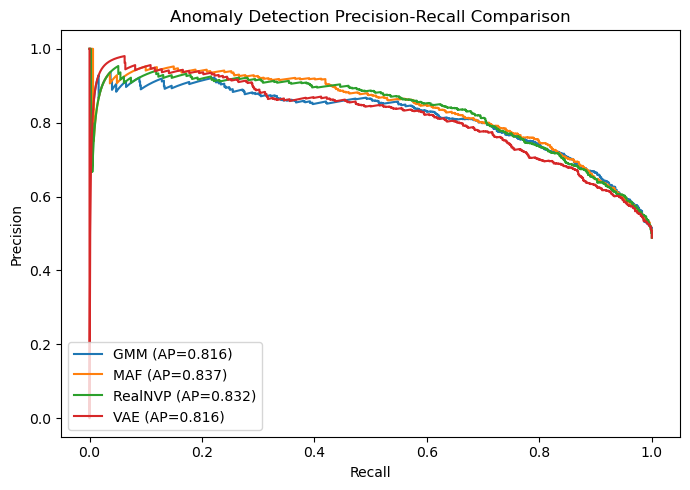

In [84]:
# 5) Plot Precision-Recall curves
plt.figure(figsize=(7,5))
for name, (sn, sa) in model_data.items():
    y_true  = np.concatenate([np.zeros_like(sn), np.ones_like(sa)])
    y_score = np.concatenate([sn, sa])
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Anomaly Detection Precision-Recall Comparison")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

risultati

### Confusion matrices

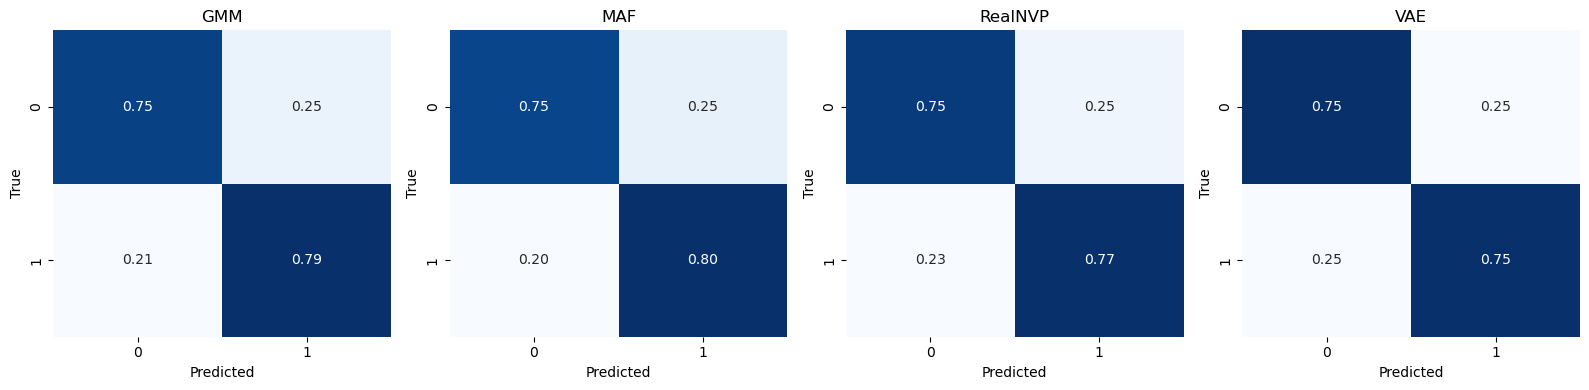

In [85]:
# 6) Confusion matrices at 95th percentile threshold
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, (name, (sn, sa)) in zip(axes, model_data.items()):
    y_true  = np.concatenate([np.zeros_like(sn), np.ones_like(sa)])
    y_score = np.concatenate([sn, sa])
    thr95   = np.percentile(sn, 75)
    y_pred  = (y_score >= thr95).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
    ax.set(title=name, xlabel="Predicted", ylabel="True")
plt.tight_layout()
plt.show()

risultati 

### UMAP plot

In [86]:
scores_norm_gmm.shape, scores_anom_gmm.shape, 

((837,), (801,))

/teo_fs_fast/software/miniforge/envs/acosso_tf2_12/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/teo_fs_fast/software/miniforge/envs/acosso_tf2_12/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/teo_fs_fast/software/miniforge/envs/acosso_tf2_12/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/teo_fs_fast/software/miniforge/envs/acosso_tf2_12/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


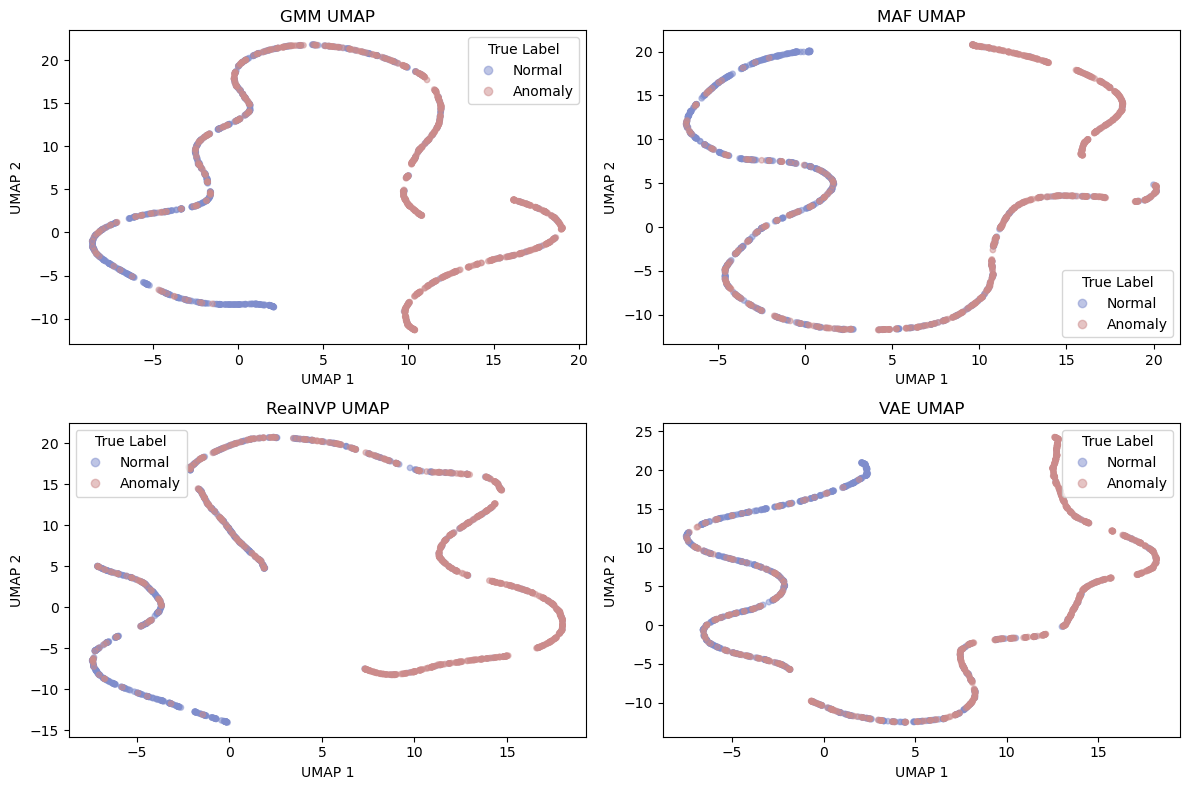

In [87]:
models_scores_norm = [scores_norm_gmm, scores_norm_maf, scores_norm_rnvp, vae_scores_norm]
models_scores_ano  = [scores_anom_gmm, scores_anom_maf, scores_anom_rnvp, vae_scores_anom]
model_names       = ['GMM','MAF','RealNVP','VAE']

plot_anom_umap_per_model(models_scores_norm, models_scores_ano, model_names, 
                    n_neighbors=40, min_dist=0.1)

risultati

### MAF vs RealNVP

To try to undrstand the the underperforming of the normalising flow's architecture i plot the difference between the PDF of the real data and the sampled data. I access the TransofrmedDistribution object inside the model and sample from it to obtain an approximation of the marginals. As you can see from the plot below the RealNVP is much more accurate in modelling the marginal distributions, maybe thanks to the added bijector in the chain (6 for the RealNVP and 5 for the MAF to not have gigantic training time). Besides this differences the MAF results to be more accurate than the RealNVP in the specific task.  

#### RealNVP

2025-06-25 12:49:49.134221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2025-06-25 12:49:49.135802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2025-06-25 12:49:49.145606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2025-06-25 12:49:49.146132: I tens

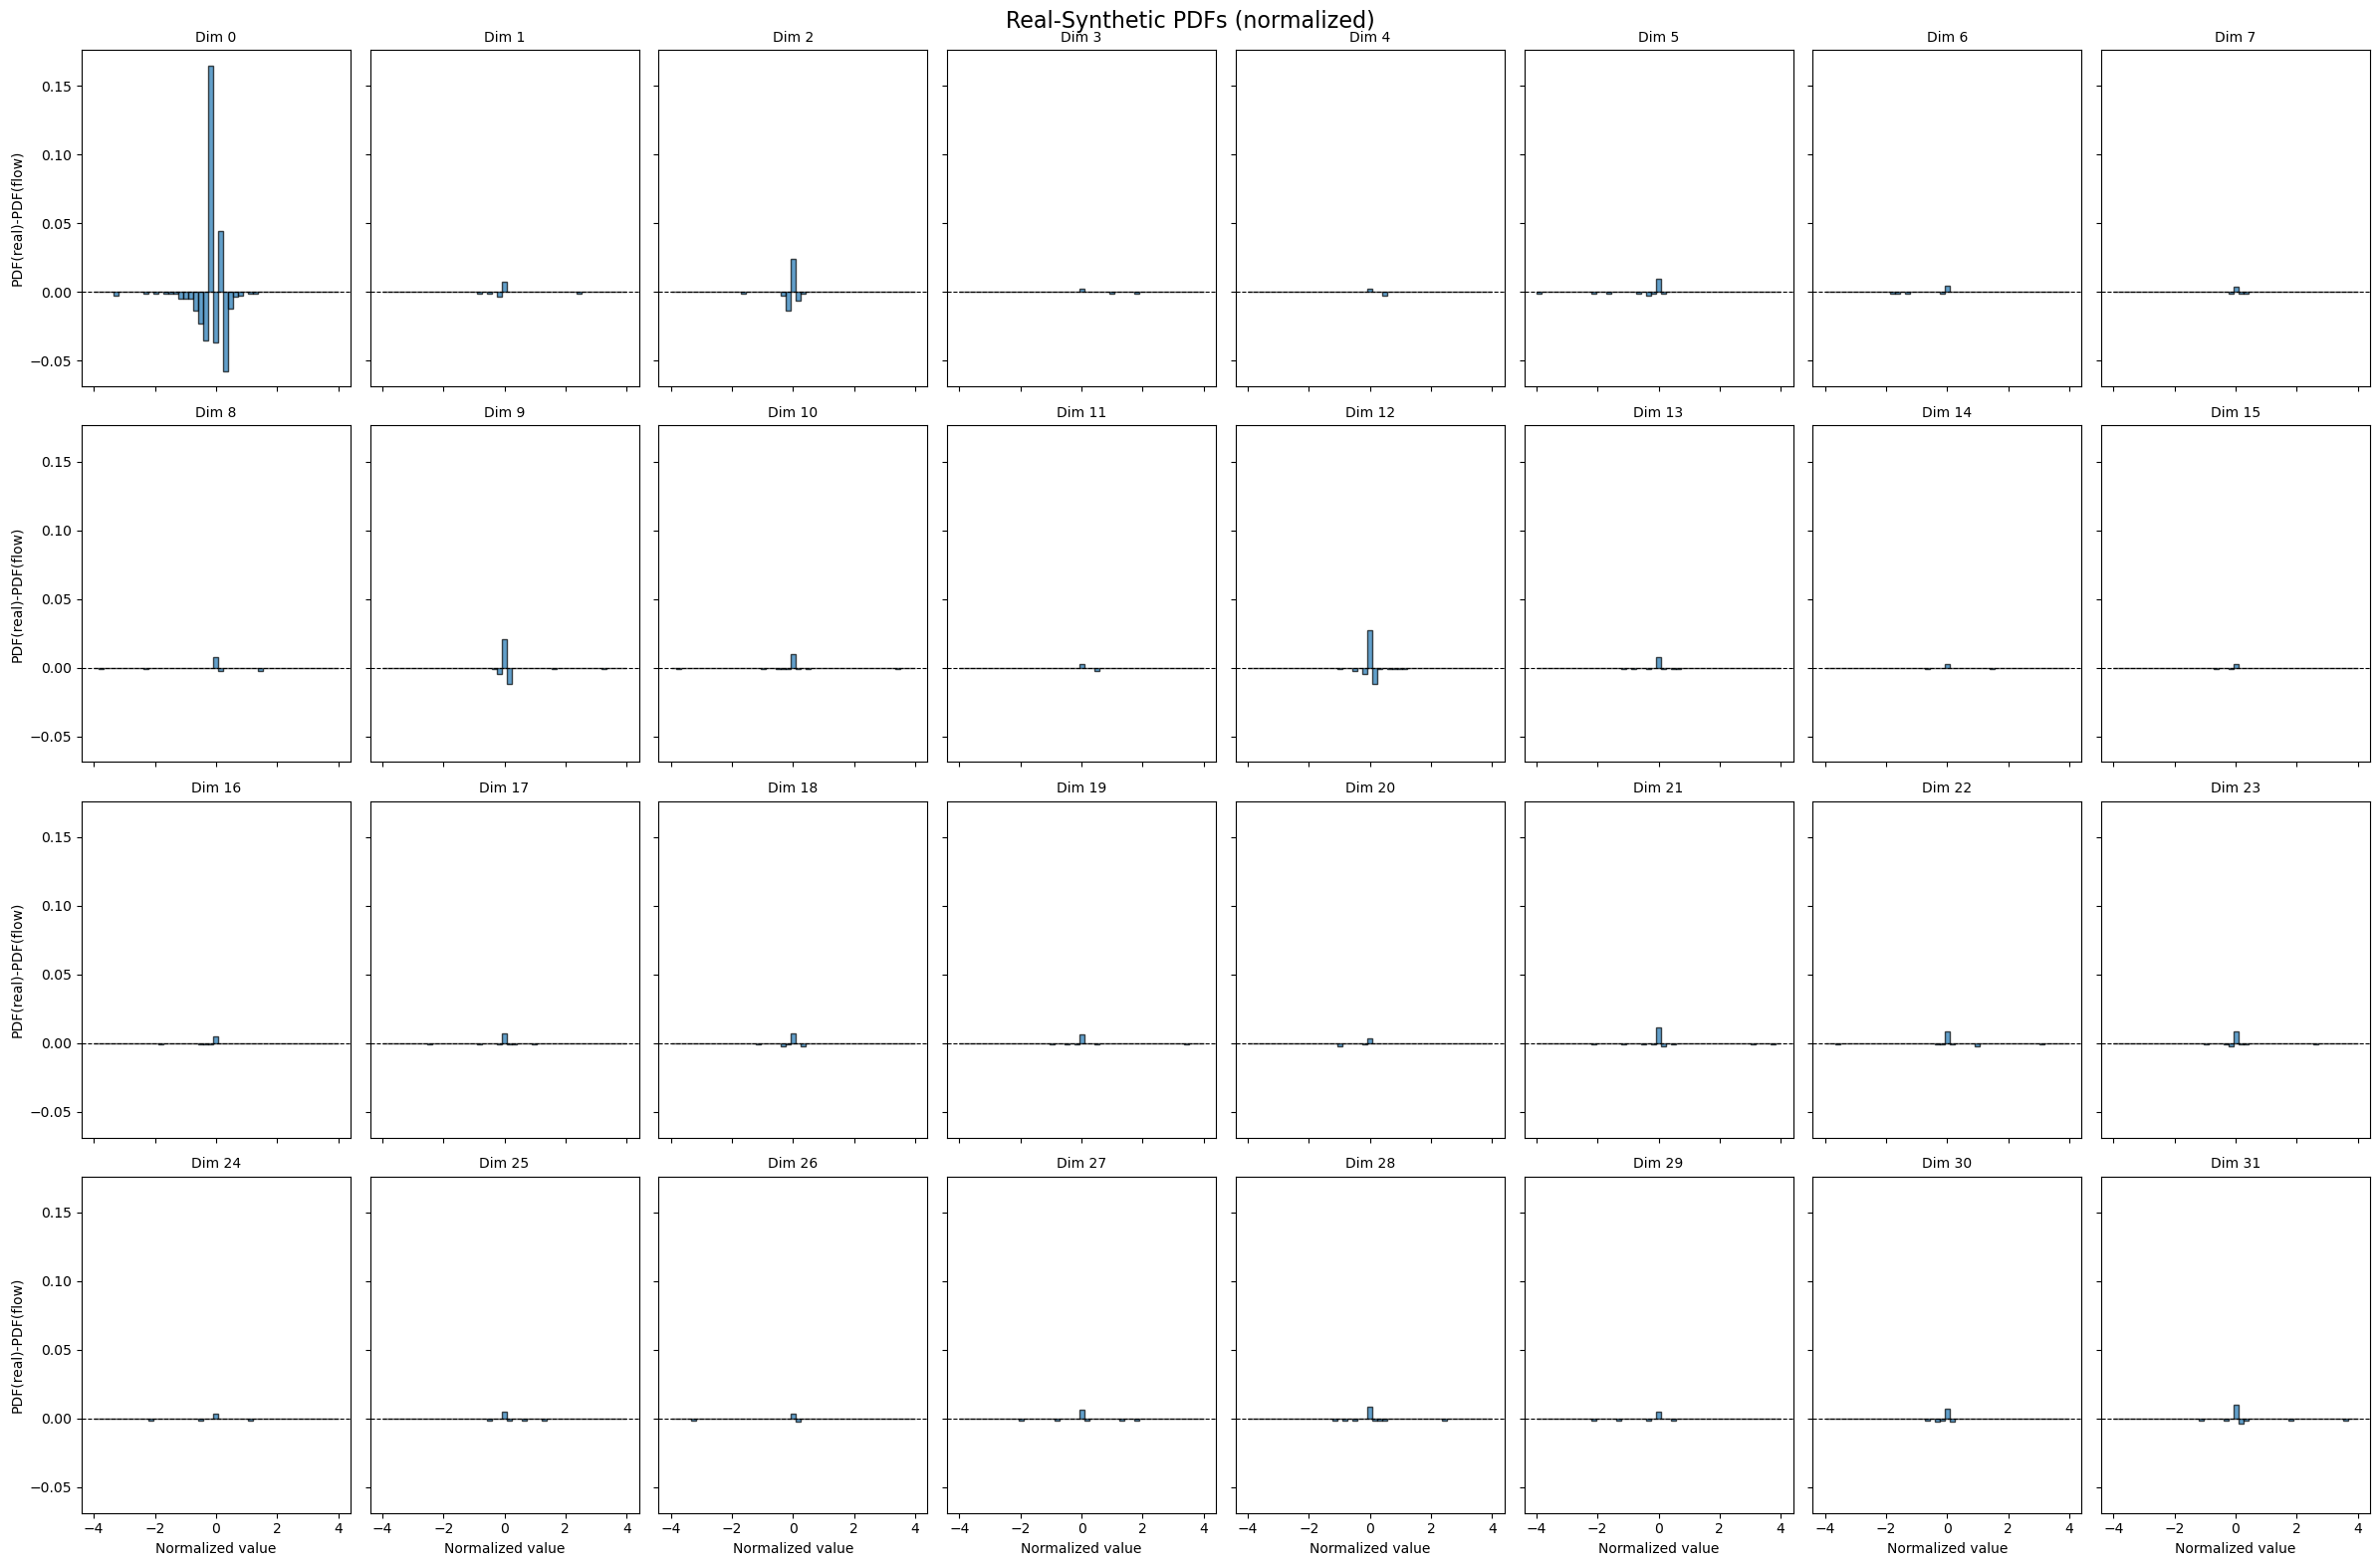

In [88]:
plot_marginal_differences(realnvp_model, ds_train)

#### MAF

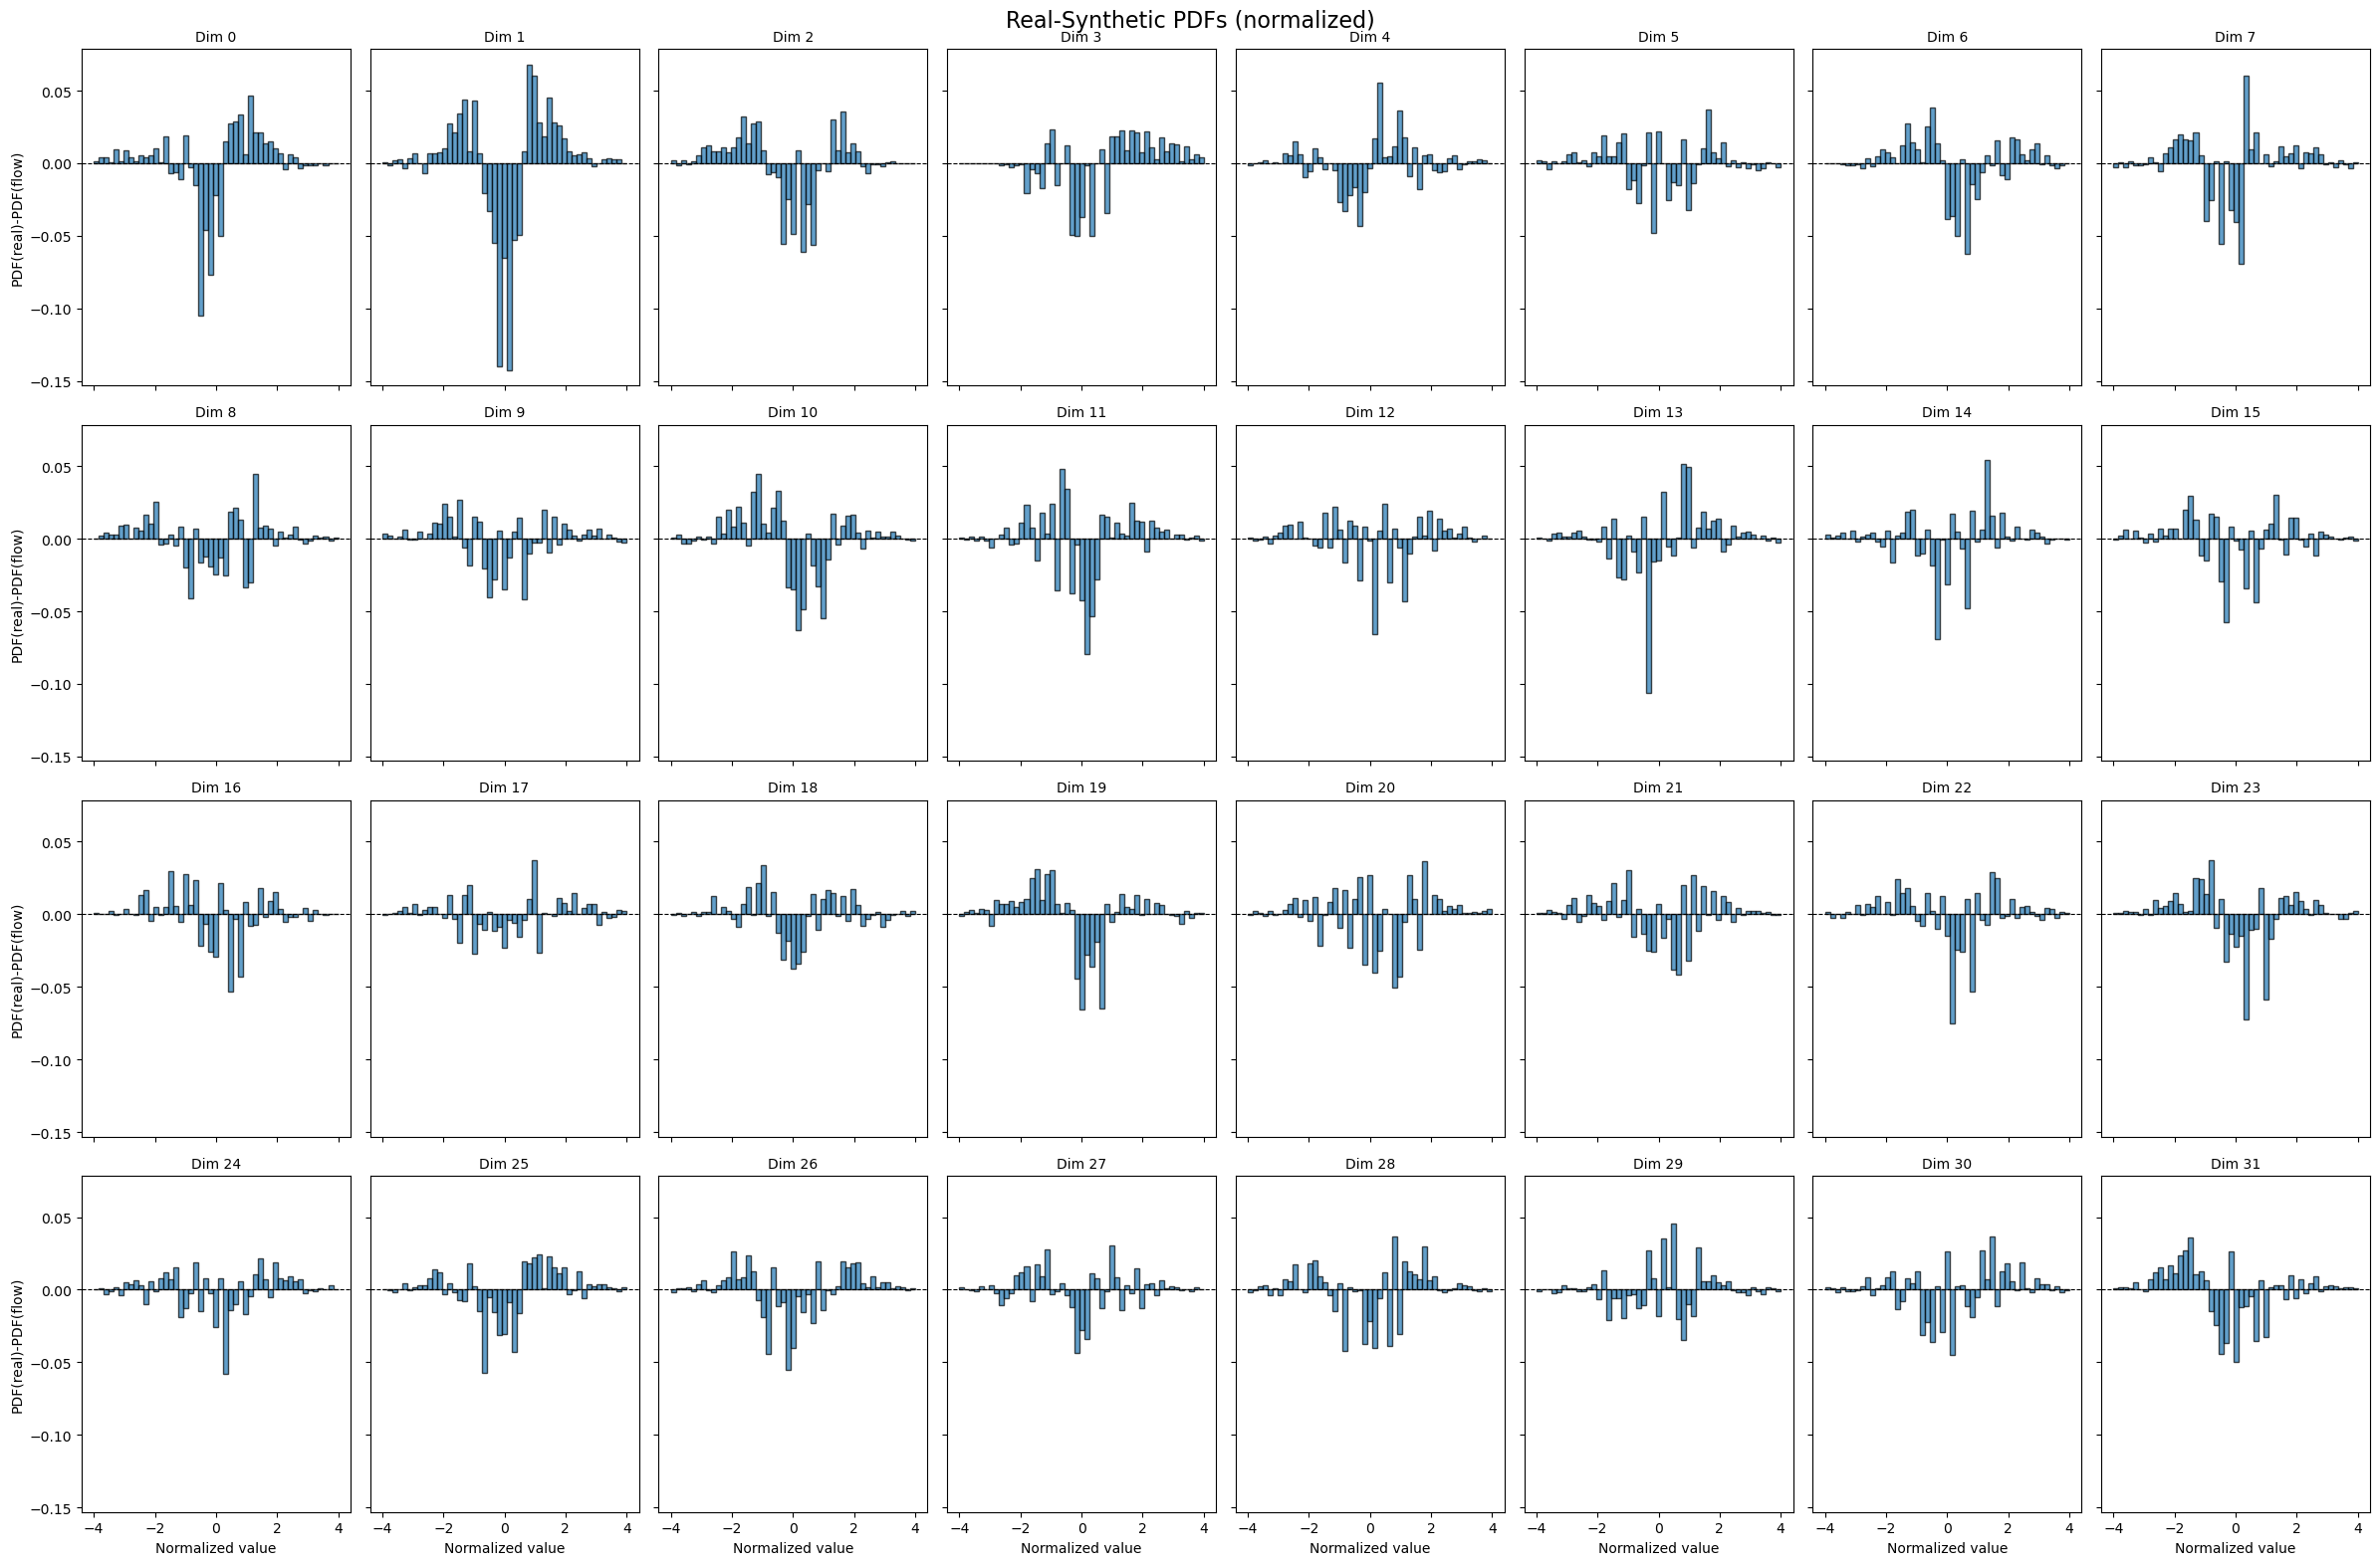

In [89]:
plot_marginal_differences(maf_model, ds_train)